In [3]:
%pylab inline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import warnings
warnings.simplefilter("ignore")
import json
import catboost as cb
from sklearn.model_selection import KFold,StratifiedKFold
#from paramsearch import paramsearch
from itertools import product,chain
import lightgbm as lgb
import re

Populating the interactive namespace from numpy and matplotlib


In [4]:
df_train = pd.read_csv(r'C:\Users\Администратор\Desktop/dota2_skill_train.csv', index_col='id')
df_test = pd.read_csv(r'C:\Users\Администратор\Desktop/dota2_skill_test.csv', index_col='id')

df_heroes = pd.read_csv(r'C:\Users\Администратор\Desktop/dota2_heroes.csv', index_col='hero_id')
df_items = pd.read_csv(r'C:\Users\Администратор\Desktop/dota2_items.csv', index_col='item_id')
df_abilities = pd.read_csv(r'C:\Users\Администратор\Desktop/dota2_abilities.csv', index_col='ability_id')

In [5]:
X = df_train.drop(columns=['skilled'])
X_test = df_test
y = df_train['skilled']

In [6]:
X.columns

Index(['player_team', 'winner_team', 'duration', 'pre_game_duration',
       'first_blood_time', 'first_blood_claimed', 'hero_id', 'hero_pick_order',
       'leaver_status', 'party_players', 'kills', 'deaths', 'assists',
       'denies', 'level', 'net_worth', 'gold', 'gold_spent', 'last_hits',
       'gold_per_min', 'xp_per_min', 'hero_damage', 'tower_damage',
       'hero_healing', 'scaled_hero_damage', 'scaled_tower_damage',
       'scaled_hero_healing', 'stuns', 'team_fight_participation',
       'observer_wards_placed', 'sentry_wards_placed', 'creeps_stacked',
       'camps_stacked', 'rune_pickups', 'tower_kills', 'roshan_kills',
       'nearby_creep_death_count', 'radiant_tower_status', 'dire_tower_status',
       'radiant_barracks_status', 'dire_barracks_status', 'fight_score',
       'farm_score', 'support_score', 'push_score', 'avg_kills_x16',
       'avg_deaths_x16', 'avg_assists_x16', 'avg_gpm_x16', 'avg_xpm_x16',
       'best_kills_x16', 'best_assists_x16', 'best_gpm_x16', '

# Feature Eng


In [7]:
df_train_add=[]
with open(r'C:\Users\Администратор\Desktop/dota2_skill_train.jsonlines') as fin:
          for line in fin:
            record = json.loads(line)
            
            features = {
                'id': record['id'],
                'num_purchase': len(record['item_purchase_log']), 
                'player_gold_mean': np.mean(record['series']['player_gold']), 
                'player_gold_max' : np.max(record['series']['player_gold']),
                'player_gold_median' : np.median(record['series']['player_gold']),
                'player_gold_last': record['series']['player_gold'][-1],
                'gold_percent' : np.mean(record['series']['player_gold'])*100/np.mean(record['series']['radiant_gold']),
                'kda_game': (record['kills']+record['assists'])/(record['deaths']+0.7),
                'kda_avg': (record['avg_kills_x16']+record['avg_assists_x16'])/(record['avg_deaths_x16']+0.7),
                'dps': record['hero_damage']/record['duration'],
                'ability_upgrades': len(record['ability_upgrades']),
                'final_items': len(record['final_items']),
                'duration_minute' : record['duration']/60,
              #  'avg_gold_x16' : record['avg_gpm_x16']*record['duration']/60,
             #   'avg_xp_x16' : record['avg_xpm_x16']*record['duration']/60,
              ##  'xp_earned': record['xp_per_min']*record['duration']/60,
               # 'gold_earned': record['gold_per_min']*record['duration']/60,
                'level_up_min': np.min(record['level_up_times']),
                'level_up_max': np.max(record['level_up_times']),
           #     'level_up_duration': record['duration'] - np.max(record['level_up_times']),            
                                               }
            df_train_add.append(features)

In [6]:
record

{'player_team': 'radiant',
 'winner_team': 'radiant',
 'duration': 2004,
 'pre_game_duration': 90,
 'first_blood_time': 109,
 'first_blood_claimed': 0,
 'team_fight_participation': 0.4,
 'stuns': 40.783203,
 'observer_wards_placed': 3,
 'sentry_wards_placed': 5,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups': 4,
 'tower_kills': 1,
 'roshan_kills': 0,
 'nearby_creep_death_count': 301,
 'damage_targets': {'npc_dota_creep_goodguys_ranged': 71,
  'npc_dota_neutral_forest_troll_berserker': 132,
  'npc_dota_hero_treant': 2039,
  'npc_dota_badguys_healers': 192,
  'npc_dota_badguys_tower3_mid': 128,
  'npc_dota_hero_viper': 1052,
  'npc_dota_badguys_fort': 216,
  'npc_dota_badguys_melee_rax_mid': 165,
  'npc_dota_neutral_satyr_soulstealer': 155,
  'npc_dota_creep_goodguys_melee': 347,
  'npc_dota_neutral_small_thunder_lizard': 96,
  'npc_dota_sentry_wards': 4,
  'npc_dota_neutral_forest_troll_high_priest': 34,
  'npc_dota_badguys_siege': 866,
  'npc_dota_neutral_centaur_outrunner'

In [8]:
addition = pd.DataFrame(df_train_add).set_index('id')

In [9]:
X_add = X.join(addition)

In [10]:
X_add = X_add.join(df_heroes, on='hero_id')

In [11]:
X_add['avg_gold_x16'] = X_add['avg_gpm_x16']*X_add['duration']/60
X_add['avg_xp_x16'] = X_add['avg_xpm_x16']*X_add['duration']/60
X_add['xp_earned'] = X_add['xp_per_min']*X_add['duration']/60
X_add['gold_earned'] = X_add['gold_per_min']*X_add['duration']/60
X_add['level_up_duration']= X_add['duration'] - X_add['level_up_max']
X_add['gold_per_sec']= X_add['gold_per_min']/60
X_add['xp_per_sec'] = X_add['xp_per_min']/60

In [12]:
X_add['player_team'] = X_add['player_team'].map(lambda s: 1 if s == 'radiant' else 0)
X_add['winner_team'] = X_add['winner_team'].map(lambda s: 1 if s == 'radiant' else 0)
X_add['attack_type'] = X_add['attack_type'].map(lambda s: 1 if s == 'Ranged' else 0)
X_add['primary_attr'] = X_add['primary_attr'].map(lambda s: 1 if s == 'str' else 2 if s=='agi' else 0)
X_add['localized_name'] = X_add['localized_name'].map(lambda s: len(s))

In [13]:
supports = []
pushers = []
carries =[]
escapes =[]
disablers =[]
nukers =[]
initiators =[]
junglers =[]
durables =[]
for i in range(1,130):
    try:
        if re.search(r'Support', df_heroes['roles'][i]):
            supports +=[i]
        if re.search(r'Pusher', df_heroes['roles'][i]):
            pushers +=[i]
        if re.search(r'Carry', df_heroes['roles'][i]):
            carries +=[i]
        if re.search(r'Escape', df_heroes['roles'][i]):
            escapes +=[i]
        if re.search(r'Disabler', df_heroes['roles'][i]):
            disablers +=[i]
        if re.search(r'Nuker', df_heroes['roles'][i]):
            nukers +=[i]
        if re.search(r'Initiator', df_heroes['roles'][i]):
            initiators +=[i]
        if re.search(r'Jungler', df_heroes['roles'][i]):
            junglers +=[i] 
        if re.search(r'Durable', df_heroes['roles'][i]):
            durables +=[i]
    except: pass

In [14]:
X_add['if_support'] = X['hero_id'].map(lambda x: 1 if x in supports else 0)
X_add['if_pusher'] = X['hero_id'].map(lambda x: 1 if x in pushers else 0)
X_add['if_carry'] = X['hero_id'].map(lambda x: 1 if x in carries else 0)
X_add['if_escape'] = X['hero_id'].map(lambda x: 1 if x in escapes else 0)
X_add['if_disabler'] = X['hero_id'].map(lambda x: 1 if x in disablers else 0)
X_add['if_nuker'] = X['hero_id'].map(lambda x: 1 if x in nukers else 0)
X_add['if_initiator'] = X['hero_id'].map(lambda x: 1 if x in initiators else 0)
X_add['if_jungler'] = X['hero_id'].map(lambda x: 1 if x in junglers else 0)
X_add['if_durable'] = X['hero_id'].map(lambda x: 1 if x in durables else 0)

In [15]:
#X_add = pd.get_dummies(X_add, columns = ['hero_id'])
X_add = X_add.drop(columns=['roles', 'name', 'hero_id'])

# Mean-1 and Mean-0

In [16]:
X_add = X_add.join(y)
X_mean_0 = pd.DataFrame([X_add[X_add['skilled']==0].mean(axis=0)])
X_median_0 = pd.DataFrame([X_add[X_add['skilled']==0].median(axis=0)])
X_max_0 = pd.DataFrame([X_add[X_add['skilled']==0].max(axis=0)])
X_min_0 = pd.DataFrame([X_add[X_add['skilled']==0].min(axis=0)])


X_mean_1 = pd.DataFrame([X_add[X_add['skilled']==1].mean(axis=0)])
X_median_1 = pd.DataFrame([X_add[X_add['skilled']==1].median(axis=0)])
X_max_1 = pd.DataFrame([X_add[X_add['skilled']==1].max(axis=0)])
X_min_1 = pd.DataFrame([X_add[X_add['skilled']==1].min(axis=0)])

X_add = X_add.drop(columns=['skilled'])

In [17]:
for i in X_add.columns:
    X_add[i + '_dif_mean_0'] = X_add[i]-float(X_mean_0[i])
    X_add[i + '_dif_mean_1'] = X_add[i]-float(X_mean_1[i])
    X_add[i + '_dif_median_0'] = X_add[i]-float(X_median_0[i])
    X_add[i + '_dif_median_1'] = X_add[i]-float(X_median_1[i])
    X_add[i + '_dif_max_0'] = X_add[i]-float(X_max_0[i])
    X_add[i + '_dif_max_1'] = X_add[i]-float(X_max_1[i])
    X_add[i + '_dif_min_0'] = X_add[i]-float(X_min_0[i])
    X_add[i + '_dif_min_1'] = X_add[i]-float(X_min_1[i])


In [18]:
X_add.head(2)

,player_team,winner_team,duration,pre_game_duration,first_blood_time,first_blood_claimed,hero_pick_order,leaver_status,party_players,kills,...,if_jungler_dif_min_0,if_jungler_dif_min_1,if_durable_dif_mean_0,if_durable_dif_mean_1,if_durable_dif_median_0,if_durable_dif_median_1,if_durable_dif_max_0,if_durable_dif_max_1,if_durable_dif_min_0,if_durable_dif_min_1
id,,,,,,,,,,,,,,,,,,,,,
7,0,0,2140,90,129,0,9,0,3,3,...,1.0,1.0,-0.367646,-0.363646,0.0,0.0,-1.0,-1.0,0.0,0.0
8,1,1,2138,90,174,0,5,0,1,3,...,1.0,1.0,-0.367646,-0.363646,0.0,0.0,-1.0,-1.0,0.0,0.0


# Classification


In [17]:
from sklearn.model_selection import RandomizedSearchCV

In [19]:
lgbbest2 = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.65,
 'learning_rate': 0.03,
 'max_bin': 512,
 'max_depth': 5,
 'metric': 'binary_error',
 'min_child_samples': 5,
 'min_child_weight': 1,
 'min_split_gain': 0.5,
 'n_estimators': 90,
 'nthread': 5,
 'num_class': 1,
 'num_iterations': 500,
 'num_leaves': 16,
 'objective': 'binary',
 'random_state': 501,
 'reg_alpha': 1,
 'reg_lambda': 1.2,
 'scale_pos_weight': 1,
 'subsample': 0.7,
 'subsample_for_bin': 200,
 'subsample_freq': 1}
model_lgb = lgb.LGBMClassifier(**lgbbest2)
cbbest = {'depth': 3,
          'iterations': 5000,
          'learning_rate': 0.03,
          'l2_leaf_reg': 10,
          'border_count': 200,
          'thread_count': 4,
          'verbose': True}
model_cb = cb.CatBoostClassifier(**cbbest)


In [ ]:
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
if True:
    SSS = StratifiedShuffleSplit(n_splits=5, random_state=np.random.seed(1337),train_size=0.7)
    #model_xgb = XGBClassifier(params = xgbparams)
   # model_lr = pipeline.make_pipeline(RobustScaler(),LogisticRegression(C = 0.1))
  #  model_rf = pipeline.make_pipeline(StandardScaler(),RandomForestClassifier())
   # GBoost = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.05,
           #                        max_depth=4, max_features='sqrt',
            #                       min_samples_leaf=15, min_samples_split=10, random_state =5)
    #Stacking_MODEL = StackingWithVotingClassifier(base_models=[model_lr],meta_model=GBoost)
    #voting = VotingClassifier(estimators=[('lgb1',model_lgb_last),('lgb',model_lgb)],voting="soft")
    peremen = cross_val_score(model_lgb,X_add,y,scoring = 'roc_auc',cv = SSS)
    display(peremen)
    display(peremen.mean())

In [18]:
#model_lgb.fit(X_add, y)
model_cb.fit(X_add, y)

0:	learn: 0.6896334	total: 283ms	remaining: 23m 35s
1:	learn: 0.6861823	total: 488ms	remaining: 20m 18s
2:	learn: 0.6829790	total: 735ms	remaining: 20m 23s
3:	learn: 0.6800496	total: 922ms	remaining: 19m 12s
4:	learn: 0.6771655	total: 1.12s	remaining: 18m 35s
5:	learn: 0.6744798	total: 1.28s	remaining: 17m 44s
6:	learn: 0.6718465	total: 1.48s	remaining: 17m 36s
7:	learn: 0.6694386	total: 1.62s	remaining: 16m 51s
8:	learn: 0.6670737	total: 1.8s	remaining: 16m 38s
9:	learn: 0.6646641	total: 1.95s	remaining: 16m 15s
10:	learn: 0.6624408	total: 2.12s	remaining: 16m 3s
11:	learn: 0.6604521	total: 2.27s	remaining: 15m 43s
12:	learn: 0.6584932	total: 2.43s	remaining: 15m 32s
13:	learn: 0.6565742	total: 2.57s	remaining: 15m 14s
14:	learn: 0.6547083	total: 2.72s	remaining: 15m 4s
15:	learn: 0.6530412	total: 2.85s	remaining: 14m 46s
16:	learn: 0.6514259	total: 2.98s	remaining: 14m 33s
17:	learn: 0.6499085	total: 3.1s	remaining: 14m 19s
18:	learn: 0.6485263	total: 3.23s	remaining: 14m 7s
19:	lear

160:	learn: 0.5871232	total: 17.9s	remaining: 8m 56s
161:	learn: 0.5869883	total: 17.9s	remaining: 8m 55s
162:	learn: 0.5867342	total: 18s	remaining: 8m 54s
163:	learn: 0.5865466	total: 18.1s	remaining: 8m 54s
164:	learn: 0.5863251	total: 18.2s	remaining: 8m 53s
165:	learn: 0.5860980	total: 18.3s	remaining: 8m 52s
166:	learn: 0.5859077	total: 18.4s	remaining: 8m 51s
167:	learn: 0.5857482	total: 18.5s	remaining: 8m 50s
168:	learn: 0.5855914	total: 18.5s	remaining: 8m 49s
169:	learn: 0.5853737	total: 18.6s	remaining: 8m 49s
170:	learn: 0.5852527	total: 18.7s	remaining: 8m 48s
171:	learn: 0.5850944	total: 18.8s	remaining: 8m 47s
172:	learn: 0.5849304	total: 18.9s	remaining: 8m 46s
173:	learn: 0.5847429	total: 19s	remaining: 8m 45s
174:	learn: 0.5846154	total: 19s	remaining: 8m 45s
175:	learn: 0.5844205	total: 19.1s	remaining: 8m 44s
176:	learn: 0.5842985	total: 19.2s	remaining: 8m 43s
177:	learn: 0.5841420	total: 19.3s	remaining: 8m 43s
178:	learn: 0.5839922	total: 19.4s	remaining: 8m 42s

316:	learn: 0.5655967	total: 35.7s	remaining: 8m 47s
317:	learn: 0.5654810	total: 35.8s	remaining: 8m 47s
318:	learn: 0.5653883	total: 36s	remaining: 8m 47s
319:	learn: 0.5653087	total: 36s	remaining: 8m 47s
320:	learn: 0.5652285	total: 36.2s	remaining: 8m 46s
321:	learn: 0.5650846	total: 36.3s	remaining: 8m 46s
322:	learn: 0.5649270	total: 36.3s	remaining: 8m 46s
323:	learn: 0.5648412	total: 36.4s	remaining: 8m 45s
324:	learn: 0.5646996	total: 36.5s	remaining: 8m 45s
325:	learn: 0.5645491	total: 36.6s	remaining: 8m 44s
326:	learn: 0.5644045	total: 36.7s	remaining: 8m 44s
327:	learn: 0.5642762	total: 36.8s	remaining: 8m 43s
328:	learn: 0.5641194	total: 36.9s	remaining: 8m 43s
329:	learn: 0.5640125	total: 37s	remaining: 8m 42s
330:	learn: 0.5638968	total: 37s	remaining: 8m 42s
331:	learn: 0.5638115	total: 37.1s	remaining: 8m 42s
332:	learn: 0.5636997	total: 37.3s	remaining: 8m 42s
333:	learn: 0.5635952	total: 37.4s	remaining: 8m 42s
334:	learn: 0.5635151	total: 37.5s	remaining: 8m 42s
3

473:	learn: 0.5505774	total: 53.6s	remaining: 8m 32s
474:	learn: 0.5504672	total: 53.7s	remaining: 8m 31s
475:	learn: 0.5503876	total: 53.8s	remaining: 8m 31s
476:	learn: 0.5502926	total: 53.9s	remaining: 8m 31s
477:	learn: 0.5502076	total: 54s	remaining: 8m 30s
478:	learn: 0.5500710	total: 54.1s	remaining: 8m 30s
479:	learn: 0.5500043	total: 54.2s	remaining: 8m 30s
480:	learn: 0.5499544	total: 54.3s	remaining: 8m 29s
481:	learn: 0.5498826	total: 54.3s	remaining: 8m 29s
482:	learn: 0.5498303	total: 54.4s	remaining: 8m 28s
483:	learn: 0.5497285	total: 54.5s	remaining: 8m 28s
484:	learn: 0.5495960	total: 54.6s	remaining: 8m 28s
485:	learn: 0.5495185	total: 54.8s	remaining: 8m 28s
486:	learn: 0.5494607	total: 54.9s	remaining: 8m 28s
487:	learn: 0.5493942	total: 55s	remaining: 8m 28s
488:	learn: 0.5493173	total: 55s	remaining: 8m 27s
489:	learn: 0.5492451	total: 55.1s	remaining: 8m 27s
490:	learn: 0.5491898	total: 55.2s	remaining: 8m 27s
491:	learn: 0.5491165	total: 55.3s	remaining: 8m 27s

630:	learn: 0.5390467	total: 1m 10s	remaining: 8m 8s
631:	learn: 0.5390108	total: 1m 10s	remaining: 8m 7s
632:	learn: 0.5389667	total: 1m 10s	remaining: 8m 7s
633:	learn: 0.5389288	total: 1m 10s	remaining: 8m 7s
634:	learn: 0.5388766	total: 1m 10s	remaining: 8m 7s
635:	learn: 0.5388095	total: 1m 11s	remaining: 8m 7s
636:	learn: 0.5387260	total: 1m 11s	remaining: 8m 7s
637:	learn: 0.5386524	total: 1m 11s	remaining: 8m 7s
638:	learn: 0.5385908	total: 1m 11s	remaining: 8m 7s
639:	learn: 0.5385281	total: 1m 11s	remaining: 8m 7s
640:	learn: 0.5384665	total: 1m 11s	remaining: 8m 7s
641:	learn: 0.5383610	total: 1m 11s	remaining: 8m 7s
642:	learn: 0.5382989	total: 1m 11s	remaining: 8m 6s
643:	learn: 0.5382336	total: 1m 11s	remaining: 8m 6s
644:	learn: 0.5381464	total: 1m 12s	remaining: 8m 6s
645:	learn: 0.5380983	total: 1m 12s	remaining: 8m 6s
646:	learn: 0.5380358	total: 1m 12s	remaining: 8m 6s
647:	learn: 0.5379809	total: 1m 12s	remaining: 8m 6s
648:	learn: 0.5379283	total: 1m 12s	remaining:

784:	learn: 0.5301669	total: 1m 31s	remaining: 8m 12s
785:	learn: 0.5300925	total: 1m 32s	remaining: 8m 13s
786:	learn: 0.5300450	total: 1m 32s	remaining: 8m 13s
787:	learn: 0.5300077	total: 1m 32s	remaining: 8m 13s
788:	learn: 0.5299404	total: 1m 32s	remaining: 8m 14s
789:	learn: 0.5298828	total: 1m 32s	remaining: 8m 14s
790:	learn: 0.5298432	total: 1m 32s	remaining: 8m 14s
791:	learn: 0.5297997	total: 1m 33s	remaining: 8m 14s
792:	learn: 0.5297560	total: 1m 33s	remaining: 8m 17s
793:	learn: 0.5297242	total: 1m 34s	remaining: 8m 17s
794:	learn: 0.5296646	total: 1m 34s	remaining: 8m 19s
795:	learn: 0.5296190	total: 1m 34s	remaining: 8m 20s
796:	learn: 0.5295669	total: 1m 35s	remaining: 8m 21s
797:	learn: 0.5295181	total: 1m 35s	remaining: 8m 21s
798:	learn: 0.5294714	total: 1m 35s	remaining: 8m 21s
799:	learn: 0.5294079	total: 1m 35s	remaining: 8m 22s
800:	learn: 0.5293610	total: 1m 36s	remaining: 8m 23s
801:	learn: 0.5292857	total: 1m 36s	remaining: 8m 24s
802:	learn: 0.5292393	total:

937:	learn: 0.5226943	total: 1m 53s	remaining: 8m 12s
938:	learn: 0.5226398	total: 1m 53s	remaining: 8m 12s
939:	learn: 0.5226054	total: 1m 54s	remaining: 8m 12s
940:	learn: 0.5225834	total: 1m 54s	remaining: 8m 12s
941:	learn: 0.5225422	total: 1m 54s	remaining: 8m 12s
942:	learn: 0.5225048	total: 1m 54s	remaining: 8m 12s
943:	learn: 0.5224584	total: 1m 54s	remaining: 8m 12s
944:	learn: 0.5224237	total: 1m 54s	remaining: 8m 11s
945:	learn: 0.5223891	total: 1m 54s	remaining: 8m 11s
946:	learn: 0.5223413	total: 1m 54s	remaining: 8m 11s
947:	learn: 0.5222762	total: 1m 54s	remaining: 8m 11s
948:	learn: 0.5222138	total: 1m 54s	remaining: 8m 10s
949:	learn: 0.5221519	total: 1m 55s	remaining: 8m 10s
950:	learn: 0.5221281	total: 1m 55s	remaining: 8m 10s
951:	learn: 0.5220766	total: 1m 55s	remaining: 8m 10s
952:	learn: 0.5220534	total: 1m 55s	remaining: 8m 9s
953:	learn: 0.5219821	total: 1m 55s	remaining: 8m 9s
954:	learn: 0.5219501	total: 1m 55s	remaining: 8m 9s
955:	learn: 0.5219023	total: 1m

1091:	learn: 0.5160229	total: 2m 10s	remaining: 7m 47s
1092:	learn: 0.5159791	total: 2m 10s	remaining: 7m 47s
1093:	learn: 0.5159429	total: 2m 10s	remaining: 7m 47s
1094:	learn: 0.5159226	total: 2m 11s	remaining: 7m 47s
1095:	learn: 0.5158830	total: 2m 11s	remaining: 7m 47s
1096:	learn: 0.5158290	total: 2m 11s	remaining: 7m 47s
1097:	learn: 0.5158055	total: 2m 11s	remaining: 7m 47s
1098:	learn: 0.5157831	total: 2m 11s	remaining: 7m 46s
1099:	learn: 0.5157427	total: 2m 11s	remaining: 7m 46s
1100:	learn: 0.5157161	total: 2m 11s	remaining: 7m 46s
1101:	learn: 0.5156819	total: 2m 11s	remaining: 7m 46s
1102:	learn: 0.5156569	total: 2m 12s	remaining: 7m 46s
1103:	learn: 0.5156055	total: 2m 12s	remaining: 7m 46s
1104:	learn: 0.5155530	total: 2m 12s	remaining: 7m 46s
1105:	learn: 0.5155208	total: 2m 12s	remaining: 7m 46s
1106:	learn: 0.5154767	total: 2m 12s	remaining: 7m 46s
1107:	learn: 0.5154197	total: 2m 12s	remaining: 7m 46s
1108:	learn: 0.5153851	total: 2m 13s	remaining: 7m 46s
1109:	lear

1241:	learn: 0.5104756	total: 2m 27s	remaining: 7m 26s
1242:	learn: 0.5104410	total: 2m 27s	remaining: 7m 26s
1243:	learn: 0.5103908	total: 2m 27s	remaining: 7m 26s
1244:	learn: 0.5103661	total: 2m 27s	remaining: 7m 26s
1245:	learn: 0.5103311	total: 2m 28s	remaining: 7m 25s
1246:	learn: 0.5102842	total: 2m 28s	remaining: 7m 25s
1247:	learn: 0.5102476	total: 2m 28s	remaining: 7m 25s
1248:	learn: 0.5102239	total: 2m 28s	remaining: 7m 25s
1249:	learn: 0.5101936	total: 2m 28s	remaining: 7m 25s
1250:	learn: 0.5101701	total: 2m 28s	remaining: 7m 25s
1251:	learn: 0.5101459	total: 2m 28s	remaining: 7m 25s
1252:	learn: 0.5100968	total: 2m 29s	remaining: 7m 25s
1253:	learn: 0.5100542	total: 2m 29s	remaining: 7m 25s
1254:	learn: 0.5100095	total: 2m 29s	remaining: 7m 25s
1255:	learn: 0.5099655	total: 2m 29s	remaining: 7m 25s
1256:	learn: 0.5099370	total: 2m 29s	remaining: 7m 25s
1257:	learn: 0.5098934	total: 2m 29s	remaining: 7m 25s
1258:	learn: 0.5098659	total: 2m 29s	remaining: 7m 25s
1259:	lear

1390:	learn: 0.5056871	total: 2m 46s	remaining: 7m 12s
1391:	learn: 0.5056672	total: 2m 46s	remaining: 7m 12s
1392:	learn: 0.5056335	total: 2m 46s	remaining: 7m 12s
1393:	learn: 0.5055893	total: 2m 47s	remaining: 7m 12s
1394:	learn: 0.5055569	total: 2m 47s	remaining: 7m 11s
1395:	learn: 0.5055228	total: 2m 47s	remaining: 7m 11s
1396:	learn: 0.5054755	total: 2m 47s	remaining: 7m 11s
1397:	learn: 0.5054504	total: 2m 47s	remaining: 7m 11s
1398:	learn: 0.5054188	total: 2m 47s	remaining: 7m 11s
1399:	learn: 0.5053942	total: 2m 47s	remaining: 7m 11s
1400:	learn: 0.5053493	total: 2m 47s	remaining: 7m 10s
1401:	learn: 0.5053271	total: 2m 47s	remaining: 7m 10s
1402:	learn: 0.5053041	total: 2m 47s	remaining: 7m 10s
1403:	learn: 0.5052820	total: 2m 48s	remaining: 7m 10s
1404:	learn: 0.5052545	total: 2m 48s	remaining: 7m 10s
1405:	learn: 0.5052242	total: 2m 48s	remaining: 7m 10s
1406:	learn: 0.5051734	total: 2m 48s	remaining: 7m 9s
1407:	learn: 0.5051506	total: 2m 48s	remaining: 7m 9s
1408:	learn:

1544:	learn: 0.5012529	total: 3m 1s	remaining: 6m 45s
1545:	learn: 0.5012271	total: 3m 1s	remaining: 6m 45s
1546:	learn: 0.5012089	total: 3m 1s	remaining: 6m 44s
1547:	learn: 0.5011907	total: 3m 1s	remaining: 6m 44s
1548:	learn: 0.5011673	total: 3m 1s	remaining: 6m 44s
1549:	learn: 0.5011433	total: 3m 1s	remaining: 6m 44s
1550:	learn: 0.5011131	total: 3m 1s	remaining: 6m 44s
1551:	learn: 0.5010717	total: 3m 1s	remaining: 6m 44s
1552:	learn: 0.5010551	total: 3m 1s	remaining: 6m 43s
1553:	learn: 0.5010286	total: 3m 2s	remaining: 6m 43s
1554:	learn: 0.5010062	total: 3m 2s	remaining: 6m 43s
1555:	learn: 0.5009947	total: 3m 2s	remaining: 6m 43s
1556:	learn: 0.5009616	total: 3m 2s	remaining: 6m 43s
1557:	learn: 0.5009332	total: 3m 2s	remaining: 6m 43s
1558:	learn: 0.5009027	total: 3m 2s	remaining: 6m 42s
1559:	learn: 0.5008591	total: 3m 2s	remaining: 6m 42s
1560:	learn: 0.5008326	total: 3m 2s	remaining: 6m 42s
1561:	learn: 0.5008170	total: 3m 2s	remaining: 6m 42s
1562:	learn: 0.5008006	total

1697:	learn: 0.4972329	total: 3m 17s	remaining: 6m 23s
1698:	learn: 0.4971847	total: 3m 17s	remaining: 6m 23s
1699:	learn: 0.4971589	total: 3m 17s	remaining: 6m 23s
1700:	learn: 0.4971292	total: 3m 17s	remaining: 6m 22s
1701:	learn: 0.4971063	total: 3m 17s	remaining: 6m 22s
1702:	learn: 0.4970783	total: 3m 17s	remaining: 6m 22s
1703:	learn: 0.4970402	total: 3m 17s	remaining: 6m 22s
1704:	learn: 0.4970071	total: 3m 17s	remaining: 6m 22s
1705:	learn: 0.4969946	total: 3m 17s	remaining: 6m 22s
1706:	learn: 0.4969641	total: 3m 18s	remaining: 6m 22s
1707:	learn: 0.4969367	total: 3m 18s	remaining: 6m 21s
1708:	learn: 0.4969154	total: 3m 18s	remaining: 6m 21s
1709:	learn: 0.4968748	total: 3m 18s	remaining: 6m 21s
1710:	learn: 0.4968598	total: 3m 18s	remaining: 6m 21s
1711:	learn: 0.4968370	total: 3m 18s	remaining: 6m 21s
1712:	learn: 0.4968011	total: 3m 18s	remaining: 6m 21s
1713:	learn: 0.4967761	total: 3m 18s	remaining: 6m 21s
1714:	learn: 0.4967364	total: 3m 18s	remaining: 6m 20s
1715:	lear

1848:	learn: 0.4935516	total: 3m 34s	remaining: 6m 5s
1849:	learn: 0.4935289	total: 3m 34s	remaining: 6m 5s
1850:	learn: 0.4935088	total: 3m 34s	remaining: 6m 5s
1851:	learn: 0.4934929	total: 3m 34s	remaining: 6m 5s
1852:	learn: 0.4934687	total: 3m 34s	remaining: 6m 4s
1853:	learn: 0.4934491	total: 3m 34s	remaining: 6m 4s
1854:	learn: 0.4934283	total: 3m 35s	remaining: 6m 4s
1855:	learn: 0.4934012	total: 3m 35s	remaining: 6m 4s
1856:	learn: 0.4933824	total: 3m 35s	remaining: 6m 4s
1857:	learn: 0.4933589	total: 3m 35s	remaining: 6m 4s
1858:	learn: 0.4933439	total: 3m 35s	remaining: 6m 4s
1859:	learn: 0.4933253	total: 3m 35s	remaining: 6m 3s
1860:	learn: 0.4933087	total: 3m 35s	remaining: 6m 3s
1861:	learn: 0.4932991	total: 3m 35s	remaining: 6m 3s
1862:	learn: 0.4932749	total: 3m 35s	remaining: 6m 3s
1863:	learn: 0.4932628	total: 3m 35s	remaining: 6m 3s
1864:	learn: 0.4932382	total: 3m 36s	remaining: 6m 3s
1865:	learn: 0.4932139	total: 3m 36s	remaining: 6m 3s
1866:	learn: 0.4931894	total

1999:	learn: 0.4902571	total: 3m 52s	remaining: 5m 48s
2000:	learn: 0.4902327	total: 3m 52s	remaining: 5m 47s
2001:	learn: 0.4902168	total: 3m 52s	remaining: 5m 47s
2002:	learn: 0.4901913	total: 3m 52s	remaining: 5m 47s
2003:	learn: 0.4901710	total: 3m 52s	remaining: 5m 47s
2004:	learn: 0.4901460	total: 3m 52s	remaining: 5m 47s
2005:	learn: 0.4901342	total: 3m 52s	remaining: 5m 47s
2006:	learn: 0.4901217	total: 3m 52s	remaining: 5m 47s
2007:	learn: 0.4901020	total: 3m 52s	remaining: 5m 47s
2008:	learn: 0.4900642	total: 3m 52s	remaining: 5m 46s
2009:	learn: 0.4900427	total: 3m 53s	remaining: 5m 46s
2010:	learn: 0.4900200	total: 3m 53s	remaining: 5m 46s
2011:	learn: 0.4900012	total: 3m 53s	remaining: 5m 46s
2012:	learn: 0.4899800	total: 3m 53s	remaining: 5m 46s
2013:	learn: 0.4899539	total: 3m 53s	remaining: 5m 46s
2014:	learn: 0.4899296	total: 3m 53s	remaining: 5m 46s
2015:	learn: 0.4899077	total: 3m 53s	remaining: 5m 45s
2016:	learn: 0.4898938	total: 3m 53s	remaining: 5m 45s
2017:	lear

2151:	learn: 0.4871712	total: 4m 6s	remaining: 5m 26s
2152:	learn: 0.4871585	total: 4m 6s	remaining: 5m 26s
2153:	learn: 0.4871424	total: 4m 6s	remaining: 5m 25s
2154:	learn: 0.4871293	total: 4m 6s	remaining: 5m 25s
2155:	learn: 0.4871150	total: 4m 6s	remaining: 5m 25s
2156:	learn: 0.4871035	total: 4m 6s	remaining: 5m 25s
2157:	learn: 0.4870889	total: 4m 6s	remaining: 5m 25s
2158:	learn: 0.4870681	total: 4m 7s	remaining: 5m 25s
2159:	learn: 0.4870306	total: 4m 7s	remaining: 5m 24s
2160:	learn: 0.4870211	total: 4m 7s	remaining: 5m 24s
2161:	learn: 0.4870056	total: 4m 7s	remaining: 5m 24s
2162:	learn: 0.4869888	total: 4m 7s	remaining: 5m 24s
2163:	learn: 0.4869669	total: 4m 7s	remaining: 5m 24s
2164:	learn: 0.4869428	total: 4m 7s	remaining: 5m 24s
2165:	learn: 0.4869356	total: 4m 7s	remaining: 5m 24s
2166:	learn: 0.4869161	total: 4m 7s	remaining: 5m 23s
2167:	learn: 0.4868913	total: 4m 7s	remaining: 5m 23s
2168:	learn: 0.4868771	total: 4m 7s	remaining: 5m 23s
2169:	learn: 0.4868667	total

2304:	learn: 0.4841666	total: 4m 19s	remaining: 5m 3s
2305:	learn: 0.4841511	total: 4m 19s	remaining: 5m 3s
2306:	learn: 0.4841216	total: 4m 19s	remaining: 5m 3s
2307:	learn: 0.4841015	total: 4m 19s	remaining: 5m 2s
2308:	learn: 0.4840869	total: 4m 19s	remaining: 5m 2s
2309:	learn: 0.4840681	total: 4m 19s	remaining: 5m 2s
2310:	learn: 0.4840400	total: 4m 20s	remaining: 5m 2s
2311:	learn: 0.4840257	total: 4m 20s	remaining: 5m 2s
2312:	learn: 0.4840102	total: 4m 20s	remaining: 5m 2s
2313:	learn: 0.4839931	total: 4m 20s	remaining: 5m 2s
2314:	learn: 0.4839665	total: 4m 20s	remaining: 5m 1s
2315:	learn: 0.4839509	total: 4m 20s	remaining: 5m 1s
2316:	learn: 0.4839335	total: 4m 20s	remaining: 5m 1s
2317:	learn: 0.4839153	total: 4m 20s	remaining: 5m 1s
2318:	learn: 0.4838972	total: 4m 20s	remaining: 5m 1s
2319:	learn: 0.4838776	total: 4m 20s	remaining: 5m 1s
2320:	learn: 0.4838525	total: 4m 20s	remaining: 5m 1s
2321:	learn: 0.4838333	total: 4m 20s	remaining: 5m
2322:	learn: 0.4838228	total: 4

2455:	learn: 0.4812798	total: 4m 33s	remaining: 4m 42s
2456:	learn: 0.4812653	total: 4m 33s	remaining: 4m 42s
2457:	learn: 0.4812485	total: 4m 33s	remaining: 4m 42s
2458:	learn: 0.4812375	total: 4m 33s	remaining: 4m 42s
2459:	learn: 0.4812226	total: 4m 33s	remaining: 4m 42s
2460:	learn: 0.4812096	total: 4m 33s	remaining: 4m 42s
2461:	learn: 0.4811634	total: 4m 33s	remaining: 4m 42s
2462:	learn: 0.4811475	total: 4m 33s	remaining: 4m 42s
2463:	learn: 0.4811262	total: 4m 33s	remaining: 4m 41s
2464:	learn: 0.4811141	total: 4m 34s	remaining: 4m 41s
2465:	learn: 0.4810927	total: 4m 34s	remaining: 4m 41s
2466:	learn: 0.4810793	total: 4m 34s	remaining: 4m 41s
2467:	learn: 0.4810678	total: 4m 34s	remaining: 4m 41s
2468:	learn: 0.4810467	total: 4m 34s	remaining: 4m 41s
2469:	learn: 0.4810201	total: 4m 34s	remaining: 4m 41s
2470:	learn: 0.4809964	total: 4m 34s	remaining: 4m 41s
2471:	learn: 0.4809853	total: 4m 34s	remaining: 4m 40s
2472:	learn: 0.4809747	total: 4m 34s	remaining: 4m 40s
2473:	lear

2604:	learn: 0.4787238	total: 4m 50s	remaining: 4m 26s
2605:	learn: 0.4787000	total: 4m 50s	remaining: 4m 26s
2606:	learn: 0.4786783	total: 4m 50s	remaining: 4m 26s
2607:	learn: 0.4786644	total: 4m 50s	remaining: 4m 26s
2608:	learn: 0.4786518	total: 4m 50s	remaining: 4m 26s
2609:	learn: 0.4786298	total: 4m 50s	remaining: 4m 26s
2610:	learn: 0.4786229	total: 4m 50s	remaining: 4m 26s
2611:	learn: 0.4786086	total: 4m 51s	remaining: 4m 26s
2612:	learn: 0.4785904	total: 4m 51s	remaining: 4m 25s
2613:	learn: 0.4785650	total: 4m 51s	remaining: 4m 25s
2614:	learn: 0.4785425	total: 4m 51s	remaining: 4m 25s
2615:	learn: 0.4785273	total: 4m 51s	remaining: 4m 25s
2616:	learn: 0.4785058	total: 4m 51s	remaining: 4m 25s
2617:	learn: 0.4784886	total: 4m 51s	remaining: 4m 25s
2618:	learn: 0.4784676	total: 4m 51s	remaining: 4m 25s
2619:	learn: 0.4784573	total: 4m 51s	remaining: 4m 25s
2620:	learn: 0.4784440	total: 4m 51s	remaining: 4m 25s
2621:	learn: 0.4784204	total: 4m 52s	remaining: 4m 24s
2622:	lear

2756:	learn: 0.4761748	total: 5m 4s	remaining: 4m 7s
2757:	learn: 0.4761584	total: 5m 4s	remaining: 4m 7s
2758:	learn: 0.4761436	total: 5m 4s	remaining: 4m 7s
2759:	learn: 0.4761274	total: 5m 4s	remaining: 4m 7s
2760:	learn: 0.4761067	total: 5m 4s	remaining: 4m 7s
2761:	learn: 0.4760963	total: 5m 5s	remaining: 4m 7s
2762:	learn: 0.4760866	total: 5m 5s	remaining: 4m 7s
2763:	learn: 0.4760701	total: 5m 5s	remaining: 4m 6s
2764:	learn: 0.4760523	total: 5m 5s	remaining: 4m 6s
2765:	learn: 0.4760429	total: 5m 5s	remaining: 4m 6s
2766:	learn: 0.4760298	total: 5m 5s	remaining: 4m 6s
2767:	learn: 0.4760180	total: 5m 5s	remaining: 4m 6s
2768:	learn: 0.4760044	total: 5m 6s	remaining: 4m 6s
2769:	learn: 0.4759966	total: 5m 6s	remaining: 4m 6s
2770:	learn: 0.4759875	total: 5m 6s	remaining: 4m 6s
2771:	learn: 0.4759791	total: 5m 6s	remaining: 4m 6s
2772:	learn: 0.4759544	total: 5m 6s	remaining: 4m 6s
2773:	learn: 0.4759367	total: 5m 6s	remaining: 4m 6s
2774:	learn: 0.4759259	total: 5m 7s	remaining:

2910:	learn: 0.4738281	total: 5m 21s	remaining: 3m 50s
2911:	learn: 0.4738116	total: 5m 21s	remaining: 3m 50s
2912:	learn: 0.4737939	total: 5m 21s	remaining: 3m 50s
2913:	learn: 0.4737744	total: 5m 21s	remaining: 3m 50s
2914:	learn: 0.4737600	total: 5m 21s	remaining: 3m 49s
2915:	learn: 0.4737473	total: 5m 21s	remaining: 3m 49s
2916:	learn: 0.4737245	total: 5m 21s	remaining: 3m 49s
2917:	learn: 0.4737130	total: 5m 21s	remaining: 3m 49s
2918:	learn: 0.4736955	total: 5m 21s	remaining: 3m 49s
2919:	learn: 0.4736823	total: 5m 21s	remaining: 3m 49s
2920:	learn: 0.4736663	total: 5m 21s	remaining: 3m 49s
2921:	learn: 0.4736487	total: 5m 22s	remaining: 3m 49s
2922:	learn: 0.4736366	total: 5m 22s	remaining: 3m 48s
2923:	learn: 0.4736219	total: 5m 22s	remaining: 3m 48s
2924:	learn: 0.4736031	total: 5m 22s	remaining: 3m 48s
2925:	learn: 0.4735821	total: 5m 22s	remaining: 3m 48s
2926:	learn: 0.4735625	total: 5m 22s	remaining: 3m 48s
2927:	learn: 0.4735514	total: 5m 22s	remaining: 3m 48s
2928:	lear

3061:	learn: 0.4716223	total: 5m 35s	remaining: 3m 32s
3062:	learn: 0.4716086	total: 5m 36s	remaining: 3m 32s
3063:	learn: 0.4715997	total: 5m 36s	remaining: 3m 32s
3064:	learn: 0.4715849	total: 5m 36s	remaining: 3m 32s
3065:	learn: 0.4715679	total: 5m 36s	remaining: 3m 32s
3066:	learn: 0.4715484	total: 5m 36s	remaining: 3m 31s
3067:	learn: 0.4715371	total: 5m 36s	remaining: 3m 31s
3068:	learn: 0.4715161	total: 5m 36s	remaining: 3m 31s
3069:	learn: 0.4715063	total: 5m 36s	remaining: 3m 31s
3070:	learn: 0.4714941	total: 5m 36s	remaining: 3m 31s
3071:	learn: 0.4714788	total: 5m 36s	remaining: 3m 31s
3072:	learn: 0.4714686	total: 5m 36s	remaining: 3m 31s
3073:	learn: 0.4714508	total: 5m 36s	remaining: 3m 31s
3074:	learn: 0.4714393	total: 5m 37s	remaining: 3m 30s
3075:	learn: 0.4714298	total: 5m 37s	remaining: 3m 30s
3076:	learn: 0.4714172	total: 5m 37s	remaining: 3m 30s
3077:	learn: 0.4714059	total: 5m 37s	remaining: 3m 30s
3078:	learn: 0.4713932	total: 5m 37s	remaining: 3m 30s
3079:	lear

3211:	learn: 0.4695143	total: 5m 48s	remaining: 3m 14s
3212:	learn: 0.4694977	total: 5m 48s	remaining: 3m 14s
3213:	learn: 0.4694860	total: 5m 49s	remaining: 3m 13s
3214:	learn: 0.4694776	total: 5m 49s	remaining: 3m 13s
3215:	learn: 0.4694672	total: 5m 49s	remaining: 3m 13s
3216:	learn: 0.4694568	total: 5m 49s	remaining: 3m 13s
3217:	learn: 0.4694370	total: 5m 49s	remaining: 3m 13s
3218:	learn: 0.4694226	total: 5m 49s	remaining: 3m 13s
3219:	learn: 0.4694125	total: 5m 49s	remaining: 3m 13s
3220:	learn: 0.4693989	total: 5m 49s	remaining: 3m 13s
3221:	learn: 0.4693802	total: 5m 49s	remaining: 3m 12s
3222:	learn: 0.4693487	total: 5m 49s	remaining: 3m 12s
3223:	learn: 0.4693322	total: 5m 49s	remaining: 3m 12s
3224:	learn: 0.4693204	total: 5m 49s	remaining: 3m 12s
3225:	learn: 0.4693104	total: 5m 50s	remaining: 3m 12s
3226:	learn: 0.4693021	total: 5m 50s	remaining: 3m 12s
3227:	learn: 0.4692943	total: 5m 50s	remaining: 3m 12s
3228:	learn: 0.4692733	total: 5m 50s	remaining: 3m 12s
3229:	lear

3364:	learn: 0.4675268	total: 6m 3s	remaining: 2m 56s
3365:	learn: 0.4675189	total: 6m 3s	remaining: 2m 56s
3366:	learn: 0.4675043	total: 6m 3s	remaining: 2m 56s
3367:	learn: 0.4674877	total: 6m 3s	remaining: 2m 56s
3368:	learn: 0.4674703	total: 6m 4s	remaining: 2m 56s
3369:	learn: 0.4674479	total: 6m 4s	remaining: 2m 56s
3370:	learn: 0.4674366	total: 6m 4s	remaining: 2m 56s
3371:	learn: 0.4674276	total: 6m 4s	remaining: 2m 55s
3372:	learn: 0.4674154	total: 6m 4s	remaining: 2m 55s
3373:	learn: 0.4674023	total: 6m 4s	remaining: 2m 55s
3374:	learn: 0.4673972	total: 6m 4s	remaining: 2m 55s
3375:	learn: 0.4673892	total: 6m 4s	remaining: 2m 55s
3376:	learn: 0.4673790	total: 6m 4s	remaining: 2m 55s
3377:	learn: 0.4673598	total: 6m 4s	remaining: 2m 55s
3378:	learn: 0.4673409	total: 6m 5s	remaining: 2m 55s
3379:	learn: 0.4673317	total: 6m 5s	remaining: 2m 55s
3380:	learn: 0.4673229	total: 6m 5s	remaining: 2m 54s
3381:	learn: 0.4673143	total: 6m 5s	remaining: 2m 54s
3382:	learn: 0.4672989	total

3516:	learn: 0.4656009	total: 6m 16s	remaining: 2m 38s
3517:	learn: 0.4655898	total: 6m 17s	remaining: 2m 38s
3518:	learn: 0.4655755	total: 6m 17s	remaining: 2m 38s
3519:	learn: 0.4655596	total: 6m 17s	remaining: 2m 38s
3520:	learn: 0.4655531	total: 6m 17s	remaining: 2m 38s
3521:	learn: 0.4655447	total: 6m 17s	remaining: 2m 38s
3522:	learn: 0.4655282	total: 6m 17s	remaining: 2m 38s
3523:	learn: 0.4655149	total: 6m 17s	remaining: 2m 38s
3524:	learn: 0.4655056	total: 6m 17s	remaining: 2m 38s
3525:	learn: 0.4654950	total: 6m 17s	remaining: 2m 37s
3526:	learn: 0.4654864	total: 6m 17s	remaining: 2m 37s
3527:	learn: 0.4654782	total: 6m 17s	remaining: 2m 37s
3528:	learn: 0.4654686	total: 6m 17s	remaining: 2m 37s
3529:	learn: 0.4654626	total: 6m 18s	remaining: 2m 37s
3530:	learn: 0.4654432	total: 6m 18s	remaining: 2m 37s
3531:	learn: 0.4654340	total: 6m 18s	remaining: 2m 37s
3532:	learn: 0.4654137	total: 6m 18s	remaining: 2m 37s
3533:	learn: 0.4653991	total: 6m 18s	remaining: 2m 36s
3534:	lear

3666:	learn: 0.4637835	total: 6m 29s	remaining: 2m 21s
3667:	learn: 0.4637733	total: 6m 30s	remaining: 2m 21s
3668:	learn: 0.4637551	total: 6m 30s	remaining: 2m 21s
3669:	learn: 0.4637272	total: 6m 30s	remaining: 2m 21s
3670:	learn: 0.4637146	total: 6m 30s	remaining: 2m 21s
3671:	learn: 0.4637103	total: 6m 30s	remaining: 2m 21s
3672:	learn: 0.4636989	total: 6m 30s	remaining: 2m 21s
3673:	learn: 0.4636897	total: 6m 30s	remaining: 2m 20s
3674:	learn: 0.4636754	total: 6m 30s	remaining: 2m 20s
3675:	learn: 0.4636673	total: 6m 30s	remaining: 2m 20s
3676:	learn: 0.4636515	total: 6m 30s	remaining: 2m 20s
3677:	learn: 0.4636388	total: 6m 30s	remaining: 2m 20s
3678:	learn: 0.4636199	total: 6m 30s	remaining: 2m 20s
3679:	learn: 0.4636122	total: 6m 31s	remaining: 2m 20s
3680:	learn: 0.4636022	total: 6m 31s	remaining: 2m 20s
3681:	learn: 0.4635861	total: 6m 31s	remaining: 2m 20s
3682:	learn: 0.4635783	total: 6m 31s	remaining: 2m 19s
3683:	learn: 0.4635703	total: 6m 31s	remaining: 2m 19s
3684:	lear

3817:	learn: 0.4620669	total: 6m 43s	remaining: 2m 4s
3818:	learn: 0.4620526	total: 6m 43s	remaining: 2m 4s
3819:	learn: 0.4620463	total: 6m 43s	remaining: 2m 4s
3820:	learn: 0.4620384	total: 6m 43s	remaining: 2m 4s
3821:	learn: 0.4620286	total: 6m 43s	remaining: 2m 4s
3822:	learn: 0.4620161	total: 6m 43s	remaining: 2m 4s
3823:	learn: 0.4619934	total: 6m 43s	remaining: 2m 4s
3824:	learn: 0.4619704	total: 6m 43s	remaining: 2m 3s
3825:	learn: 0.4619649	total: 6m 43s	remaining: 2m 3s
3826:	learn: 0.4619564	total: 6m 43s	remaining: 2m 3s
3827:	learn: 0.4619463	total: 6m 43s	remaining: 2m 3s
3828:	learn: 0.4619306	total: 6m 43s	remaining: 2m 3s
3829:	learn: 0.4619193	total: 6m 44s	remaining: 2m 3s
3830:	learn: 0.4619042	total: 6m 44s	remaining: 2m 3s
3831:	learn: 0.4618854	total: 6m 44s	remaining: 2m 3s
3832:	learn: 0.4618778	total: 6m 44s	remaining: 2m 3s
3833:	learn: 0.4618642	total: 6m 44s	remaining: 2m 2s
3834:	learn: 0.4618565	total: 6m 44s	remaining: 2m 2s
3835:	learn: 0.4618415	total

3970:	learn: 0.4603520	total: 6m 56s	remaining: 1m 47s
3971:	learn: 0.4603463	total: 6m 56s	remaining: 1m 47s
3972:	learn: 0.4603410	total: 6m 56s	remaining: 1m 47s
3973:	learn: 0.4603352	total: 6m 56s	remaining: 1m 47s
3974:	learn: 0.4603240	total: 6m 56s	remaining: 1m 47s
3975:	learn: 0.4603129	total: 6m 56s	remaining: 1m 47s
3976:	learn: 0.4603046	total: 6m 56s	remaining: 1m 47s
3977:	learn: 0.4602982	total: 6m 56s	remaining: 1m 47s
3978:	learn: 0.4602834	total: 6m 56s	remaining: 1m 46s
3979:	learn: 0.4602699	total: 6m 56s	remaining: 1m 46s
3980:	learn: 0.4602551	total: 6m 56s	remaining: 1m 46s
3981:	learn: 0.4602488	total: 6m 56s	remaining: 1m 46s
3982:	learn: 0.4602339	total: 6m 57s	remaining: 1m 46s
3983:	learn: 0.4602265	total: 6m 57s	remaining: 1m 46s
3984:	learn: 0.4602155	total: 6m 57s	remaining: 1m 46s
3985:	learn: 0.4602100	total: 6m 57s	remaining: 1m 46s
3986:	learn: 0.4601951	total: 6m 57s	remaining: 1m 46s
3987:	learn: 0.4601880	total: 6m 57s	remaining: 1m 45s
3988:	lear

4124:	learn: 0.4586017	total: 7m 9s	remaining: 1m 31s
4125:	learn: 0.4585852	total: 7m 9s	remaining: 1m 30s
4126:	learn: 0.4585759	total: 7m 9s	remaining: 1m 30s
4127:	learn: 0.4585661	total: 7m 9s	remaining: 1m 30s
4128:	learn: 0.4585543	total: 7m 9s	remaining: 1m 30s
4129:	learn: 0.4585475	total: 7m 9s	remaining: 1m 30s
4130:	learn: 0.4585364	total: 7m 9s	remaining: 1m 30s
4131:	learn: 0.4585315	total: 7m 9s	remaining: 1m 30s
4132:	learn: 0.4585198	total: 7m 9s	remaining: 1m 30s
4133:	learn: 0.4585137	total: 7m 10s	remaining: 1m 30s
4134:	learn: 0.4585020	total: 7m 10s	remaining: 1m 29s
4135:	learn: 0.4584895	total: 7m 10s	remaining: 1m 29s
4136:	learn: 0.4584751	total: 7m 10s	remaining: 1m 29s
4137:	learn: 0.4584691	total: 7m 10s	remaining: 1m 29s
4138:	learn: 0.4584573	total: 7m 10s	remaining: 1m 29s
4139:	learn: 0.4584508	total: 7m 10s	remaining: 1m 29s
4140:	learn: 0.4584396	total: 7m 10s	remaining: 1m 29s
4141:	learn: 0.4584262	total: 7m 10s	remaining: 1m 29s
4142:	learn: 0.4584

4275:	learn: 0.4570380	total: 7m 22s	remaining: 1m 14s
4276:	learn: 0.4570116	total: 7m 22s	remaining: 1m 14s
4277:	learn: 0.4570025	total: 7m 22s	remaining: 1m 14s
4278:	learn: 0.4569928	total: 7m 22s	remaining: 1m 14s
4279:	learn: 0.4569875	total: 7m 22s	remaining: 1m 14s
4280:	learn: 0.4569788	total: 7m 22s	remaining: 1m 14s
4281:	learn: 0.4569719	total: 7m 23s	remaining: 1m 14s
4282:	learn: 0.4569612	total: 7m 23s	remaining: 1m 14s
4283:	learn: 0.4569517	total: 7m 23s	remaining: 1m 14s
4284:	learn: 0.4569430	total: 7m 23s	remaining: 1m 13s
4285:	learn: 0.4569337	total: 7m 23s	remaining: 1m 13s
4286:	learn: 0.4569274	total: 7m 23s	remaining: 1m 13s
4287:	learn: 0.4569185	total: 7m 23s	remaining: 1m 13s
4288:	learn: 0.4569053	total: 7m 23s	remaining: 1m 13s
4289:	learn: 0.4568966	total: 7m 23s	remaining: 1m 13s
4290:	learn: 0.4568856	total: 7m 23s	remaining: 1m 13s
4291:	learn: 0.4568775	total: 7m 23s	remaining: 1m 13s
4292:	learn: 0.4568632	total: 7m 23s	remaining: 1m 13s
4293:	lear

4427:	learn: 0.4554752	total: 7m 35s	remaining: 58.8s
4428:	learn: 0.4554642	total: 7m 35s	remaining: 58.7s
4429:	learn: 0.4554548	total: 7m 35s	remaining: 58.6s
4430:	learn: 0.4554377	total: 7m 35s	remaining: 58.5s
4431:	learn: 0.4554248	total: 7m 35s	remaining: 58.4s
4432:	learn: 0.4554164	total: 7m 35s	remaining: 58.3s
4433:	learn: 0.4554028	total: 7m 36s	remaining: 58.2s
4434:	learn: 0.4553917	total: 7m 36s	remaining: 58.1s
4435:	learn: 0.4553873	total: 7m 36s	remaining: 58s
4436:	learn: 0.4553794	total: 7m 36s	remaining: 57.9s
4437:	learn: 0.4553702	total: 7m 36s	remaining: 57.8s
4438:	learn: 0.4553632	total: 7m 36s	remaining: 57.7s
4439:	learn: 0.4553546	total: 7m 36s	remaining: 57.6s
4440:	learn: 0.4553396	total: 7m 36s	remaining: 57.5s
4441:	learn: 0.4553343	total: 7m 36s	remaining: 57.4s
4442:	learn: 0.4553282	total: 7m 36s	remaining: 57.3s
4443:	learn: 0.4553243	total: 7m 36s	remaining: 57.2s
4444:	learn: 0.4553163	total: 7m 37s	remaining: 57.1s
4445:	learn: 0.4553057	total: 

4580:	learn: 0.4539873	total: 7m 49s	remaining: 42.9s
4581:	learn: 0.4539789	total: 7m 49s	remaining: 42.8s
4582:	learn: 0.4539736	total: 7m 49s	remaining: 42.7s
4583:	learn: 0.4539702	total: 7m 49s	remaining: 42.6s
4584:	learn: 0.4539639	total: 7m 49s	remaining: 42.5s
4585:	learn: 0.4539511	total: 7m 49s	remaining: 42.4s
4586:	learn: 0.4539455	total: 7m 49s	remaining: 42.3s
4587:	learn: 0.4539376	total: 7m 49s	remaining: 42.2s
4588:	learn: 0.4539263	total: 7m 49s	remaining: 42.1s
4589:	learn: 0.4539130	total: 7m 49s	remaining: 42s
4590:	learn: 0.4539035	total: 7m 49s	remaining: 41.9s
4591:	learn: 0.4538898	total: 7m 49s	remaining: 41.8s
4592:	learn: 0.4538838	total: 7m 50s	remaining: 41.7s
4593:	learn: 0.4538748	total: 7m 50s	remaining: 41.5s
4594:	learn: 0.4538669	total: 7m 50s	remaining: 41.4s
4595:	learn: 0.4538585	total: 7m 50s	remaining: 41.3s
4596:	learn: 0.4538489	total: 7m 50s	remaining: 41.2s
4597:	learn: 0.4538388	total: 7m 50s	remaining: 41.1s
4598:	learn: 0.4538320	total: 

4736:	learn: 0.4526075	total: 8m 2s	remaining: 26.8s
4737:	learn: 0.4526028	total: 8m 2s	remaining: 26.7s
4738:	learn: 0.4525957	total: 8m 2s	remaining: 26.6s
4739:	learn: 0.4525821	total: 8m 3s	remaining: 26.5s
4740:	learn: 0.4525729	total: 8m 3s	remaining: 26.4s
4741:	learn: 0.4525691	total: 8m 3s	remaining: 26.3s
4742:	learn: 0.4525637	total: 8m 3s	remaining: 26.2s
4743:	learn: 0.4525555	total: 8m 3s	remaining: 26.1s
4744:	learn: 0.4525351	total: 8m 3s	remaining: 26s
4745:	learn: 0.4525287	total: 8m 3s	remaining: 25.9s
4746:	learn: 0.4525183	total: 8m 3s	remaining: 25.8s
4747:	learn: 0.4525108	total: 8m 3s	remaining: 25.7s
4748:	learn: 0.4524943	total: 8m 3s	remaining: 25.6s
4749:	learn: 0.4524848	total: 8m 3s	remaining: 25.5s
4750:	learn: 0.4524655	total: 8m 3s	remaining: 25.4s
4751:	learn: 0.4524571	total: 8m 4s	remaining: 25.3s
4752:	learn: 0.4524443	total: 8m 4s	remaining: 25.2s
4753:	learn: 0.4524367	total: 8m 4s	remaining: 25.1s
4754:	learn: 0.4524340	total: 8m 4s	remaining: 2

4890:	learn: 0.4512053	total: 8m 16s	remaining: 11.1s
4891:	learn: 0.4511974	total: 8m 16s	remaining: 11s
4892:	learn: 0.4511851	total: 8m 17s	remaining: 10.9s
4893:	learn: 0.4511621	total: 8m 17s	remaining: 10.8s
4894:	learn: 0.4511512	total: 8m 17s	remaining: 10.7s
4895:	learn: 0.4511438	total: 8m 17s	remaining: 10.6s
4896:	learn: 0.4511345	total: 8m 17s	remaining: 10.5s
4897:	learn: 0.4511217	total: 8m 17s	remaining: 10.4s
4898:	learn: 0.4511100	total: 8m 17s	remaining: 10.3s
4899:	learn: 0.4511063	total: 8m 17s	remaining: 10.2s
4900:	learn: 0.4510942	total: 8m 17s	remaining: 10.1s
4901:	learn: 0.4510852	total: 8m 17s	remaining: 9.95s
4902:	learn: 0.4510766	total: 8m 18s	remaining: 9.85s
4903:	learn: 0.4510716	total: 8m 18s	remaining: 9.75s
4904:	learn: 0.4510661	total: 8m 18s	remaining: 9.65s
4905:	learn: 0.4510609	total: 8m 18s	remaining: 9.55s
4906:	learn: 0.4510469	total: 8m 18s	remaining: 9.45s
4907:	learn: 0.4510396	total: 8m 18s	remaining: 9.35s
4908:	learn: 0.4510336	total: 

In [16]:
    peremen = cross_val_score(model_cb,X_add,y,scoring = 'roc_auc',cv = SSS)
    display(peremen)
    display(peremen.mean())

0:	learn: 0.6895489	total: 4.42s	remaining: 6h 8m 25s
1:	learn: 0.6860804	total: 4.55s	remaining: 3h 9m 28s
2:	learn: 0.6827198	total: 4.67s	remaining: 2h 9m 40s
3:	learn: 0.6795477	total: 4.75s	remaining: 1h 38m 52s
4:	learn: 0.6766539	total: 4.86s	remaining: 1h 20m 55s
5:	learn: 0.6740049	total: 4.98s	remaining: 1h 9m 6s
6:	learn: 0.6713053	total: 5.08s	remaining: 1h 23s
7:	learn: 0.6688422	total: 5.17s	remaining: 53m 48s
8:	learn: 0.6664296	total: 5.26s	remaining: 48m 39s
9:	learn: 0.6641758	total: 5.37s	remaining: 44m 40s
10:	learn: 0.6620542	total: 5.44s	remaining: 41m 7s
11:	learn: 0.6600494	total: 5.51s	remaining: 38m 11s
12:	learn: 0.6580665	total: 5.62s	remaining: 35m 55s
13:	learn: 0.6561893	total: 5.68s	remaining: 33m 44s
14:	learn: 0.6543698	total: 5.74s	remaining: 31m 48s
15:	learn: 0.6526849	total: 5.83s	remaining: 30m 16s
16:	learn: 0.6511236	total: 5.9s	remaining: 28m 50s
17:	learn: 0.6494634	total: 5.97s	remaining: 27m 32s
18:	learn: 0.6480536	total: 6.04s	remaining: 2

156:	learn: 0.5874380	total: 16.6s	remaining: 8m 33s
157:	learn: 0.5872469	total: 16.7s	remaining: 8m 31s
158:	learn: 0.5869523	total: 16.8s	remaining: 8m 30s
159:	learn: 0.5867115	total: 16.8s	remaining: 8m 28s
160:	learn: 0.5865038	total: 16.9s	remaining: 8m 27s
161:	learn: 0.5862963	total: 16.9s	remaining: 8m 26s
162:	learn: 0.5861319	total: 17s	remaining: 8m 24s
163:	learn: 0.5859240	total: 17.1s	remaining: 8m 23s
164:	learn: 0.5857984	total: 17.2s	remaining: 8m 22s
165:	learn: 0.5856385	total: 17.3s	remaining: 8m 22s
166:	learn: 0.5854958	total: 17.3s	remaining: 8m 21s
167:	learn: 0.5853517	total: 17.4s	remaining: 8m 20s
168:	learn: 0.5851783	total: 17.5s	remaining: 8m 18s
169:	learn: 0.5850416	total: 17.5s	remaining: 8m 17s
170:	learn: 0.5848983	total: 17.6s	remaining: 8m 16s
171:	learn: 0.5847034	total: 17.6s	remaining: 8m 15s
172:	learn: 0.5845318	total: 17.7s	remaining: 8m 14s
173:	learn: 0.5843329	total: 17.8s	remaining: 8m 12s
174:	learn: 0.5842170	total: 17.8s	remaining: 8m

315:	learn: 0.5650397	total: 26.7s	remaining: 6m 36s
316:	learn: 0.5649449	total: 26.8s	remaining: 6m 35s
317:	learn: 0.5648646	total: 26.9s	remaining: 6m 35s
318:	learn: 0.5647697	total: 26.9s	remaining: 6m 35s
319:	learn: 0.5646620	total: 27s	remaining: 6m 34s
320:	learn: 0.5645540	total: 27.1s	remaining: 6m 34s
321:	learn: 0.5644880	total: 27.2s	remaining: 6m 35s
322:	learn: 0.5643900	total: 27.3s	remaining: 6m 35s
323:	learn: 0.5642684	total: 27.4s	remaining: 6m 34s
324:	learn: 0.5641823	total: 27.4s	remaining: 6m 34s
325:	learn: 0.5640625	total: 27.5s	remaining: 6m 33s
326:	learn: 0.5639121	total: 27.5s	remaining: 6m 33s
327:	learn: 0.5638186	total: 27.6s	remaining: 6m 33s
328:	learn: 0.5637277	total: 27.7s	remaining: 6m 32s
329:	learn: 0.5635915	total: 27.7s	remaining: 6m 32s
330:	learn: 0.5635277	total: 27.8s	remaining: 6m 32s
331:	learn: 0.5634418	total: 27.9s	remaining: 6m 31s
332:	learn: 0.5633142	total: 27.9s	remaining: 6m 31s
333:	learn: 0.5631969	total: 28s	remaining: 6m 3

473:	learn: 0.5500715	total: 38.1s	remaining: 6m 3s
474:	learn: 0.5499584	total: 38.2s	remaining: 6m 3s
475:	learn: 0.5498761	total: 38.2s	remaining: 6m 3s
476:	learn: 0.5497819	total: 38.3s	remaining: 6m 3s
477:	learn: 0.5496767	total: 38.4s	remaining: 6m 2s
478:	learn: 0.5495880	total: 38.4s	remaining: 6m 2s
479:	learn: 0.5495098	total: 38.5s	remaining: 6m 2s
480:	learn: 0.5494272	total: 38.6s	remaining: 6m 2s
481:	learn: 0.5493371	total: 38.6s	remaining: 6m 2s
482:	learn: 0.5492682	total: 38.7s	remaining: 6m 2s
483:	learn: 0.5491870	total: 38.8s	remaining: 6m 1s
484:	learn: 0.5490995	total: 38.8s	remaining: 6m 1s
485:	learn: 0.5490164	total: 38.9s	remaining: 6m 1s
486:	learn: 0.5489521	total: 39s	remaining: 6m 1s
487:	learn: 0.5488624	total: 39.1s	remaining: 6m 1s
488:	learn: 0.5487882	total: 39.1s	remaining: 6m
489:	learn: 0.5487185	total: 39.2s	remaining: 6m
490:	learn: 0.5486194	total: 39.2s	remaining: 6m
491:	learn: 0.5485234	total: 39.3s	remaining: 6m
492:	learn: 0.5484508	tota

630:	learn: 0.5381592	total: 49.9s	remaining: 5m 45s
631:	learn: 0.5380812	total: 50s	remaining: 5m 45s
632:	learn: 0.5380072	total: 50s	remaining: 5m 45s
633:	learn: 0.5379487	total: 50.1s	remaining: 5m 44s
634:	learn: 0.5379076	total: 50.2s	remaining: 5m 44s
635:	learn: 0.5378302	total: 50.2s	remaining: 5m 44s
636:	learn: 0.5377627	total: 50.3s	remaining: 5m 44s
637:	learn: 0.5377168	total: 50.4s	remaining: 5m 44s
638:	learn: 0.5376682	total: 50.4s	remaining: 5m 44s
639:	learn: 0.5376324	total: 50.5s	remaining: 5m 44s
640:	learn: 0.5375851	total: 50.6s	remaining: 5m 43s
641:	learn: 0.5375161	total: 50.6s	remaining: 5m 43s
642:	learn: 0.5374852	total: 50.7s	remaining: 5m 43s
643:	learn: 0.5374287	total: 50.8s	remaining: 5m 43s
644:	learn: 0.5373617	total: 50.8s	remaining: 5m 43s
645:	learn: 0.5373023	total: 50.9s	remaining: 5m 43s
646:	learn: 0.5372285	total: 51s	remaining: 5m 43s
647:	learn: 0.5371877	total: 51.1s	remaining: 5m 43s
648:	learn: 0.5371060	total: 51.2s	remaining: 5m 43s

788:	learn: 0.5290213	total: 1m	remaining: 5m 24s
789:	learn: 0.5289453	total: 1m	remaining: 5m 24s
790:	learn: 0.5288902	total: 1m	remaining: 5m 24s
791:	learn: 0.5288468	total: 1m 1s	remaining: 5m 24s
792:	learn: 0.5288089	total: 1m 1s	remaining: 5m 24s
793:	learn: 0.5287699	total: 1m 1s	remaining: 5m 23s
794:	learn: 0.5287295	total: 1m 1s	remaining: 5m 23s
795:	learn: 0.5287003	total: 1m 1s	remaining: 5m 23s
796:	learn: 0.5286538	total: 1m 1s	remaining: 5m 23s
797:	learn: 0.5286170	total: 1m 1s	remaining: 5m 23s
798:	learn: 0.5285401	total: 1m 1s	remaining: 5m 23s
799:	learn: 0.5285047	total: 1m 1s	remaining: 5m 22s
800:	learn: 0.5284175	total: 1m 1s	remaining: 5m 22s
801:	learn: 0.5283839	total: 1m 1s	remaining: 5m 22s
802:	learn: 0.5283425	total: 1m 1s	remaining: 5m 22s
803:	learn: 0.5282594	total: 1m 1s	remaining: 5m 22s
804:	learn: 0.5282241	total: 1m 1s	remaining: 5m 22s
805:	learn: 0.5281924	total: 1m 1s	remaining: 5m 21s
806:	learn: 0.5281226	total: 1m 1s	remaining: 5m 21s
80

947:	learn: 0.5212219	total: 1m 11s	remaining: 5m 3s
948:	learn: 0.5211593	total: 1m 11s	remaining: 5m 3s
949:	learn: 0.5211173	total: 1m 11s	remaining: 5m 3s
950:	learn: 0.5210734	total: 1m 11s	remaining: 5m 3s
951:	learn: 0.5210390	total: 1m 11s	remaining: 5m 3s
952:	learn: 0.5210025	total: 1m 11s	remaining: 5m 3s
953:	learn: 0.5209301	total: 1m 11s	remaining: 5m 3s
954:	learn: 0.5208732	total: 1m 11s	remaining: 5m 3s
955:	learn: 0.5208392	total: 1m 11s	remaining: 5m 3s
956:	learn: 0.5208022	total: 1m 11s	remaining: 5m 2s
957:	learn: 0.5207493	total: 1m 11s	remaining: 5m 2s
958:	learn: 0.5206993	total: 1m 11s	remaining: 5m 2s
959:	learn: 0.5206357	total: 1m 11s	remaining: 5m 2s
960:	learn: 0.5205952	total: 1m 11s	remaining: 5m 2s
961:	learn: 0.5205326	total: 1m 12s	remaining: 5m 2s
962:	learn: 0.5204876	total: 1m 12s	remaining: 5m 2s
963:	learn: 0.5204364	total: 1m 12s	remaining: 5m 2s
964:	learn: 0.5203830	total: 1m 12s	remaining: 5m 2s
965:	learn: 0.5203211	total: 1m 12s	remaining:

1100:	learn: 0.5146792	total: 1m 20s	remaining: 4m 46s
1101:	learn: 0.5146449	total: 1m 20s	remaining: 4m 46s
1102:	learn: 0.5146134	total: 1m 20s	remaining: 4m 45s
1103:	learn: 0.5145801	total: 1m 21s	remaining: 4m 45s
1104:	learn: 0.5145359	total: 1m 21s	remaining: 4m 45s
1105:	learn: 0.5145115	total: 1m 21s	remaining: 4m 45s
1106:	learn: 0.5144742	total: 1m 21s	remaining: 4m 45s
1107:	learn: 0.5144534	total: 1m 21s	remaining: 4m 45s
1108:	learn: 0.5143856	total: 1m 21s	remaining: 4m 45s
1109:	learn: 0.5143566	total: 1m 21s	remaining: 4m 45s
1110:	learn: 0.5143082	total: 1m 21s	remaining: 4m 45s
1111:	learn: 0.5142879	total: 1m 21s	remaining: 4m 44s
1112:	learn: 0.5142462	total: 1m 21s	remaining: 4m 44s
1113:	learn: 0.5142087	total: 1m 21s	remaining: 4m 44s
1114:	learn: 0.5141860	total: 1m 21s	remaining: 4m 44s
1115:	learn: 0.5141535	total: 1m 21s	remaining: 4m 44s
1116:	learn: 0.5141246	total: 1m 21s	remaining: 4m 44s
1117:	learn: 0.5140698	total: 1m 21s	remaining: 4m 44s
1118:	lear

1252:	learn: 0.5090735	total: 1m 30s	remaining: 4m 30s
1253:	learn: 0.5090450	total: 1m 30s	remaining: 4m 30s
1254:	learn: 0.5090176	total: 1m 30s	remaining: 4m 30s
1255:	learn: 0.5090002	total: 1m 30s	remaining: 4m 30s
1256:	learn: 0.5089730	total: 1m 30s	remaining: 4m 29s
1257:	learn: 0.5089136	total: 1m 30s	remaining: 4m 29s
1258:	learn: 0.5088841	total: 1m 30s	remaining: 4m 29s
1259:	learn: 0.5088569	total: 1m 30s	remaining: 4m 29s
1260:	learn: 0.5088216	total: 1m 30s	remaining: 4m 29s
1261:	learn: 0.5087912	total: 1m 30s	remaining: 4m 29s
1262:	learn: 0.5087511	total: 1m 31s	remaining: 4m 29s
1263:	learn: 0.5087172	total: 1m 31s	remaining: 4m 29s
1264:	learn: 0.5086750	total: 1m 31s	remaining: 4m 29s
1265:	learn: 0.5086482	total: 1m 31s	remaining: 4m 29s
1266:	learn: 0.5086141	total: 1m 31s	remaining: 4m 28s
1267:	learn: 0.5085860	total: 1m 31s	remaining: 4m 28s
1268:	learn: 0.5085623	total: 1m 31s	remaining: 4m 28s
1269:	learn: 0.5085362	total: 1m 31s	remaining: 4m 28s
1270:	lear

1401:	learn: 0.5043626	total: 1m 39s	remaining: 4m 15s
1402:	learn: 0.5043355	total: 1m 39s	remaining: 4m 15s
1403:	learn: 0.5043096	total: 1m 39s	remaining: 4m 14s
1404:	learn: 0.5042846	total: 1m 39s	remaining: 4m 14s
1405:	learn: 0.5042620	total: 1m 39s	remaining: 4m 14s
1406:	learn: 0.5042237	total: 1m 39s	remaining: 4m 14s
1407:	learn: 0.5041995	total: 1m 39s	remaining: 4m 14s
1408:	learn: 0.5041715	total: 1m 39s	remaining: 4m 14s
1409:	learn: 0.5041516	total: 1m 39s	remaining: 4m 14s
1410:	learn: 0.5041039	total: 1m 39s	remaining: 4m 14s
1411:	learn: 0.5040407	total: 1m 40s	remaining: 4m 14s
1412:	learn: 0.5040260	total: 1m 40s	remaining: 4m 14s
1413:	learn: 0.5039991	total: 1m 40s	remaining: 4m 13s
1414:	learn: 0.5039507	total: 1m 40s	remaining: 4m 13s
1415:	learn: 0.5039204	total: 1m 40s	remaining: 4m 13s
1416:	learn: 0.5038946	total: 1m 40s	remaining: 4m 13s
1417:	learn: 0.5038639	total: 1m 40s	remaining: 4m 13s
1418:	learn: 0.5038153	total: 1m 40s	remaining: 4m 13s
1419:	lear

1555:	learn: 0.4995776	total: 1m 48s	remaining: 4m 1s
1556:	learn: 0.4995524	total: 1m 49s	remaining: 4m 1s
1557:	learn: 0.4995229	total: 1m 49s	remaining: 4m 1s
1558:	learn: 0.4995010	total: 1m 49s	remaining: 4m 1s
1559:	learn: 0.4994832	total: 1m 49s	remaining: 4m 1s
1560:	learn: 0.4994591	total: 1m 49s	remaining: 4m
1561:	learn: 0.4994223	total: 1m 49s	remaining: 4m
1562:	learn: 0.4994019	total: 1m 49s	remaining: 4m
1563:	learn: 0.4993714	total: 1m 49s	remaining: 4m
1564:	learn: 0.4993410	total: 1m 49s	remaining: 4m
1565:	learn: 0.4993121	total: 1m 49s	remaining: 4m
1566:	learn: 0.4992919	total: 1m 49s	remaining: 4m
1567:	learn: 0.4992708	total: 1m 49s	remaining: 4m
1568:	learn: 0.4992343	total: 1m 49s	remaining: 4m
1569:	learn: 0.4992132	total: 1m 49s	remaining: 4m
1570:	learn: 0.4991776	total: 1m 50s	remaining: 4m
1571:	learn: 0.4991540	total: 1m 50s	remaining: 4m
1572:	learn: 0.4991310	total: 1m 50s	remaining: 4m
1573:	learn: 0.4991178	total: 1m 50s	remaining: 4m
1574:	learn: 0.4

1707:	learn: 0.4954327	total: 2m 2s	remaining: 3m 56s
1708:	learn: 0.4954005	total: 2m 2s	remaining: 3m 56s
1709:	learn: 0.4953764	total: 2m 2s	remaining: 3m 55s
1710:	learn: 0.4953490	total: 2m 2s	remaining: 3m 55s
1711:	learn: 0.4953298	total: 2m 2s	remaining: 3m 55s
1712:	learn: 0.4952941	total: 2m 2s	remaining: 3m 55s
1713:	learn: 0.4952714	total: 2m 2s	remaining: 3m 55s
1714:	learn: 0.4952544	total: 2m 3s	remaining: 3m 55s
1715:	learn: 0.4952358	total: 2m 3s	remaining: 3m 55s
1716:	learn: 0.4952209	total: 2m 3s	remaining: 3m 55s
1717:	learn: 0.4951935	total: 2m 3s	remaining: 3m 55s
1718:	learn: 0.4951630	total: 2m 3s	remaining: 3m 55s
1719:	learn: 0.4951371	total: 2m 3s	remaining: 3m 55s
1720:	learn: 0.4951192	total: 2m 3s	remaining: 3m 55s
1721:	learn: 0.4950689	total: 2m 3s	remaining: 3m 55s
1722:	learn: 0.4950509	total: 2m 3s	remaining: 3m 54s
1723:	learn: 0.4950235	total: 2m 3s	remaining: 3m 54s
1724:	learn: 0.4949987	total: 2m 3s	remaining: 3m 54s
1725:	learn: 0.4949702	total

1858:	learn: 0.4916826	total: 2m 13s	remaining: 3m 45s
1859:	learn: 0.4916650	total: 2m 13s	remaining: 3m 45s
1860:	learn: 0.4916476	total: 2m 13s	remaining: 3m 45s
1861:	learn: 0.4916207	total: 2m 13s	remaining: 3m 45s
1862:	learn: 0.4915830	total: 2m 13s	remaining: 3m 45s
1863:	learn: 0.4915684	total: 2m 13s	remaining: 3m 45s
1864:	learn: 0.4915325	total: 2m 14s	remaining: 3m 45s
1865:	learn: 0.4915090	total: 2m 14s	remaining: 3m 45s
1866:	learn: 0.4914904	total: 2m 14s	remaining: 3m 45s
1867:	learn: 0.4914708	total: 2m 14s	remaining: 3m 45s
1868:	learn: 0.4914460	total: 2m 14s	remaining: 3m 45s
1869:	learn: 0.4914184	total: 2m 14s	remaining: 3m 44s
1870:	learn: 0.4914029	total: 2m 14s	remaining: 3m 44s
1871:	learn: 0.4913701	total: 2m 14s	remaining: 3m 44s
1872:	learn: 0.4913593	total: 2m 14s	remaining: 3m 44s
1873:	learn: 0.4913393	total: 2m 14s	remaining: 3m 44s
1874:	learn: 0.4913257	total: 2m 14s	remaining: 3m 44s
1875:	learn: 0.4913010	total: 2m 14s	remaining: 3m 44s
1876:	lear

2009:	learn: 0.4881212	total: 2m 24s	remaining: 3m 34s
2010:	learn: 0.4880819	total: 2m 24s	remaining: 3m 34s
2011:	learn: 0.4880590	total: 2m 24s	remaining: 3m 34s
2012:	learn: 0.4880365	total: 2m 24s	remaining: 3m 34s
2013:	learn: 0.4880107	total: 2m 24s	remaining: 3m 34s
2014:	learn: 0.4879939	total: 2m 24s	remaining: 3m 34s
2015:	learn: 0.4879651	total: 2m 24s	remaining: 3m 34s
2016:	learn: 0.4879265	total: 2m 24s	remaining: 3m 34s
2017:	learn: 0.4879051	total: 2m 24s	remaining: 3m 34s
2018:	learn: 0.4878778	total: 2m 25s	remaining: 3m 34s
2019:	learn: 0.4878534	total: 2m 25s	remaining: 3m 34s
2020:	learn: 0.4878324	total: 2m 25s	remaining: 3m 33s
2021:	learn: 0.4878174	total: 2m 25s	remaining: 3m 33s
2022:	learn: 0.4877998	total: 2m 25s	remaining: 3m 33s
2023:	learn: 0.4877735	total: 2m 25s	remaining: 3m 33s
2024:	learn: 0.4877507	total: 2m 25s	remaining: 3m 33s
2025:	learn: 0.4877268	total: 2m 25s	remaining: 3m 33s
2026:	learn: 0.4877048	total: 2m 25s	remaining: 3m 33s
2027:	lear

2158:	learn: 0.4850443	total: 2m 33s	remaining: 3m 22s
2159:	learn: 0.4850258	total: 2m 33s	remaining: 3m 22s
2160:	learn: 0.4849988	total: 2m 33s	remaining: 3m 22s
2161:	learn: 0.4849796	total: 2m 33s	remaining: 3m 21s
2162:	learn: 0.4849651	total: 2m 33s	remaining: 3m 21s
2163:	learn: 0.4849335	total: 2m 33s	remaining: 3m 21s
2164:	learn: 0.4849119	total: 2m 34s	remaining: 3m 21s
2165:	learn: 0.4848905	total: 2m 34s	remaining: 3m 21s
2166:	learn: 0.4848747	total: 2m 34s	remaining: 3m 21s
2167:	learn: 0.4848558	total: 2m 34s	remaining: 3m 21s
2168:	learn: 0.4848261	total: 2m 34s	remaining: 3m 21s
2169:	learn: 0.4848046	total: 2m 34s	remaining: 3m 21s
2170:	learn: 0.4847879	total: 2m 34s	remaining: 3m 21s
2171:	learn: 0.4847587	total: 2m 34s	remaining: 3m 21s
2172:	learn: 0.4847391	total: 2m 34s	remaining: 3m 21s
2173:	learn: 0.4847246	total: 2m 34s	remaining: 3m 21s
2174:	learn: 0.4847000	total: 2m 34s	remaining: 3m 20s
2175:	learn: 0.4846841	total: 2m 34s	remaining: 3m 20s
2176:	lear

2308:	learn: 0.4821250	total: 2m 42s	remaining: 3m 9s
2309:	learn: 0.4821014	total: 2m 42s	remaining: 3m 9s
2310:	learn: 0.4820906	total: 2m 43s	remaining: 3m 9s
2311:	learn: 0.4820580	total: 2m 43s	remaining: 3m 9s
2312:	learn: 0.4820352	total: 2m 43s	remaining: 3m 9s
2313:	learn: 0.4820122	total: 2m 43s	remaining: 3m 9s
2314:	learn: 0.4819961	total: 2m 43s	remaining: 3m 9s
2315:	learn: 0.4819859	total: 2m 43s	remaining: 3m 9s
2316:	learn: 0.4819707	total: 2m 43s	remaining: 3m 9s
2317:	learn: 0.4819545	total: 2m 43s	remaining: 3m 9s
2318:	learn: 0.4819266	total: 2m 43s	remaining: 3m 9s
2319:	learn: 0.4819108	total: 2m 43s	remaining: 3m 8s
2320:	learn: 0.4818951	total: 2m 43s	remaining: 3m 8s
2321:	learn: 0.4818823	total: 2m 43s	remaining: 3m 8s
2322:	learn: 0.4818675	total: 2m 43s	remaining: 3m 8s
2323:	learn: 0.4818456	total: 2m 43s	remaining: 3m 8s
2324:	learn: 0.4818318	total: 2m 43s	remaining: 3m 8s
2325:	learn: 0.4818116	total: 2m 43s	remaining: 3m 8s
2326:	learn: 0.4817931	total

2461:	learn: 0.4793312	total: 2m 55s	remaining: 3m
2462:	learn: 0.4793125	total: 2m 55s	remaining: 3m
2463:	learn: 0.4792997	total: 2m 55s	remaining: 3m
2464:	learn: 0.4792818	total: 2m 55s	remaining: 3m
2465:	learn: 0.4792731	total: 2m 55s	remaining: 3m
2466:	learn: 0.4792268	total: 2m 55s	remaining: 3m
2467:	learn: 0.4792090	total: 2m 55s	remaining: 3m
2468:	learn: 0.4791971	total: 2m 55s	remaining: 3m
2469:	learn: 0.4791835	total: 2m 56s	remaining: 3m
2470:	learn: 0.4791580	total: 2m 56s	remaining: 3m
2471:	learn: 0.4791466	total: 2m 56s	remaining: 3m
2472:	learn: 0.4791324	total: 2m 56s	remaining: 3m
2473:	learn: 0.4790896	total: 2m 56s	remaining: 3m
2474:	learn: 0.4790783	total: 2m 56s	remaining: 3m
2475:	learn: 0.4790489	total: 2m 56s	remaining: 3m
2476:	learn: 0.4790331	total: 2m 56s	remaining: 2m 59s
2477:	learn: 0.4790026	total: 2m 56s	remaining: 2m 59s
2478:	learn: 0.4789849	total: 2m 56s	remaining: 2m 59s
2479:	learn: 0.4789703	total: 2m 56s	remaining: 2m 59s
2480:	learn: 0.

2614:	learn: 0.4766528	total: 3m 6s	remaining: 2m 50s
2615:	learn: 0.4766434	total: 3m 6s	remaining: 2m 49s
2616:	learn: 0.4766282	total: 3m 6s	remaining: 2m 49s
2617:	learn: 0.4766169	total: 3m 6s	remaining: 2m 49s
2618:	learn: 0.4765996	total: 3m 6s	remaining: 2m 49s
2619:	learn: 0.4765867	total: 3m 6s	remaining: 2m 49s
2620:	learn: 0.4765696	total: 3m 6s	remaining: 2m 49s
2621:	learn: 0.4765613	total: 3m 6s	remaining: 2m 49s
2622:	learn: 0.4765474	total: 3m 6s	remaining: 2m 49s
2623:	learn: 0.4765284	total: 3m 6s	remaining: 2m 49s
2624:	learn: 0.4765017	total: 3m 7s	remaining: 2m 49s
2625:	learn: 0.4764754	total: 3m 7s	remaining: 2m 49s
2626:	learn: 0.4764535	total: 3m 7s	remaining: 2m 49s
2627:	learn: 0.4764286	total: 3m 7s	remaining: 2m 49s
2628:	learn: 0.4764157	total: 3m 7s	remaining: 2m 48s
2629:	learn: 0.4763993	total: 3m 7s	remaining: 2m 48s
2630:	learn: 0.4763790	total: 3m 7s	remaining: 2m 48s
2631:	learn: 0.4763525	total: 3m 7s	remaining: 2m 48s
2632:	learn: 0.4763364	total

2764:	learn: 0.4740553	total: 3m 15s	remaining: 2m 38s
2765:	learn: 0.4740297	total: 3m 16s	remaining: 2m 38s
2766:	learn: 0.4739958	total: 3m 16s	remaining: 2m 38s
2767:	learn: 0.4739701	total: 3m 16s	remaining: 2m 38s
2768:	learn: 0.4739556	total: 3m 16s	remaining: 2m 38s
2769:	learn: 0.4739396	total: 3m 16s	remaining: 2m 38s
2770:	learn: 0.4739242	total: 3m 16s	remaining: 2m 37s
2771:	learn: 0.4738932	total: 3m 16s	remaining: 2m 37s
2772:	learn: 0.4738728	total: 3m 16s	remaining: 2m 37s
2773:	learn: 0.4738670	total: 3m 16s	remaining: 2m 37s
2774:	learn: 0.4738495	total: 3m 16s	remaining: 2m 37s
2775:	learn: 0.4738316	total: 3m 16s	remaining: 2m 37s
2776:	learn: 0.4738161	total: 3m 16s	remaining: 2m 37s
2777:	learn: 0.4738009	total: 3m 16s	remaining: 2m 37s
2778:	learn: 0.4737882	total: 3m 16s	remaining: 2m 37s
2779:	learn: 0.4737761	total: 3m 16s	remaining: 2m 37s
2780:	learn: 0.4737621	total: 3m 16s	remaining: 2m 37s
2781:	learn: 0.4737481	total: 3m 17s	remaining: 2m 37s
2782:	lear

2915:	learn: 0.4716446	total: 3m 25s	remaining: 2m 27s
2916:	learn: 0.4716206	total: 3m 25s	remaining: 2m 27s
2917:	learn: 0.4716079	total: 3m 25s	remaining: 2m 26s
2918:	learn: 0.4715929	total: 3m 26s	remaining: 2m 26s
2919:	learn: 0.4715707	total: 3m 26s	remaining: 2m 26s
2920:	learn: 0.4715517	total: 3m 26s	remaining: 2m 26s
2921:	learn: 0.4715356	total: 3m 26s	remaining: 2m 26s
2922:	learn: 0.4715238	total: 3m 26s	remaining: 2m 26s
2923:	learn: 0.4714980	total: 3m 26s	remaining: 2m 26s
2924:	learn: 0.4714838	total: 3m 26s	remaining: 2m 26s
2925:	learn: 0.4714611	total: 3m 26s	remaining: 2m 26s
2926:	learn: 0.4714473	total: 3m 26s	remaining: 2m 26s
2927:	learn: 0.4714349	total: 3m 26s	remaining: 2m 26s
2928:	learn: 0.4714260	total: 3m 26s	remaining: 2m 26s
2929:	learn: 0.4713994	total: 3m 26s	remaining: 2m 26s
2930:	learn: 0.4713873	total: 3m 26s	remaining: 2m 25s
2931:	learn: 0.4713643	total: 3m 26s	remaining: 2m 25s
2932:	learn: 0.4713557	total: 3m 26s	remaining: 2m 25s
2933:	lear

3066:	learn: 0.4693047	total: 3m 35s	remaining: 2m 15s
3067:	learn: 0.4692923	total: 3m 35s	remaining: 2m 15s
3068:	learn: 0.4692839	total: 3m 35s	remaining: 2m 15s
3069:	learn: 0.4692737	total: 3m 35s	remaining: 2m 15s
3070:	learn: 0.4692603	total: 3m 35s	remaining: 2m 15s
3071:	learn: 0.4692473	total: 3m 35s	remaining: 2m 15s
3072:	learn: 0.4692407	total: 3m 35s	remaining: 2m 15s
3073:	learn: 0.4692260	total: 3m 35s	remaining: 2m 15s
3074:	learn: 0.4692189	total: 3m 35s	remaining: 2m 15s
3075:	learn: 0.4692049	total: 3m 35s	remaining: 2m 14s
3076:	learn: 0.4691914	total: 3m 35s	remaining: 2m 14s
3077:	learn: 0.4691739	total: 3m 35s	remaining: 2m 14s
3078:	learn: 0.4691489	total: 3m 35s	remaining: 2m 14s
3079:	learn: 0.4691386	total: 3m 36s	remaining: 2m 14s
3080:	learn: 0.4691243	total: 3m 36s	remaining: 2m 14s
3081:	learn: 0.4691081	total: 3m 36s	remaining: 2m 14s
3082:	learn: 0.4690904	total: 3m 36s	remaining: 2m 14s
3083:	learn: 0.4690724	total: 3m 36s	remaining: 2m 14s
3084:	lear

3218:	learn: 0.4670571	total: 3m 45s	remaining: 2m 4s
3219:	learn: 0.4670343	total: 3m 45s	remaining: 2m 4s
3220:	learn: 0.4670283	total: 3m 45s	remaining: 2m 4s
3221:	learn: 0.4670133	total: 3m 45s	remaining: 2m 4s
3222:	learn: 0.4670016	total: 3m 45s	remaining: 2m 4s
3223:	learn: 0.4669933	total: 3m 45s	remaining: 2m 4s
3224:	learn: 0.4669858	total: 3m 45s	remaining: 2m 4s
3225:	learn: 0.4669667	total: 3m 45s	remaining: 2m 4s
3226:	learn: 0.4669588	total: 3m 45s	remaining: 2m 4s
3227:	learn: 0.4669491	total: 3m 45s	remaining: 2m 3s
3228:	learn: 0.4669293	total: 3m 45s	remaining: 2m 3s
3229:	learn: 0.4669201	total: 3m 45s	remaining: 2m 3s
3230:	learn: 0.4669062	total: 3m 45s	remaining: 2m 3s
3231:	learn: 0.4668818	total: 3m 46s	remaining: 2m 3s
3232:	learn: 0.4668641	total: 3m 46s	remaining: 2m 3s
3233:	learn: 0.4668366	total: 3m 46s	remaining: 2m 3s
3234:	learn: 0.4668316	total: 3m 46s	remaining: 2m 3s
3235:	learn: 0.4668180	total: 3m 46s	remaining: 2m 3s
3236:	learn: 0.4668060	total

3370:	learn: 0.4648422	total: 3m 54s	remaining: 1m 53s
3371:	learn: 0.4648307	total: 3m 54s	remaining: 1m 53s
3372:	learn: 0.4648160	total: 3m 54s	remaining: 1m 53s
3373:	learn: 0.4648052	total: 3m 54s	remaining: 1m 53s
3374:	learn: 0.4647968	total: 3m 54s	remaining: 1m 53s
3375:	learn: 0.4647887	total: 3m 54s	remaining: 1m 53s
3376:	learn: 0.4647733	total: 3m 55s	remaining: 1m 52s
3377:	learn: 0.4647619	total: 3m 55s	remaining: 1m 52s
3378:	learn: 0.4647414	total: 3m 55s	remaining: 1m 52s
3379:	learn: 0.4647196	total: 3m 55s	remaining: 1m 52s
3380:	learn: 0.4647086	total: 3m 55s	remaining: 1m 52s
3381:	learn: 0.4646930	total: 3m 55s	remaining: 1m 52s
3382:	learn: 0.4646883	total: 3m 55s	remaining: 1m 52s
3383:	learn: 0.4646758	total: 3m 55s	remaining: 1m 52s
3384:	learn: 0.4646671	total: 3m 55s	remaining: 1m 52s
3385:	learn: 0.4646520	total: 3m 55s	remaining: 1m 52s
3386:	learn: 0.4646405	total: 3m 56s	remaining: 1m 52s
3387:	learn: 0.4646266	total: 3m 56s	remaining: 1m 52s
3388:	lear

3523:	learn: 0.4627657	total: 4m 5s	remaining: 1m 42s
3524:	learn: 0.4627534	total: 4m 5s	remaining: 1m 42s
3525:	learn: 0.4627397	total: 4m 5s	remaining: 1m 42s
3526:	learn: 0.4627329	total: 4m 5s	remaining: 1m 42s
3527:	learn: 0.4627158	total: 4m 5s	remaining: 1m 42s
3528:	learn: 0.4627043	total: 4m 5s	remaining: 1m 42s
3529:	learn: 0.4626877	total: 4m 5s	remaining: 1m 42s
3530:	learn: 0.4626818	total: 4m 5s	remaining: 1m 42s
3531:	learn: 0.4626539	total: 4m 5s	remaining: 1m 42s
3532:	learn: 0.4626444	total: 4m 5s	remaining: 1m 42s
3533:	learn: 0.4626315	total: 4m 6s	remaining: 1m 42s
3534:	learn: 0.4626223	total: 4m 6s	remaining: 1m 41s
3535:	learn: 0.4626072	total: 4m 6s	remaining: 1m 41s
3536:	learn: 0.4625999	total: 4m 6s	remaining: 1m 41s
3537:	learn: 0.4625861	total: 4m 6s	remaining: 1m 41s
3538:	learn: 0.4625629	total: 4m 6s	remaining: 1m 41s
3539:	learn: 0.4625550	total: 4m 6s	remaining: 1m 41s
3540:	learn: 0.4625422	total: 4m 6s	remaining: 1m 41s
3541:	learn: 0.4625301	total

3675:	learn: 0.4607041	total: 4m 14s	remaining: 1m 31s
3676:	learn: 0.4606904	total: 4m 14s	remaining: 1m 31s
3677:	learn: 0.4606804	total: 4m 14s	remaining: 1m 31s
3678:	learn: 0.4606689	total: 4m 14s	remaining: 1m 31s
3679:	learn: 0.4606538	total: 4m 14s	remaining: 1m 31s
3680:	learn: 0.4606429	total: 4m 14s	remaining: 1m 31s
3681:	learn: 0.4606317	total: 4m 15s	remaining: 1m 31s
3682:	learn: 0.4606151	total: 4m 15s	remaining: 1m 31s
3683:	learn: 0.4606090	total: 4m 15s	remaining: 1m 31s
3684:	learn: 0.4605994	total: 4m 15s	remaining: 1m 31s
3685:	learn: 0.4605857	total: 4m 15s	remaining: 1m 31s
3686:	learn: 0.4605741	total: 4m 15s	remaining: 1m 30s
3687:	learn: 0.4605597	total: 4m 15s	remaining: 1m 30s
3688:	learn: 0.4605462	total: 4m 15s	remaining: 1m 30s
3689:	learn: 0.4605270	total: 4m 15s	remaining: 1m 30s
3690:	learn: 0.4605118	total: 4m 15s	remaining: 1m 30s
3691:	learn: 0.4605020	total: 4m 15s	remaining: 1m 30s
3692:	learn: 0.4604896	total: 4m 15s	remaining: 1m 30s
3693:	lear

3824:	learn: 0.4588493	total: 4m 23s	remaining: 1m 21s
3825:	learn: 0.4588335	total: 4m 23s	remaining: 1m 20s
3826:	learn: 0.4588253	total: 4m 23s	remaining: 1m 20s
3827:	learn: 0.4588072	total: 4m 23s	remaining: 1m 20s
3828:	learn: 0.4587971	total: 4m 23s	remaining: 1m 20s
3829:	learn: 0.4587797	total: 4m 24s	remaining: 1m 20s
3830:	learn: 0.4587586	total: 4m 24s	remaining: 1m 20s
3831:	learn: 0.4587503	total: 4m 24s	remaining: 1m 20s
3832:	learn: 0.4587445	total: 4m 24s	remaining: 1m 20s
3833:	learn: 0.4587272	total: 4m 24s	remaining: 1m 20s
3834:	learn: 0.4587156	total: 4m 24s	remaining: 1m 20s
3835:	learn: 0.4587086	total: 4m 24s	remaining: 1m 20s
3836:	learn: 0.4587031	total: 4m 24s	remaining: 1m 20s
3837:	learn: 0.4586931	total: 4m 24s	remaining: 1m 20s
3838:	learn: 0.4586818	total: 4m 24s	remaining: 1m 20s
3839:	learn: 0.4586760	total: 4m 24s	remaining: 1m 19s
3840:	learn: 0.4586650	total: 4m 24s	remaining: 1m 19s
3841:	learn: 0.4586584	total: 4m 24s	remaining: 1m 19s
3842:	lear

3976:	learn: 0.4570085	total: 4m 32s	remaining: 1m 10s
3977:	learn: 0.4570033	total: 4m 32s	remaining: 1m 10s
3978:	learn: 0.4569861	total: 4m 32s	remaining: 1m 10s
3979:	learn: 0.4569791	total: 4m 32s	remaining: 1m 9s
3980:	learn: 0.4569702	total: 4m 33s	remaining: 1m 9s
3981:	learn: 0.4569523	total: 4m 33s	remaining: 1m 9s
3982:	learn: 0.4569428	total: 4m 33s	remaining: 1m 9s
3983:	learn: 0.4569348	total: 4m 33s	remaining: 1m 9s
3984:	learn: 0.4569225	total: 4m 33s	remaining: 1m 9s
3985:	learn: 0.4569164	total: 4m 33s	remaining: 1m 9s
3986:	learn: 0.4569089	total: 4m 33s	remaining: 1m 9s
3987:	learn: 0.4568929	total: 4m 33s	remaining: 1m 9s
3988:	learn: 0.4568761	total: 4m 33s	remaining: 1m 9s
3989:	learn: 0.4568688	total: 4m 33s	remaining: 1m 9s
3990:	learn: 0.4568604	total: 4m 33s	remaining: 1m 9s
3991:	learn: 0.4568548	total: 4m 33s	remaining: 1m 9s
3992:	learn: 0.4568338	total: 4m 33s	remaining: 1m 9s
3993:	learn: 0.4568218	total: 4m 33s	remaining: 1m 8s
3994:	learn: 0.4568140	to

4130:	learn: 0.4551957	total: 4m 45s	remaining: 1m
4131:	learn: 0.4551854	total: 4m 45s	remaining: 1m
4132:	learn: 0.4551792	total: 4m 45s	remaining: 60s
4133:	learn: 0.4551699	total: 4m 45s	remaining: 59.9s
4134:	learn: 0.4551602	total: 4m 46s	remaining: 59.8s
4135:	learn: 0.4551559	total: 4m 46s	remaining: 59.8s
4136:	learn: 0.4551482	total: 4m 46s	remaining: 59.7s
4137:	learn: 0.4551358	total: 4m 46s	remaining: 59.6s
4138:	learn: 0.4551253	total: 4m 46s	remaining: 59.6s
4139:	learn: 0.4551132	total: 4m 46s	remaining: 59.5s
4140:	learn: 0.4551074	total: 4m 46s	remaining: 59.4s
4141:	learn: 0.4550984	total: 4m 46s	remaining: 59.4s
4142:	learn: 0.4550900	total: 4m 46s	remaining: 59.3s
4143:	learn: 0.4550825	total: 4m 46s	remaining: 59.2s
4144:	learn: 0.4550746	total: 4m 46s	remaining: 59.1s
4145:	learn: 0.4550625	total: 4m 46s	remaining: 59.1s
4146:	learn: 0.4550565	total: 4m 46s	remaining: 59s
4147:	learn: 0.4550491	total: 4m 46s	remaining: 58.9s
4148:	learn: 0.4550322	total: 4m 46s	r

4284:	learn: 0.4534764	total: 4m 56s	remaining: 49.5s
4285:	learn: 0.4534657	total: 4m 56s	remaining: 49.4s
4286:	learn: 0.4534600	total: 4m 56s	remaining: 49.4s
4287:	learn: 0.4534480	total: 4m 56s	remaining: 49.3s
4288:	learn: 0.4534371	total: 4m 56s	remaining: 49.2s
4289:	learn: 0.4534197	total: 4m 57s	remaining: 49.2s
4290:	learn: 0.4534095	total: 4m 57s	remaining: 49.1s
4291:	learn: 0.4534037	total: 4m 57s	remaining: 49s
4292:	learn: 0.4533948	total: 4m 57s	remaining: 49s
4293:	learn: 0.4533857	total: 4m 57s	remaining: 48.9s
4294:	learn: 0.4533754	total: 4m 57s	remaining: 48.8s
4295:	learn: 0.4533676	total: 4m 57s	remaining: 48.8s
4296:	learn: 0.4533580	total: 4m 57s	remaining: 48.7s
4297:	learn: 0.4533405	total: 4m 57s	remaining: 48.6s
4298:	learn: 0.4533312	total: 4m 57s	remaining: 48.6s
4299:	learn: 0.4533212	total: 4m 57s	remaining: 48.5s
4300:	learn: 0.4533131	total: 4m 58s	remaining: 48.4s
4301:	learn: 0.4532952	total: 4m 58s	remaining: 48.4s
4302:	learn: 0.4532771	total: 4m

4440:	learn: 0.4517382	total: 5m 8s	remaining: 38.9s
4441:	learn: 0.4517315	total: 5m 8s	remaining: 38.8s
4442:	learn: 0.4517207	total: 5m 8s	remaining: 38.7s
4443:	learn: 0.4517152	total: 5m 8s	remaining: 38.6s
4444:	learn: 0.4517127	total: 5m 8s	remaining: 38.6s
4445:	learn: 0.4517044	total: 5m 9s	remaining: 38.5s
4446:	learn: 0.4516916	total: 5m 9s	remaining: 38.4s
4447:	learn: 0.4516843	total: 5m 9s	remaining: 38.4s
4448:	learn: 0.4516725	total: 5m 9s	remaining: 38.3s
4449:	learn: 0.4516638	total: 5m 9s	remaining: 38.2s
4450:	learn: 0.4516567	total: 5m 9s	remaining: 38.2s
4451:	learn: 0.4516368	total: 5m 9s	remaining: 38.1s
4452:	learn: 0.4516202	total: 5m 9s	remaining: 38s
4453:	learn: 0.4516127	total: 5m 9s	remaining: 38s
4454:	learn: 0.4516057	total: 5m 9s	remaining: 37.9s
4455:	learn: 0.4515931	total: 5m 9s	remaining: 37.8s
4456:	learn: 0.4515844	total: 5m 9s	remaining: 37.8s
4457:	learn: 0.4515591	total: 5m 10s	remaining: 37.7s
4458:	learn: 0.4515430	total: 5m 10s	remaining: 3

4595:	learn: 0.4500727	total: 5m 20s	remaining: 28.2s
4596:	learn: 0.4500602	total: 5m 20s	remaining: 28.1s
4597:	learn: 0.4500492	total: 5m 20s	remaining: 28s
4598:	learn: 0.4500434	total: 5m 20s	remaining: 28s
4599:	learn: 0.4500300	total: 5m 20s	remaining: 27.9s
4600:	learn: 0.4500198	total: 5m 20s	remaining: 27.8s
4601:	learn: 0.4500080	total: 5m 20s	remaining: 27.7s
4602:	learn: 0.4499981	total: 5m 20s	remaining: 27.7s
4603:	learn: 0.4499872	total: 5m 20s	remaining: 27.6s
4604:	learn: 0.4499707	total: 5m 20s	remaining: 27.5s
4605:	learn: 0.4499588	total: 5m 21s	remaining: 27.5s
4606:	learn: 0.4499512	total: 5m 21s	remaining: 27.4s
4607:	learn: 0.4499428	total: 5m 21s	remaining: 27.3s
4608:	learn: 0.4499343	total: 5m 21s	remaining: 27.3s
4609:	learn: 0.4499241	total: 5m 21s	remaining: 27.2s
4610:	learn: 0.4499150	total: 5m 21s	remaining: 27.1s
4611:	learn: 0.4499034	total: 5m 21s	remaining: 27s
4612:	learn: 0.4498910	total: 5m 21s	remaining: 27s
4613:	learn: 0.4498798	total: 5m 21s

4749:	learn: 0.4485126	total: 5m 29s	remaining: 17.4s
4750:	learn: 0.4485025	total: 5m 29s	remaining: 17.3s
4751:	learn: 0.4484944	total: 5m 30s	remaining: 17.2s
4752:	learn: 0.4484874	total: 5m 30s	remaining: 17.2s
4753:	learn: 0.4484842	total: 5m 30s	remaining: 17.1s
4754:	learn: 0.4484722	total: 5m 30s	remaining: 17s
4755:	learn: 0.4484649	total: 5m 30s	remaining: 16.9s
4756:	learn: 0.4484576	total: 5m 30s	remaining: 16.9s
4757:	learn: 0.4484495	total: 5m 30s	remaining: 16.8s
4758:	learn: 0.4484358	total: 5m 30s	remaining: 16.7s
4759:	learn: 0.4484242	total: 5m 30s	remaining: 16.7s
4760:	learn: 0.4484065	total: 5m 30s	remaining: 16.6s
4761:	learn: 0.4484008	total: 5m 30s	remaining: 16.5s
4762:	learn: 0.4483928	total: 5m 30s	remaining: 16.5s
4763:	learn: 0.4483858	total: 5m 30s	remaining: 16.4s
4764:	learn: 0.4483773	total: 5m 30s	remaining: 16.3s
4765:	learn: 0.4483629	total: 5m 30s	remaining: 16.2s
4766:	learn: 0.4483577	total: 5m 30s	remaining: 16.2s
4767:	learn: 0.4483434	total: 

4903:	learn: 0.4469834	total: 5m 39s	remaining: 6.65s
4904:	learn: 0.4469751	total: 5m 39s	remaining: 6.58s
4905:	learn: 0.4469583	total: 5m 39s	remaining: 6.51s
4906:	learn: 0.4469512	total: 5m 39s	remaining: 6.44s
4907:	learn: 0.4469431	total: 5m 40s	remaining: 6.37s
4908:	learn: 0.4469274	total: 5m 40s	remaining: 6.3s
4909:	learn: 0.4469158	total: 5m 40s	remaining: 6.23s
4910:	learn: 0.4469106	total: 5m 40s	remaining: 6.17s
4911:	learn: 0.4469009	total: 5m 40s	remaining: 6.1s
4912:	learn: 0.4468937	total: 5m 40s	remaining: 6.03s
4913:	learn: 0.4468808	total: 5m 40s	remaining: 5.96s
4914:	learn: 0.4468590	total: 5m 40s	remaining: 5.89s
4915:	learn: 0.4468529	total: 5m 40s	remaining: 5.82s
4916:	learn: 0.4468458	total: 5m 40s	remaining: 5.75s
4917:	learn: 0.4468414	total: 5m 40s	remaining: 5.68s
4918:	learn: 0.4468319	total: 5m 40s	remaining: 5.61s
4919:	learn: 0.4468237	total: 5m 40s	remaining: 5.54s
4920:	learn: 0.4468135	total: 5m 40s	remaining: 5.47s
4921:	learn: 0.4468064	total: 

59:	learn: 0.6153210	total: 3.99s	remaining: 5m 28s
60:	learn: 0.6149484	total: 4.05s	remaining: 5m 28s
61:	learn: 0.6144958	total: 4.12s	remaining: 5m 28s
62:	learn: 0.6140734	total: 4.18s	remaining: 5m 27s
63:	learn: 0.6136621	total: 4.24s	remaining: 5m 27s
64:	learn: 0.6132099	total: 4.31s	remaining: 5m 27s
65:	learn: 0.6128272	total: 4.37s	remaining: 5m 26s
66:	learn: 0.6122978	total: 4.43s	remaining: 5m 26s
67:	learn: 0.6118815	total: 4.49s	remaining: 5m 25s
68:	learn: 0.6114986	total: 4.55s	remaining: 5m 25s
69:	learn: 0.6110581	total: 4.62s	remaining: 5m 25s
70:	learn: 0.6106301	total: 4.67s	remaining: 5m 24s
71:	learn: 0.6102169	total: 4.74s	remaining: 5m 24s
72:	learn: 0.6099049	total: 4.8s	remaining: 5m 23s
73:	learn: 0.6095256	total: 4.86s	remaining: 5m 23s
74:	learn: 0.6090469	total: 4.92s	remaining: 5m 23s
75:	learn: 0.6086600	total: 4.98s	remaining: 5m 22s
76:	learn: 0.6083078	total: 5.04s	remaining: 5m 22s
77:	learn: 0.6079266	total: 5.11s	remaining: 5m 22s
78:	learn: 0.

218:	learn: 0.5761940	total: 14.1s	remaining: 5m 7s
219:	learn: 0.5760780	total: 14.1s	remaining: 5m 7s
220:	learn: 0.5758803	total: 14.2s	remaining: 5m 7s
221:	learn: 0.5756782	total: 14.3s	remaining: 5m 6s
222:	learn: 0.5755455	total: 14.3s	remaining: 5m 6s
223:	learn: 0.5754147	total: 14.4s	remaining: 5m 6s
224:	learn: 0.5752344	total: 14.5s	remaining: 5m 6s
225:	learn: 0.5751295	total: 14.5s	remaining: 5m 6s
226:	learn: 0.5750498	total: 14.6s	remaining: 5m 6s
227:	learn: 0.5749357	total: 14.6s	remaining: 5m 6s
228:	learn: 0.5747690	total: 14.7s	remaining: 5m 6s
229:	learn: 0.5746417	total: 14.8s	remaining: 5m 6s
230:	learn: 0.5745133	total: 14.8s	remaining: 5m 6s
231:	learn: 0.5743276	total: 14.9s	remaining: 5m 6s
232:	learn: 0.5741680	total: 15s	remaining: 5m 6s
233:	learn: 0.5740729	total: 15s	remaining: 5m 6s
234:	learn: 0.5739707	total: 15.1s	remaining: 5m 6s
235:	learn: 0.5738089	total: 15.2s	remaining: 5m 6s
236:	learn: 0.5736591	total: 15.3s	remaining: 5m 6s
237:	learn: 0.57

379:	learn: 0.5578895	total: 25.3s	remaining: 5m 7s
380:	learn: 0.5577953	total: 25.3s	remaining: 5m 7s
381:	learn: 0.5577196	total: 25.4s	remaining: 5m 7s
382:	learn: 0.5576193	total: 25.5s	remaining: 5m 7s
383:	learn: 0.5575516	total: 25.6s	remaining: 5m 7s
384:	learn: 0.5574809	total: 25.6s	remaining: 5m 7s
385:	learn: 0.5573746	total: 25.7s	remaining: 5m 7s
386:	learn: 0.5572456	total: 25.8s	remaining: 5m 7s
387:	learn: 0.5571341	total: 25.9s	remaining: 5m 7s
388:	learn: 0.5569556	total: 25.9s	remaining: 5m 7s
389:	learn: 0.5568851	total: 26s	remaining: 5m 7s
390:	learn: 0.5567681	total: 26.1s	remaining: 5m 7s
391:	learn: 0.5566446	total: 26.1s	remaining: 5m 7s
392:	learn: 0.5565598	total: 26.2s	remaining: 5m 7s
393:	learn: 0.5564997	total: 26.3s	remaining: 5m 7s
394:	learn: 0.5564306	total: 26.3s	remaining: 5m 6s
395:	learn: 0.5563375	total: 26.4s	remaining: 5m 6s
396:	learn: 0.5561980	total: 26.5s	remaining: 5m 6s
397:	learn: 0.5561184	total: 26.5s	remaining: 5m 6s
398:	learn: 0.

538:	learn: 0.5436598	total: 35.6s	remaining: 4m 54s
539:	learn: 0.5435996	total: 35.7s	remaining: 4m 54s
540:	learn: 0.5435029	total: 35.8s	remaining: 4m 54s
541:	learn: 0.5434482	total: 35.8s	remaining: 4m 54s
542:	learn: 0.5433909	total: 35.9s	remaining: 4m 54s
543:	learn: 0.5433415	total: 36s	remaining: 4m 54s
544:	learn: 0.5432540	total: 36s	remaining: 4m 54s
545:	learn: 0.5431759	total: 36.1s	remaining: 4m 54s
546:	learn: 0.5430801	total: 36.1s	remaining: 4m 54s
547:	learn: 0.5430063	total: 36.2s	remaining: 4m 54s
548:	learn: 0.5429597	total: 36.3s	remaining: 4m 54s
549:	learn: 0.5428912	total: 36.4s	remaining: 4m 54s
550:	learn: 0.5427974	total: 36.4s	remaining: 4m 54s
551:	learn: 0.5427366	total: 36.5s	remaining: 4m 54s
552:	learn: 0.5426596	total: 36.6s	remaining: 4m 54s
553:	learn: 0.5425973	total: 36.6s	remaining: 4m 54s
554:	learn: 0.5425222	total: 36.7s	remaining: 4m 54s
555:	learn: 0.5424862	total: 36.8s	remaining: 4m 54s
556:	learn: 0.5424125	total: 36.9s	remaining: 4m 5

695:	learn: 0.5332193	total: 45.7s	remaining: 4m 42s
696:	learn: 0.5331616	total: 45.8s	remaining: 4m 42s
697:	learn: 0.5331064	total: 45.8s	remaining: 4m 42s
698:	learn: 0.5330679	total: 45.9s	remaining: 4m 42s
699:	learn: 0.5330145	total: 46s	remaining: 4m 42s
700:	learn: 0.5329689	total: 46s	remaining: 4m 42s
701:	learn: 0.5329032	total: 46.1s	remaining: 4m 42s
702:	learn: 0.5328239	total: 46.2s	remaining: 4m 42s
703:	learn: 0.5327633	total: 46.2s	remaining: 4m 42s
704:	learn: 0.5327064	total: 46.3s	remaining: 4m 41s
705:	learn: 0.5326541	total: 46.4s	remaining: 4m 42s
706:	learn: 0.5325720	total: 46.5s	remaining: 4m 42s
707:	learn: 0.5325337	total: 46.6s	remaining: 4m 42s
708:	learn: 0.5324648	total: 46.7s	remaining: 4m 42s
709:	learn: 0.5324065	total: 46.7s	remaining: 4m 42s
710:	learn: 0.5323690	total: 46.8s	remaining: 4m 42s
711:	learn: 0.5323205	total: 46.8s	remaining: 4m 42s
712:	learn: 0.5322565	total: 46.9s	remaining: 4m 42s
713:	learn: 0.5322154	total: 47s	remaining: 4m 41s

852:	learn: 0.5246740	total: 56.3s	remaining: 4m 33s
853:	learn: 0.5246273	total: 56.4s	remaining: 4m 33s
854:	learn: 0.5245760	total: 56.5s	remaining: 4m 33s
855:	learn: 0.5245326	total: 56.5s	remaining: 4m 33s
856:	learn: 0.5245018	total: 56.6s	remaining: 4m 33s
857:	learn: 0.5244612	total: 56.6s	remaining: 4m 33s
858:	learn: 0.5244088	total: 56.7s	remaining: 4m 33s
859:	learn: 0.5243157	total: 56.8s	remaining: 4m 33s
860:	learn: 0.5242539	total: 56.8s	remaining: 4m 33s
861:	learn: 0.5241835	total: 56.9s	remaining: 4m 33s
862:	learn: 0.5241460	total: 56.9s	remaining: 4m 33s
863:	learn: 0.5241048	total: 57s	remaining: 4m 32s
864:	learn: 0.5240693	total: 57.1s	remaining: 4m 32s
865:	learn: 0.5240373	total: 57.1s	remaining: 4m 32s
866:	learn: 0.5239825	total: 57.2s	remaining: 4m 32s
867:	learn: 0.5239373	total: 57.2s	remaining: 4m 32s
868:	learn: 0.5238920	total: 57.3s	remaining: 4m 32s
869:	learn: 0.5238483	total: 57.4s	remaining: 4m 32s
870:	learn: 0.5238174	total: 57.4s	remaining: 4m

1008:	learn: 0.5173463	total: 1m 5s	remaining: 4m 19s
1009:	learn: 0.5173143	total: 1m 5s	remaining: 4m 19s
1010:	learn: 0.5172627	total: 1m 5s	remaining: 4m 19s
1011:	learn: 0.5172151	total: 1m 5s	remaining: 4m 19s
1012:	learn: 0.5171846	total: 1m 5s	remaining: 4m 19s
1013:	learn: 0.5171228	total: 1m 5s	remaining: 4m 19s
1014:	learn: 0.5170662	total: 1m 5s	remaining: 4m 19s
1015:	learn: 0.5170081	total: 1m 6s	remaining: 4m 18s
1016:	learn: 0.5169617	total: 1m 6s	remaining: 4m 18s
1017:	learn: 0.5169231	total: 1m 6s	remaining: 4m 18s
1018:	learn: 0.5168457	total: 1m 6s	remaining: 4m 18s
1019:	learn: 0.5167871	total: 1m 6s	remaining: 4m 18s
1020:	learn: 0.5167370	total: 1m 6s	remaining: 4m 18s
1021:	learn: 0.5166962	total: 1m 6s	remaining: 4m 18s
1022:	learn: 0.5166450	total: 1m 6s	remaining: 4m 18s
1023:	learn: 0.5166229	total: 1m 6s	remaining: 4m 18s
1024:	learn: 0.5165913	total: 1m 6s	remaining: 4m 18s
1025:	learn: 0.5165392	total: 1m 6s	remaining: 4m 18s
1026:	learn: 0.5164762	total

1162:	learn: 0.5110433	total: 1m 14s	remaining: 4m 6s
1163:	learn: 0.5109798	total: 1m 14s	remaining: 4m 6s
1164:	learn: 0.5109574	total: 1m 14s	remaining: 4m 6s
1165:	learn: 0.5109060	total: 1m 14s	remaining: 4m 6s
1166:	learn: 0.5108719	total: 1m 14s	remaining: 4m 6s
1167:	learn: 0.5108217	total: 1m 15s	remaining: 4m 6s
1168:	learn: 0.5107893	total: 1m 15s	remaining: 4m 6s
1169:	learn: 0.5107618	total: 1m 15s	remaining: 4m 5s
1170:	learn: 0.5107269	total: 1m 15s	remaining: 4m 5s
1171:	learn: 0.5106932	total: 1m 15s	remaining: 4m 5s
1172:	learn: 0.5106591	total: 1m 15s	remaining: 4m 5s
1173:	learn: 0.5106131	total: 1m 15s	remaining: 4m 5s
1174:	learn: 0.5105586	total: 1m 15s	remaining: 4m 5s
1175:	learn: 0.5105376	total: 1m 15s	remaining: 4m 5s
1176:	learn: 0.5105025	total: 1m 15s	remaining: 4m 5s
1177:	learn: 0.5104584	total: 1m 15s	remaining: 4m 5s
1178:	learn: 0.5104357	total: 1m 15s	remaining: 4m 5s
1179:	learn: 0.5104057	total: 1m 15s	remaining: 4m 5s
1180:	learn: 0.5103717	total

1317:	learn: 0.5058671	total: 1m 23s	remaining: 3m 54s
1318:	learn: 0.5058422	total: 1m 23s	remaining: 3m 54s
1319:	learn: 0.5058226	total: 1m 24s	remaining: 3m 54s
1320:	learn: 0.5057986	total: 1m 24s	remaining: 3m 54s
1321:	learn: 0.5057625	total: 1m 24s	remaining: 3m 54s
1322:	learn: 0.5057174	total: 1m 24s	remaining: 3m 54s
1323:	learn: 0.5056976	total: 1m 24s	remaining: 3m 53s
1324:	learn: 0.5056797	total: 1m 24s	remaining: 3m 53s
1325:	learn: 0.5056604	total: 1m 24s	remaining: 3m 53s
1326:	learn: 0.5056315	total: 1m 24s	remaining: 3m 53s
1327:	learn: 0.5055803	total: 1m 24s	remaining: 3m 53s
1328:	learn: 0.5055604	total: 1m 24s	remaining: 3m 53s
1329:	learn: 0.5055372	total: 1m 24s	remaining: 3m 53s
1330:	learn: 0.5054946	total: 1m 24s	remaining: 3m 53s
1331:	learn: 0.5054507	total: 1m 24s	remaining: 3m 53s
1332:	learn: 0.5054273	total: 1m 24s	remaining: 3m 53s
1333:	learn: 0.5054024	total: 1m 24s	remaining: 3m 53s
1334:	learn: 0.5053867	total: 1m 24s	remaining: 3m 53s
1335:	lear

1469:	learn: 0.5012179	total: 1m 33s	remaining: 3m 43s
1470:	learn: 0.5011825	total: 1m 33s	remaining: 3m 43s
1471:	learn: 0.5011589	total: 1m 33s	remaining: 3m 43s
1472:	learn: 0.5011155	total: 1m 33s	remaining: 3m 43s
1473:	learn: 0.5010765	total: 1m 33s	remaining: 3m 43s
1474:	learn: 0.5010502	total: 1m 33s	remaining: 3m 43s
1475:	learn: 0.5010287	total: 1m 33s	remaining: 3m 43s
1476:	learn: 0.5009959	total: 1m 33s	remaining: 3m 43s
1477:	learn: 0.5009519	total: 1m 33s	remaining: 3m 42s
1478:	learn: 0.5009021	total: 1m 33s	remaining: 3m 42s
1479:	learn: 0.5008671	total: 1m 33s	remaining: 3m 42s
1480:	learn: 0.5008445	total: 1m 33s	remaining: 3m 42s
1481:	learn: 0.5008152	total: 1m 33s	remaining: 3m 42s
1482:	learn: 0.5007986	total: 1m 33s	remaining: 3m 42s
1483:	learn: 0.5007651	total: 1m 33s	remaining: 3m 42s
1484:	learn: 0.5007325	total: 1m 33s	remaining: 3m 42s
1485:	learn: 0.5007019	total: 1m 34s	remaining: 3m 42s
1486:	learn: 0.5006754	total: 1m 34s	remaining: 3m 42s
1487:	lear

1618:	learn: 0.4968416	total: 1m 41s	remaining: 3m 33s
1619:	learn: 0.4968156	total: 1m 42s	remaining: 3m 32s
1620:	learn: 0.4968021	total: 1m 42s	remaining: 3m 32s
1621:	learn: 0.4967789	total: 1m 42s	remaining: 3m 32s
1622:	learn: 0.4967492	total: 1m 42s	remaining: 3m 32s
1623:	learn: 0.4967290	total: 1m 42s	remaining: 3m 32s
1624:	learn: 0.4966980	total: 1m 42s	remaining: 3m 32s
1625:	learn: 0.4966843	total: 1m 42s	remaining: 3m 32s
1626:	learn: 0.4966640	total: 1m 42s	remaining: 3m 32s
1627:	learn: 0.4966337	total: 1m 42s	remaining: 3m 32s
1628:	learn: 0.4966117	total: 1m 42s	remaining: 3m 32s
1629:	learn: 0.4965756	total: 1m 42s	remaining: 3m 32s
1630:	learn: 0.4965471	total: 1m 42s	remaining: 3m 32s
1631:	learn: 0.4965051	total: 1m 42s	remaining: 3m 32s
1632:	learn: 0.4964836	total: 1m 42s	remaining: 3m 32s
1633:	learn: 0.4964618	total: 1m 42s	remaining: 3m 31s
1634:	learn: 0.4964421	total: 1m 42s	remaining: 3m 31s
1635:	learn: 0.4964234	total: 1m 43s	remaining: 3m 31s
1636:	lear

1767:	learn: 0.4929156	total: 1m 50s	remaining: 3m 22s
1768:	learn: 0.4929004	total: 1m 50s	remaining: 3m 22s
1769:	learn: 0.4928813	total: 1m 50s	remaining: 3m 22s
1770:	learn: 0.4928331	total: 1m 51s	remaining: 3m 22s
1771:	learn: 0.4928040	total: 1m 51s	remaining: 3m 22s
1772:	learn: 0.4927888	total: 1m 51s	remaining: 3m 22s
1773:	learn: 0.4927703	total: 1m 51s	remaining: 3m 22s
1774:	learn: 0.4927559	total: 1m 51s	remaining: 3m 22s
1775:	learn: 0.4927115	total: 1m 51s	remaining: 3m 22s
1776:	learn: 0.4926954	total: 1m 51s	remaining: 3m 21s
1777:	learn: 0.4926603	total: 1m 51s	remaining: 3m 21s
1778:	learn: 0.4926301	total: 1m 51s	remaining: 3m 21s
1779:	learn: 0.4926019	total: 1m 51s	remaining: 3m 21s
1780:	learn: 0.4925770	total: 1m 51s	remaining: 3m 21s
1781:	learn: 0.4925424	total: 1m 51s	remaining: 3m 21s
1782:	learn: 0.4925166	total: 1m 51s	remaining: 3m 21s
1783:	learn: 0.4924935	total: 1m 51s	remaining: 3m 21s
1784:	learn: 0.4924554	total: 1m 51s	remaining: 3m 21s
1785:	lear

1919:	learn: 0.4892673	total: 1m 59s	remaining: 3m 12s
1920:	learn: 0.4892379	total: 1m 59s	remaining: 3m 12s
1921:	learn: 0.4892211	total: 1m 59s	remaining: 3m 12s
1922:	learn: 0.4891969	total: 2m	remaining: 3m 12s
1923:	learn: 0.4891650	total: 2m	remaining: 3m 12s
1924:	learn: 0.4891358	total: 2m	remaining: 3m 11s
1925:	learn: 0.4890943	total: 2m	remaining: 3m 11s
1926:	learn: 0.4890788	total: 2m	remaining: 3m 11s
1927:	learn: 0.4890554	total: 2m	remaining: 3m 11s
1928:	learn: 0.4890268	total: 2m	remaining: 3m 11s
1929:	learn: 0.4890093	total: 2m	remaining: 3m 11s
1930:	learn: 0.4889852	total: 2m	remaining: 3m 11s
1931:	learn: 0.4889586	total: 2m	remaining: 3m 11s
1932:	learn: 0.4889235	total: 2m	remaining: 3m 11s
1933:	learn: 0.4889101	total: 2m	remaining: 3m 11s
1934:	learn: 0.4888924	total: 2m	remaining: 3m 11s
1935:	learn: 0.4888728	total: 2m	remaining: 3m 11s
1936:	learn: 0.4888424	total: 2m	remaining: 3m 11s
1937:	learn: 0.4888117	total: 2m	remaining: 3m 11s
1938:	learn: 0.4887

2074:	learn: 0.4858853	total: 2m 9s	remaining: 3m 1s
2075:	learn: 0.4858706	total: 2m 9s	remaining: 3m 1s
2076:	learn: 0.4858539	total: 2m 9s	remaining: 3m 1s
2077:	learn: 0.4858370	total: 2m 9s	remaining: 3m 1s
2078:	learn: 0.4858034	total: 2m 9s	remaining: 3m 1s
2079:	learn: 0.4857846	total: 2m 9s	remaining: 3m 1s
2080:	learn: 0.4857514	total: 2m 9s	remaining: 3m 1s
2081:	learn: 0.4857272	total: 2m 9s	remaining: 3m 1s
2082:	learn: 0.4856981	total: 2m 9s	remaining: 3m 1s
2083:	learn: 0.4856773	total: 2m 9s	remaining: 3m 1s
2084:	learn: 0.4856567	total: 2m 9s	remaining: 3m 1s
2085:	learn: 0.4856467	total: 2m 9s	remaining: 3m 1s
2086:	learn: 0.4856199	total: 2m 9s	remaining: 3m 1s
2087:	learn: 0.4856064	total: 2m 9s	remaining: 3m 1s
2088:	learn: 0.4855636	total: 2m 9s	remaining: 3m 1s
2089:	learn: 0.4855472	total: 2m 10s	remaining: 3m 1s
2090:	learn: 0.4855254	total: 2m 10s	remaining: 3m
2091:	learn: 0.4854931	total: 2m 10s	remaining: 3m
2092:	learn: 0.4854692	total: 2m 10s	remaining: 3

2228:	learn: 0.4827365	total: 2m 18s	remaining: 2m 51s
2229:	learn: 0.4827196	total: 2m 18s	remaining: 2m 51s
2230:	learn: 0.4827000	total: 2m 18s	remaining: 2m 51s
2231:	learn: 0.4826849	total: 2m 18s	remaining: 2m 51s
2232:	learn: 0.4826670	total: 2m 18s	remaining: 2m 51s
2233:	learn: 0.4826478	total: 2m 18s	remaining: 2m 51s
2234:	learn: 0.4826359	total: 2m 18s	remaining: 2m 51s
2235:	learn: 0.4825969	total: 2m 18s	remaining: 2m 51s
2236:	learn: 0.4825787	total: 2m 18s	remaining: 2m 51s
2237:	learn: 0.4825581	total: 2m 18s	remaining: 2m 51s
2238:	learn: 0.4825412	total: 2m 18s	remaining: 2m 51s
2239:	learn: 0.4825314	total: 2m 19s	remaining: 2m 51s
2240:	learn: 0.4825217	total: 2m 19s	remaining: 2m 51s
2241:	learn: 0.4825089	total: 2m 19s	remaining: 2m 51s
2242:	learn: 0.4824815	total: 2m 19s	remaining: 2m 51s
2243:	learn: 0.4824632	total: 2m 19s	remaining: 2m 51s
2244:	learn: 0.4824465	total: 2m 19s	remaining: 2m 50s
2245:	learn: 0.4824239	total: 2m 19s	remaining: 2m 50s
2246:	lear

2380:	learn: 0.4797373	total: 2m 27s	remaining: 2m 42s
2381:	learn: 0.4797134	total: 2m 27s	remaining: 2m 42s
2382:	learn: 0.4796900	total: 2m 27s	remaining: 2m 42s
2383:	learn: 0.4796760	total: 2m 27s	remaining: 2m 41s
2384:	learn: 0.4796653	total: 2m 27s	remaining: 2m 41s
2385:	learn: 0.4796375	total: 2m 27s	remaining: 2m 41s
2386:	learn: 0.4796219	total: 2m 27s	remaining: 2m 41s
2387:	learn: 0.4796020	total: 2m 27s	remaining: 2m 41s
2388:	learn: 0.4795805	total: 2m 27s	remaining: 2m 41s
2389:	learn: 0.4795517	total: 2m 27s	remaining: 2m 41s
2390:	learn: 0.4795337	total: 2m 28s	remaining: 2m 41s
2391:	learn: 0.4795128	total: 2m 28s	remaining: 2m 41s
2392:	learn: 0.4794865	total: 2m 28s	remaining: 2m 41s
2393:	learn: 0.4794655	total: 2m 28s	remaining: 2m 41s
2394:	learn: 0.4794534	total: 2m 28s	remaining: 2m 41s
2395:	learn: 0.4794359	total: 2m 28s	remaining: 2m 41s
2396:	learn: 0.4794258	total: 2m 28s	remaining: 2m 41s
2397:	learn: 0.4793984	total: 2m 28s	remaining: 2m 41s
2398:	lear

2531:	learn: 0.4769763	total: 2m 36s	remaining: 2m 32s
2532:	learn: 0.4769686	total: 2m 36s	remaining: 2m 32s
2533:	learn: 0.4769471	total: 2m 36s	remaining: 2m 32s
2534:	learn: 0.4769385	total: 2m 36s	remaining: 2m 32s
2535:	learn: 0.4769280	total: 2m 36s	remaining: 2m 32s
2536:	learn: 0.4769077	total: 2m 36s	remaining: 2m 32s
2537:	learn: 0.4768987	total: 2m 36s	remaining: 2m 32s
2538:	learn: 0.4768835	total: 2m 36s	remaining: 2m 32s
2539:	learn: 0.4768644	total: 2m 36s	remaining: 2m 31s
2540:	learn: 0.4768487	total: 2m 36s	remaining: 2m 31s
2541:	learn: 0.4768310	total: 2m 37s	remaining: 2m 31s
2542:	learn: 0.4768074	total: 2m 37s	remaining: 2m 31s
2543:	learn: 0.4767820	total: 2m 37s	remaining: 2m 31s
2544:	learn: 0.4767623	total: 2m 37s	remaining: 2m 31s
2545:	learn: 0.4767447	total: 2m 37s	remaining: 2m 31s
2546:	learn: 0.4767121	total: 2m 37s	remaining: 2m 31s
2547:	learn: 0.4766980	total: 2m 37s	remaining: 2m 31s
2548:	learn: 0.4766874	total: 2m 37s	remaining: 2m 31s
2549:	lear

2681:	learn: 0.4742930	total: 2m 45s	remaining: 2m 23s
2682:	learn: 0.4742859	total: 2m 45s	remaining: 2m 22s
2683:	learn: 0.4742739	total: 2m 45s	remaining: 2m 22s
2684:	learn: 0.4742518	total: 2m 45s	remaining: 2m 22s
2685:	learn: 0.4742445	total: 2m 45s	remaining: 2m 22s
2686:	learn: 0.4742343	total: 2m 45s	remaining: 2m 22s
2687:	learn: 0.4742201	total: 2m 45s	remaining: 2m 22s
2688:	learn: 0.4742089	total: 2m 45s	remaining: 2m 22s
2689:	learn: 0.4742010	total: 2m 45s	remaining: 2m 22s
2690:	learn: 0.4741771	total: 2m 46s	remaining: 2m 22s
2691:	learn: 0.4741616	total: 2m 46s	remaining: 2m 22s
2692:	learn: 0.4741524	total: 2m 46s	remaining: 2m 22s
2693:	learn: 0.4741342	total: 2m 46s	remaining: 2m 22s
2694:	learn: 0.4741211	total: 2m 46s	remaining: 2m 22s
2695:	learn: 0.4741083	total: 2m 46s	remaining: 2m 22s
2696:	learn: 0.4740944	total: 2m 46s	remaining: 2m 22s
2697:	learn: 0.4740810	total: 2m 46s	remaining: 2m 22s
2698:	learn: 0.4740622	total: 2m 46s	remaining: 2m 21s
2699:	lear

2833:	learn: 0.4719039	total: 2m 54s	remaining: 2m 13s
2834:	learn: 0.4718728	total: 2m 54s	remaining: 2m 13s
2835:	learn: 0.4718608	total: 2m 54s	remaining: 2m 13s
2836:	learn: 0.4718323	total: 2m 54s	remaining: 2m 13s
2837:	learn: 0.4718178	total: 2m 54s	remaining: 2m 13s
2838:	learn: 0.4718058	total: 2m 54s	remaining: 2m 13s
2839:	learn: 0.4717931	total: 2m 54s	remaining: 2m 13s
2840:	learn: 0.4717619	total: 2m 55s	remaining: 2m 13s
2841:	learn: 0.4717437	total: 2m 55s	remaining: 2m 12s
2842:	learn: 0.4717313	total: 2m 55s	remaining: 2m 12s
2843:	learn: 0.4717210	total: 2m 55s	remaining: 2m 12s
2844:	learn: 0.4716983	total: 2m 55s	remaining: 2m 12s
2845:	learn: 0.4716873	total: 2m 55s	remaining: 2m 12s
2846:	learn: 0.4716644	total: 2m 55s	remaining: 2m 12s
2847:	learn: 0.4716479	total: 2m 55s	remaining: 2m 12s
2848:	learn: 0.4716221	total: 2m 55s	remaining: 2m 12s
2849:	learn: 0.4715972	total: 2m 55s	remaining: 2m 12s
2850:	learn: 0.4715728	total: 2m 55s	remaining: 2m 12s
2851:	lear

2987:	learn: 0.4693671	total: 3m 3s	remaining: 2m 3s
2988:	learn: 0.4693545	total: 3m 3s	remaining: 2m 3s
2989:	learn: 0.4693429	total: 3m 3s	remaining: 2m 3s
2990:	learn: 0.4693162	total: 3m 3s	remaining: 2m 3s
2991:	learn: 0.4693059	total: 3m 3s	remaining: 2m 3s
2992:	learn: 0.4692859	total: 3m 4s	remaining: 2m 3s
2993:	learn: 0.4692736	total: 3m 4s	remaining: 2m 3s
2994:	learn: 0.4692588	total: 3m 4s	remaining: 2m 3s
2995:	learn: 0.4692458	total: 3m 4s	remaining: 2m 3s
2996:	learn: 0.4692368	total: 3m 4s	remaining: 2m 3s
2997:	learn: 0.4692274	total: 3m 4s	remaining: 2m 3s
2998:	learn: 0.4692154	total: 3m 4s	remaining: 2m 3s
2999:	learn: 0.4691976	total: 3m 4s	remaining: 2m 2s
3000:	learn: 0.4691652	total: 3m 4s	remaining: 2m 2s
3001:	learn: 0.4691530	total: 3m 4s	remaining: 2m 2s
3002:	learn: 0.4691193	total: 3m 4s	remaining: 2m 2s
3003:	learn: 0.4691088	total: 3m 4s	remaining: 2m 2s
3004:	learn: 0.4690991	total: 3m 4s	remaining: 2m 2s
3005:	learn: 0.4690886	total: 3m 4s	remaining:

3142:	learn: 0.4670093	total: 3m 12s	remaining: 1m 54s
3143:	learn: 0.4669914	total: 3m 13s	remaining: 1m 53s
3144:	learn: 0.4669842	total: 3m 13s	remaining: 1m 53s
3145:	learn: 0.4669758	total: 3m 13s	remaining: 1m 53s
3146:	learn: 0.4669628	total: 3m 13s	remaining: 1m 53s
3147:	learn: 0.4669514	total: 3m 13s	remaining: 1m 53s
3148:	learn: 0.4669387	total: 3m 13s	remaining: 1m 53s
3149:	learn: 0.4669226	total: 3m 13s	remaining: 1m 53s
3150:	learn: 0.4669114	total: 3m 13s	remaining: 1m 53s
3151:	learn: 0.4669009	total: 3m 13s	remaining: 1m 53s
3152:	learn: 0.4668906	total: 3m 13s	remaining: 1m 53s
3153:	learn: 0.4668779	total: 3m 13s	remaining: 1m 53s
3154:	learn: 0.4668632	total: 3m 13s	remaining: 1m 53s
3155:	learn: 0.4668450	total: 3m 13s	remaining: 1m 53s
3156:	learn: 0.4668288	total: 3m 13s	remaining: 1m 53s
3157:	learn: 0.4668038	total: 3m 13s	remaining: 1m 53s
3158:	learn: 0.4667954	total: 3m 13s	remaining: 1m 53s
3159:	learn: 0.4667793	total: 3m 13s	remaining: 1m 52s
3160:	lear

3291:	learn: 0.4647793	total: 3m 21s	remaining: 1m 44s
3292:	learn: 0.4647713	total: 3m 21s	remaining: 1m 44s
3293:	learn: 0.4647573	total: 3m 21s	remaining: 1m 44s
3294:	learn: 0.4647378	total: 3m 21s	remaining: 1m 44s
3295:	learn: 0.4647256	total: 3m 22s	remaining: 1m 44s
3296:	learn: 0.4647159	total: 3m 22s	remaining: 1m 44s
3297:	learn: 0.4647025	total: 3m 22s	remaining: 1m 44s
3298:	learn: 0.4646933	total: 3m 22s	remaining: 1m 44s
3299:	learn: 0.4646689	total: 3m 22s	remaining: 1m 44s
3300:	learn: 0.4646508	total: 3m 22s	remaining: 1m 44s
3301:	learn: 0.4646404	total: 3m 22s	remaining: 1m 44s
3302:	learn: 0.4646323	total: 3m 22s	remaining: 1m 44s
3303:	learn: 0.4646188	total: 3m 22s	remaining: 1m 43s
3304:	learn: 0.4646097	total: 3m 22s	remaining: 1m 43s
3305:	learn: 0.4645965	total: 3m 22s	remaining: 1m 43s
3306:	learn: 0.4645822	total: 3m 22s	remaining: 1m 43s
3307:	learn: 0.4645695	total: 3m 22s	remaining: 1m 43s
3308:	learn: 0.4645600	total: 3m 22s	remaining: 1m 43s
3309:	lear

3440:	learn: 0.4627154	total: 3m 30s	remaining: 1m 35s
3441:	learn: 0.4627047	total: 3m 30s	remaining: 1m 35s
3442:	learn: 0.4626947	total: 3m 30s	remaining: 1m 35s
3443:	learn: 0.4626877	total: 3m 30s	remaining: 1m 35s
3444:	learn: 0.4626809	total: 3m 30s	remaining: 1m 35s
3445:	learn: 0.4626686	total: 3m 30s	remaining: 1m 35s
3446:	learn: 0.4626546	total: 3m 31s	remaining: 1m 35s
3447:	learn: 0.4626378	total: 3m 31s	remaining: 1m 35s
3448:	learn: 0.4626245	total: 3m 31s	remaining: 1m 34s
3449:	learn: 0.4626162	total: 3m 31s	remaining: 1m 34s
3450:	learn: 0.4626063	total: 3m 31s	remaining: 1m 34s
3451:	learn: 0.4625971	total: 3m 31s	remaining: 1m 34s
3452:	learn: 0.4625918	total: 3m 31s	remaining: 1m 34s
3453:	learn: 0.4625764	total: 3m 31s	remaining: 1m 34s
3454:	learn: 0.4625597	total: 3m 31s	remaining: 1m 34s
3455:	learn: 0.4625469	total: 3m 31s	remaining: 1m 34s
3456:	learn: 0.4625301	total: 3m 31s	remaining: 1m 34s
3457:	learn: 0.4625215	total: 3m 31s	remaining: 1m 34s
3458:	lear

3589:	learn: 0.4607541	total: 3m 39s	remaining: 1m 26s
3590:	learn: 0.4607399	total: 3m 39s	remaining: 1m 26s
3591:	learn: 0.4607277	total: 3m 39s	remaining: 1m 26s
3592:	learn: 0.4607111	total: 3m 39s	remaining: 1m 26s
3593:	learn: 0.4607015	total: 3m 40s	remaining: 1m 26s
3594:	learn: 0.4606848	total: 3m 40s	remaining: 1m 26s
3595:	learn: 0.4606724	total: 3m 40s	remaining: 1m 25s
3596:	learn: 0.4606592	total: 3m 40s	remaining: 1m 25s
3597:	learn: 0.4606483	total: 3m 40s	remaining: 1m 25s
3598:	learn: 0.4606429	total: 3m 40s	remaining: 1m 25s
3599:	learn: 0.4606345	total: 3m 40s	remaining: 1m 25s
3600:	learn: 0.4606220	total: 3m 40s	remaining: 1m 25s
3601:	learn: 0.4606154	total: 3m 40s	remaining: 1m 25s
3602:	learn: 0.4606017	total: 3m 40s	remaining: 1m 25s
3603:	learn: 0.4605862	total: 3m 40s	remaining: 1m 25s
3604:	learn: 0.4605775	total: 3m 40s	remaining: 1m 25s
3605:	learn: 0.4605627	total: 3m 40s	remaining: 1m 25s
3606:	learn: 0.4605496	total: 3m 40s	remaining: 1m 25s
3607:	lear

3738:	learn: 0.4589095	total: 3m 53s	remaining: 1m 18s
3739:	learn: 0.4588951	total: 3m 53s	remaining: 1m 18s
3740:	learn: 0.4588792	total: 3m 53s	remaining: 1m 18s
3741:	learn: 0.4588722	total: 3m 53s	remaining: 1m 18s
3742:	learn: 0.4588607	total: 3m 53s	remaining: 1m 18s
3743:	learn: 0.4588415	total: 3m 53s	remaining: 1m 18s
3744:	learn: 0.4588295	total: 3m 53s	remaining: 1m 18s
3745:	learn: 0.4588211	total: 3m 54s	remaining: 1m 18s
3746:	learn: 0.4588146	total: 3m 54s	remaining: 1m 18s
3747:	learn: 0.4588074	total: 3m 54s	remaining: 1m 18s
3748:	learn: 0.4587966	total: 3m 54s	remaining: 1m 18s
3749:	learn: 0.4587882	total: 3m 54s	remaining: 1m 18s
3750:	learn: 0.4587734	total: 3m 54s	remaining: 1m 18s
3751:	learn: 0.4587685	total: 3m 54s	remaining: 1m 17s
3752:	learn: 0.4587556	total: 3m 54s	remaining: 1m 17s
3753:	learn: 0.4587311	total: 3m 54s	remaining: 1m 17s
3754:	learn: 0.4587194	total: 3m 54s	remaining: 1m 17s
3755:	learn: 0.4587099	total: 3m 54s	remaining: 1m 17s
3756:	lear

3890:	learn: 0.4570827	total: 4m 5s	remaining: 1m 10s
3891:	learn: 0.4570712	total: 4m 5s	remaining: 1m 10s
3892:	learn: 0.4570577	total: 4m 5s	remaining: 1m 9s
3893:	learn: 0.4570405	total: 4m 6s	remaining: 1m 9s
3894:	learn: 0.4570234	total: 4m 6s	remaining: 1m 9s
3895:	learn: 0.4570129	total: 4m 6s	remaining: 1m 9s
3896:	learn: 0.4570055	total: 4m 6s	remaining: 1m 9s
3897:	learn: 0.4569917	total: 4m 6s	remaining: 1m 9s
3898:	learn: 0.4569781	total: 4m 6s	remaining: 1m 9s
3899:	learn: 0.4569572	total: 4m 6s	remaining: 1m 9s
3900:	learn: 0.4569466	total: 4m 6s	remaining: 1m 9s
3901:	learn: 0.4569372	total: 4m 6s	remaining: 1m 9s
3902:	learn: 0.4569177	total: 4m 6s	remaining: 1m 9s
3903:	learn: 0.4569002	total: 4m 6s	remaining: 1m 9s
3904:	learn: 0.4568920	total: 4m 6s	remaining: 1m 9s
3905:	learn: 0.4568814	total: 4m 6s	remaining: 1m 9s
3906:	learn: 0.4568696	total: 4m 6s	remaining: 1m 9s
3907:	learn: 0.4568533	total: 4m 7s	remaining: 1m 9s
3908:	learn: 0.4568344	total: 4m 7s	remainin

4045:	learn: 0.4550347	total: 4m 17s	remaining: 1m
4046:	learn: 0.4550203	total: 4m 17s	remaining: 1m
4047:	learn: 0.4550084	total: 4m 17s	remaining: 1m
4048:	learn: 0.4549949	total: 4m 18s	remaining: 1m
4049:	learn: 0.4549842	total: 4m 18s	remaining: 1m
4050:	learn: 0.4549724	total: 4m 18s	remaining: 1m
4051:	learn: 0.4549651	total: 4m 18s	remaining: 1m
4052:	learn: 0.4549590	total: 4m 18s	remaining: 1m
4053:	learn: 0.4549455	total: 4m 18s	remaining: 1m
4054:	learn: 0.4549305	total: 4m 18s	remaining: 1m
4055:	learn: 0.4549241	total: 4m 18s	remaining: 1m
4056:	learn: 0.4549060	total: 4m 18s	remaining: 1m
4057:	learn: 0.4548961	total: 4m 18s	remaining: 1m
4058:	learn: 0.4548776	total: 4m 18s	remaining: 60s
4059:	learn: 0.4548666	total: 4m 18s	remaining: 59.9s
4060:	learn: 0.4548543	total: 4m 18s	remaining: 59.9s
4061:	learn: 0.4548441	total: 4m 18s	remaining: 59.8s
4062:	learn: 0.4548382	total: 4m 19s	remaining: 59.7s
4063:	learn: 0.4548236	total: 4m 19s	remaining: 59.7s
4064:	learn: 0.

4198:	learn: 0.4532440	total: 4m 29s	remaining: 51.3s
4199:	learn: 0.4532362	total: 4m 29s	remaining: 51.3s
4200:	learn: 0.4532259	total: 4m 29s	remaining: 51.2s
4201:	learn: 0.4532164	total: 4m 29s	remaining: 51.1s
4202:	learn: 0.4531998	total: 4m 29s	remaining: 51.1s
4203:	learn: 0.4531960	total: 4m 29s	remaining: 51s
4204:	learn: 0.4531897	total: 4m 29s	remaining: 51s
4205:	learn: 0.4531799	total: 4m 29s	remaining: 50.9s
4206:	learn: 0.4531720	total: 4m 29s	remaining: 50.8s
4207:	learn: 0.4531541	total: 4m 29s	remaining: 50.8s
4208:	learn: 0.4531463	total: 4m 29s	remaining: 50.7s
4209:	learn: 0.4531340	total: 4m 29s	remaining: 50.6s
4210:	learn: 0.4531240	total: 4m 29s	remaining: 50.6s
4211:	learn: 0.4531122	total: 4m 29s	remaining: 50.5s
4212:	learn: 0.4531017	total: 4m 30s	remaining: 50.4s
4213:	learn: 0.4530914	total: 4m 30s	remaining: 50.4s
4214:	learn: 0.4530805	total: 4m 30s	remaining: 50.3s
4215:	learn: 0.4530666	total: 4m 30s	remaining: 50.2s
4216:	learn: 0.4530448	total: 4m

4351:	learn: 0.4515004	total: 4m 40s	remaining: 41.7s
4352:	learn: 0.4514863	total: 4m 40s	remaining: 41.6s
4353:	learn: 0.4514658	total: 4m 40s	remaining: 41.6s
4354:	learn: 0.4514568	total: 4m 40s	remaining: 41.5s
4355:	learn: 0.4514333	total: 4m 40s	remaining: 41.5s
4356:	learn: 0.4514185	total: 4m 40s	remaining: 41.4s
4357:	learn: 0.4514070	total: 4m 40s	remaining: 41.3s
4358:	learn: 0.4514001	total: 4m 40s	remaining: 41.3s
4359:	learn: 0.4513782	total: 4m 40s	remaining: 41.2s
4360:	learn: 0.4513605	total: 4m 40s	remaining: 41.2s
4361:	learn: 0.4513485	total: 4m 41s	remaining: 41.1s
4362:	learn: 0.4513359	total: 4m 41s	remaining: 41s
4363:	learn: 0.4513288	total: 4m 41s	remaining: 41s
4364:	learn: 0.4513158	total: 4m 41s	remaining: 40.9s
4365:	learn: 0.4513000	total: 4m 41s	remaining: 40.9s
4366:	learn: 0.4512880	total: 4m 41s	remaining: 40.8s
4367:	learn: 0.4512785	total: 4m 41s	remaining: 40.7s
4368:	learn: 0.4512684	total: 4m 41s	remaining: 40.7s
4369:	learn: 0.4512513	total: 4m

4505:	learn: 0.4497252	total: 4m 52s	remaining: 32.1s
4506:	learn: 0.4497173	total: 4m 52s	remaining: 32s
4507:	learn: 0.4497089	total: 4m 52s	remaining: 31.9s
4508:	learn: 0.4497043	total: 4m 52s	remaining: 31.9s
4509:	learn: 0.4496906	total: 4m 52s	remaining: 31.8s
4510:	learn: 0.4496782	total: 4m 52s	remaining: 31.8s
4511:	learn: 0.4496643	total: 4m 52s	remaining: 31.7s
4512:	learn: 0.4496511	total: 4m 53s	remaining: 31.6s
4513:	learn: 0.4496322	total: 4m 53s	remaining: 31.6s
4514:	learn: 0.4496239	total: 4m 53s	remaining: 31.5s
4515:	learn: 0.4496109	total: 4m 53s	remaining: 31.4s
4516:	learn: 0.4496019	total: 4m 53s	remaining: 31.4s
4517:	learn: 0.4495951	total: 4m 53s	remaining: 31.3s
4518:	learn: 0.4495852	total: 4m 53s	remaining: 31.2s
4519:	learn: 0.4495763	total: 4m 53s	remaining: 31.2s
4520:	learn: 0.4495681	total: 4m 53s	remaining: 31.1s
4521:	learn: 0.4495581	total: 4m 53s	remaining: 31s
4522:	learn: 0.4495501	total: 4m 53s	remaining: 31s
4523:	learn: 0.4495354	total: 4m 5

4659:	learn: 0.4480914	total: 5m 3s	remaining: 22.1s
4660:	learn: 0.4480778	total: 5m 3s	remaining: 22.1s
4661:	learn: 0.4480704	total: 5m 3s	remaining: 22s
4662:	learn: 0.4480570	total: 5m 3s	remaining: 21.9s
4663:	learn: 0.4480485	total: 5m 3s	remaining: 21.9s
4664:	learn: 0.4480412	total: 5m 3s	remaining: 21.8s
4665:	learn: 0.4480336	total: 5m 3s	remaining: 21.7s
4666:	learn: 0.4480233	total: 5m 3s	remaining: 21.7s
4667:	learn: 0.4480084	total: 5m 3s	remaining: 21.6s
4668:	learn: 0.4479967	total: 5m 3s	remaining: 21.5s
4669:	learn: 0.4479867	total: 5m 3s	remaining: 21.5s
4670:	learn: 0.4479775	total: 5m 4s	remaining: 21.4s
4671:	learn: 0.4479625	total: 5m 4s	remaining: 21.3s
4672:	learn: 0.4479459	total: 5m 4s	remaining: 21.3s
4673:	learn: 0.4479342	total: 5m 4s	remaining: 21.2s
4674:	learn: 0.4479273	total: 5m 4s	remaining: 21.2s
4675:	learn: 0.4479167	total: 5m 4s	remaining: 21.1s
4676:	learn: 0.4479092	total: 5m 4s	remaining: 21s
4677:	learn: 0.4478955	total: 5m 4s	remaining: 21s

4815:	learn: 0.4465088	total: 5m 15s	remaining: 12.1s
4816:	learn: 0.4464918	total: 5m 15s	remaining: 12s
4817:	learn: 0.4464835	total: 5m 16s	remaining: 11.9s
4818:	learn: 0.4464764	total: 5m 16s	remaining: 11.9s
4819:	learn: 0.4464653	total: 5m 16s	remaining: 11.8s
4820:	learn: 0.4464596	total: 5m 16s	remaining: 11.7s
4821:	learn: 0.4464460	total: 5m 16s	remaining: 11.7s
4822:	learn: 0.4464384	total: 5m 16s	remaining: 11.6s
4823:	learn: 0.4464311	total: 5m 16s	remaining: 11.5s
4824:	learn: 0.4464233	total: 5m 16s	remaining: 11.5s
4825:	learn: 0.4464099	total: 5m 16s	remaining: 11.4s
4826:	learn: 0.4463995	total: 5m 16s	remaining: 11.3s
4827:	learn: 0.4463926	total: 5m 16s	remaining: 11.3s
4828:	learn: 0.4463822	total: 5m 16s	remaining: 11.2s
4829:	learn: 0.4463696	total: 5m 16s	remaining: 11.1s
4830:	learn: 0.4463628	total: 5m 16s	remaining: 11.1s
4831:	learn: 0.4463567	total: 5m 16s	remaining: 11s
4832:	learn: 0.4463475	total: 5m 16s	remaining: 10.9s
4833:	learn: 0.4463414	total: 5m

4968:	learn: 0.4450102	total: 5m 30s	remaining: 2.06s
4969:	learn: 0.4450010	total: 5m 30s	remaining: 2s
4970:	learn: 0.4449933	total: 5m 30s	remaining: 1.93s
4971:	learn: 0.4449844	total: 5m 30s	remaining: 1.86s
4972:	learn: 0.4449673	total: 5m 30s	remaining: 1.8s
4973:	learn: 0.4449590	total: 5m 31s	remaining: 1.73s
4974:	learn: 0.4449502	total: 5m 31s	remaining: 1.66s
4975:	learn: 0.4449438	total: 5m 31s	remaining: 1.6s
4976:	learn: 0.4449302	total: 5m 31s	remaining: 1.53s
4977:	learn: 0.4449189	total: 5m 31s	remaining: 1.46s
4978:	learn: 0.4449174	total: 5m 31s	remaining: 1.4s
4979:	learn: 0.4449105	total: 5m 31s	remaining: 1.33s
4980:	learn: 0.4448985	total: 5m 31s	remaining: 1.26s
4981:	learn: 0.4448933	total: 5m 31s	remaining: 1.2s
4982:	learn: 0.4448866	total: 5m 31s	remaining: 1.13s
4983:	learn: 0.4448782	total: 5m 31s	remaining: 1.06s
4984:	learn: 0.4448711	total: 5m 31s	remaining: 999ms
4985:	learn: 0.4448539	total: 5m 32s	remaining: 932ms
4986:	learn: 0.4448447	total: 5m 32

128:	learn: 0.5930954	total: 12.1s	remaining: 7m 37s
129:	learn: 0.5928890	total: 12.2s	remaining: 7m 36s
130:	learn: 0.5926405	total: 12.3s	remaining: 7m 35s
131:	learn: 0.5923053	total: 12.3s	remaining: 7m 35s
132:	learn: 0.5920899	total: 12.4s	remaining: 7m 33s
133:	learn: 0.5918597	total: 12.5s	remaining: 7m 33s
134:	learn: 0.5916767	total: 12.5s	remaining: 7m 32s
135:	learn: 0.5914946	total: 12.6s	remaining: 7m 31s
136:	learn: 0.5913293	total: 12.7s	remaining: 7m 30s
137:	learn: 0.5910982	total: 12.8s	remaining: 7m 29s
138:	learn: 0.5908998	total: 12.8s	remaining: 7m 28s
139:	learn: 0.5906082	total: 12.9s	remaining: 7m 27s
140:	learn: 0.5903518	total: 13s	remaining: 7m 26s
141:	learn: 0.5901153	total: 13.1s	remaining: 7m 26s
142:	learn: 0.5898721	total: 13.1s	remaining: 7m 25s
143:	learn: 0.5897500	total: 13.2s	remaining: 7m 25s
144:	learn: 0.5895713	total: 13.3s	remaining: 7m 24s
145:	learn: 0.5893249	total: 13.3s	remaining: 7m 23s
146:	learn: 0.5891509	total: 13.4s	remaining: 7m

286:	learn: 0.5686420	total: 23.1s	remaining: 6m 18s
287:	learn: 0.5685386	total: 23.1s	remaining: 6m 18s
288:	learn: 0.5684295	total: 23.2s	remaining: 6m 18s
289:	learn: 0.5683197	total: 23.3s	remaining: 6m 18s
290:	learn: 0.5681524	total: 23.4s	remaining: 6m 18s
291:	learn: 0.5679841	total: 23.5s	remaining: 6m 18s
292:	learn: 0.5678924	total: 23.5s	remaining: 6m 18s
293:	learn: 0.5678121	total: 23.6s	remaining: 6m 17s
294:	learn: 0.5677220	total: 23.7s	remaining: 6m 17s
295:	learn: 0.5676492	total: 23.8s	remaining: 6m 17s
296:	learn: 0.5674920	total: 23.8s	remaining: 6m 17s
297:	learn: 0.5673410	total: 23.9s	remaining: 6m 17s
298:	learn: 0.5672168	total: 24s	remaining: 6m 16s
299:	learn: 0.5670714	total: 24s	remaining: 6m 16s
300:	learn: 0.5669917	total: 24.1s	remaining: 6m 16s
301:	learn: 0.5668830	total: 24.2s	remaining: 6m 15s
302:	learn: 0.5667509	total: 24.2s	remaining: 6m 15s
303:	learn: 0.5666916	total: 24.3s	remaining: 6m 15s
304:	learn: 0.5665808	total: 24.4s	remaining: 6m 1

444:	learn: 0.5531295	total: 35.7s	remaining: 6m 5s
445:	learn: 0.5530682	total: 35.8s	remaining: 6m 5s
446:	learn: 0.5529905	total: 35.9s	remaining: 6m 5s
447:	learn: 0.5529413	total: 36s	remaining: 6m 5s
448:	learn: 0.5528738	total: 36.1s	remaining: 6m 5s
449:	learn: 0.5527681	total: 36.1s	remaining: 6m 5s
450:	learn: 0.5526641	total: 36.2s	remaining: 6m 5s
451:	learn: 0.5526037	total: 36.3s	remaining: 6m 5s
452:	learn: 0.5525070	total: 36.4s	remaining: 6m 5s
453:	learn: 0.5524185	total: 36.5s	remaining: 6m 5s
454:	learn: 0.5523552	total: 36.5s	remaining: 6m 4s
455:	learn: 0.5522263	total: 36.6s	remaining: 6m 4s
456:	learn: 0.5521358	total: 36.7s	remaining: 6m 4s
457:	learn: 0.5520532	total: 36.8s	remaining: 6m 4s
458:	learn: 0.5519230	total: 36.8s	remaining: 6m 4s
459:	learn: 0.5518382	total: 36.9s	remaining: 6m 4s
460:	learn: 0.5517588	total: 37s	remaining: 6m 4s
461:	learn: 0.5516886	total: 37.1s	remaining: 6m 4s
462:	learn: 0.5516302	total: 37.2s	remaining: 6m 4s
463:	learn: 0.55

602:	learn: 0.5407037	total: 48.4s	remaining: 5m 52s
603:	learn: 0.5406406	total: 48.4s	remaining: 5m 52s
604:	learn: 0.5405682	total: 48.5s	remaining: 5m 52s
605:	learn: 0.5405023	total: 48.6s	remaining: 5m 52s
606:	learn: 0.5404487	total: 48.7s	remaining: 5m 52s
607:	learn: 0.5403850	total: 48.8s	remaining: 5m 52s
608:	learn: 0.5403359	total: 48.8s	remaining: 5m 52s
609:	learn: 0.5402550	total: 48.9s	remaining: 5m 52s
610:	learn: 0.5401447	total: 49s	remaining: 5m 51s
611:	learn: 0.5400712	total: 49.1s	remaining: 5m 51s
612:	learn: 0.5399853	total: 49.2s	remaining: 5m 51s
613:	learn: 0.5399200	total: 49.2s	remaining: 5m 51s
614:	learn: 0.5398448	total: 49.3s	remaining: 5m 51s
615:	learn: 0.5397478	total: 49.4s	remaining: 5m 51s
616:	learn: 0.5396995	total: 49.5s	remaining: 5m 51s
617:	learn: 0.5396388	total: 49.5s	remaining: 5m 51s
618:	learn: 0.5395721	total: 49.6s	remaining: 5m 51s
619:	learn: 0.5395211	total: 49.7s	remaining: 5m 51s
620:	learn: 0.5394711	total: 49.8s	remaining: 5m

759:	learn: 0.5307066	total: 1m	remaining: 5m 36s
760:	learn: 0.5306505	total: 1m	remaining: 5m 36s
761:	learn: 0.5306025	total: 1m	remaining: 5m 35s
762:	learn: 0.5305504	total: 1m	remaining: 5m 35s
763:	learn: 0.5305120	total: 1m	remaining: 5m 35s
764:	learn: 0.5304302	total: 1m	remaining: 5m 35s
765:	learn: 0.5303899	total: 1m	remaining: 5m 35s
766:	learn: 0.5303474	total: 1m	remaining: 5m 34s
767:	learn: 0.5302803	total: 1m	remaining: 5m 34s
768:	learn: 0.5301861	total: 1m	remaining: 5m 34s
769:	learn: 0.5301420	total: 1m	remaining: 5m 34s
770:	learn: 0.5300897	total: 1m	remaining: 5m 34s
771:	learn: 0.5300366	total: 1m	remaining: 5m 33s
772:	learn: 0.5299916	total: 1m 1s	remaining: 5m 33s
773:	learn: 0.5299270	total: 1m 1s	remaining: 5m 33s
774:	learn: 0.5298236	total: 1m 1s	remaining: 5m 33s
775:	learn: 0.5297529	total: 1m 1s	remaining: 5m 33s
776:	learn: 0.5297133	total: 1m 1s	remaining: 5m 32s
777:	learn: 0.5296437	total: 1m 1s	remaining: 5m 32s
778:	learn: 0.5295624	total: 1m 

917:	learn: 0.5226083	total: 1m 9s	remaining: 5m 9s
918:	learn: 0.5225612	total: 1m 9s	remaining: 5m 9s
919:	learn: 0.5225003	total: 1m 9s	remaining: 5m 9s
920:	learn: 0.5224621	total: 1m 9s	remaining: 5m 9s
921:	learn: 0.5224357	total: 1m 9s	remaining: 5m 8s
922:	learn: 0.5223622	total: 1m 9s	remaining: 5m 8s
923:	learn: 0.5223291	total: 1m 9s	remaining: 5m 8s
924:	learn: 0.5222805	total: 1m 10s	remaining: 5m 8s
925:	learn: 0.5222383	total: 1m 10s	remaining: 5m 8s
926:	learn: 0.5221854	total: 1m 10s	remaining: 5m 8s
927:	learn: 0.5221406	total: 1m 10s	remaining: 5m 8s
928:	learn: 0.5221056	total: 1m 10s	remaining: 5m 7s
929:	learn: 0.5220736	total: 1m 10s	remaining: 5m 7s
930:	learn: 0.5220284	total: 1m 10s	remaining: 5m 7s
931:	learn: 0.5219967	total: 1m 10s	remaining: 5m 7s
932:	learn: 0.5219492	total: 1m 10s	remaining: 5m 7s
933:	learn: 0.5219064	total: 1m 10s	remaining: 5m 7s
934:	learn: 0.5218519	total: 1m 10s	remaining: 5m 7s
935:	learn: 0.5217656	total: 1m 10s	remaining: 5m 6s


1072:	learn: 0.5157573	total: 1m 18s	remaining: 4m 48s
1073:	learn: 0.5157277	total: 1m 18s	remaining: 4m 48s
1074:	learn: 0.5156775	total: 1m 18s	remaining: 4m 48s
1075:	learn: 0.5156357	total: 1m 18s	remaining: 4m 48s
1076:	learn: 0.5156054	total: 1m 19s	remaining: 4m 47s
1077:	learn: 0.5155709	total: 1m 19s	remaining: 4m 47s
1078:	learn: 0.5155331	total: 1m 19s	remaining: 4m 47s
1079:	learn: 0.5154688	total: 1m 19s	remaining: 4m 47s
1080:	learn: 0.5154148	total: 1m 19s	remaining: 4m 47s
1081:	learn: 0.5153662	total: 1m 19s	remaining: 4m 47s
1082:	learn: 0.5153315	total: 1m 19s	remaining: 4m 47s
1083:	learn: 0.5152972	total: 1m 19s	remaining: 4m 47s
1084:	learn: 0.5152604	total: 1m 19s	remaining: 4m 46s
1085:	learn: 0.5152232	total: 1m 19s	remaining: 4m 46s
1086:	learn: 0.5151678	total: 1m 19s	remaining: 4m 46s
1087:	learn: 0.5151333	total: 1m 19s	remaining: 4m 46s
1088:	learn: 0.5150937	total: 1m 19s	remaining: 4m 46s
1089:	learn: 0.5150597	total: 1m 19s	remaining: 4m 46s
1090:	lear

1221:	learn: 0.5098740	total: 1m 27s	remaining: 4m 31s
1222:	learn: 0.5098279	total: 1m 27s	remaining: 4m 31s
1223:	learn: 0.5097931	total: 1m 27s	remaining: 4m 30s
1224:	learn: 0.5097602	total: 1m 27s	remaining: 4m 30s
1225:	learn: 0.5097219	total: 1m 27s	remaining: 4m 30s
1226:	learn: 0.5096972	total: 1m 28s	remaining: 4m 30s
1227:	learn: 0.5096429	total: 1m 28s	remaining: 4m 30s
1228:	learn: 0.5096078	total: 1m 28s	remaining: 4m 30s
1229:	learn: 0.5095750	total: 1m 28s	remaining: 4m 30s
1230:	learn: 0.5095351	total: 1m 28s	remaining: 4m 30s
1231:	learn: 0.5094990	total: 1m 28s	remaining: 4m 30s
1232:	learn: 0.5094482	total: 1m 28s	remaining: 4m 29s
1233:	learn: 0.5094102	total: 1m 28s	remaining: 4m 29s
1234:	learn: 0.5093659	total: 1m 28s	remaining: 4m 29s
1235:	learn: 0.5093272	total: 1m 28s	remaining: 4m 29s
1236:	learn: 0.5092882	total: 1m 28s	remaining: 4m 29s
1237:	learn: 0.5092487	total: 1m 28s	remaining: 4m 29s
1238:	learn: 0.5092297	total: 1m 28s	remaining: 4m 29s
1239:	lear

1371:	learn: 0.5045848	total: 1m 36s	remaining: 4m 15s
1372:	learn: 0.5045453	total: 1m 36s	remaining: 4m 15s
1373:	learn: 0.5045142	total: 1m 36s	remaining: 4m 15s
1374:	learn: 0.5044913	total: 1m 36s	remaining: 4m 15s
1375:	learn: 0.5044628	total: 1m 36s	remaining: 4m 15s
1376:	learn: 0.5044369	total: 1m 36s	remaining: 4m 15s
1377:	learn: 0.5043907	total: 1m 37s	remaining: 4m 15s
1378:	learn: 0.5043612	total: 1m 37s	remaining: 4m 15s
1379:	learn: 0.5043351	total: 1m 37s	remaining: 4m 14s
1380:	learn: 0.5042661	total: 1m 37s	remaining: 4m 14s
1381:	learn: 0.5042367	total: 1m 37s	remaining: 4m 14s
1382:	learn: 0.5042004	total: 1m 37s	remaining: 4m 14s
1383:	learn: 0.5041818	total: 1m 37s	remaining: 4m 14s
1384:	learn: 0.5041462	total: 1m 37s	remaining: 4m 14s
1385:	learn: 0.5041292	total: 1m 37s	remaining: 4m 14s
1386:	learn: 0.5040972	total: 1m 37s	remaining: 4m 14s
1387:	learn: 0.5040688	total: 1m 37s	remaining: 4m 14s
1388:	learn: 0.5040434	total: 1m 37s	remaining: 4m 14s
1389:	lear

1525:	learn: 0.4997701	total: 1m 48s	remaining: 4m 6s
1526:	learn: 0.4997516	total: 1m 48s	remaining: 4m 6s
1527:	learn: 0.4997315	total: 1m 48s	remaining: 4m 6s
1528:	learn: 0.4997081	total: 1m 48s	remaining: 4m 6s
1529:	learn: 0.4996761	total: 1m 48s	remaining: 4m 6s
1530:	learn: 0.4996346	total: 1m 48s	remaining: 4m 6s
1531:	learn: 0.4996029	total: 1m 48s	remaining: 4m 5s
1532:	learn: 0.4995705	total: 1m 48s	remaining: 4m 5s
1533:	learn: 0.4995112	total: 1m 48s	remaining: 4m 5s
1534:	learn: 0.4994959	total: 1m 48s	remaining: 4m 5s
1535:	learn: 0.4994664	total: 1m 48s	remaining: 4m 5s
1536:	learn: 0.4994297	total: 1m 48s	remaining: 4m 5s
1537:	learn: 0.4994113	total: 1m 49s	remaining: 4m 5s
1538:	learn: 0.4993742	total: 1m 49s	remaining: 4m 5s
1539:	learn: 0.4993511	total: 1m 49s	remaining: 4m 5s
1540:	learn: 0.4993325	total: 1m 49s	remaining: 4m 5s
1541:	learn: 0.4993084	total: 1m 49s	remaining: 4m 5s
1542:	learn: 0.4992810	total: 1m 49s	remaining: 4m 4s
1543:	learn: 0.4992519	total

1679:	learn: 0.4953171	total: 1m 57s	remaining: 3m 52s
1680:	learn: 0.4952878	total: 1m 57s	remaining: 3m 52s
1681:	learn: 0.4952642	total: 1m 57s	remaining: 3m 52s
1682:	learn: 0.4952513	total: 1m 57s	remaining: 3m 52s
1683:	learn: 0.4952150	total: 1m 57s	remaining: 3m 52s
1684:	learn: 0.4951811	total: 1m 57s	remaining: 3m 51s
1685:	learn: 0.4951642	total: 1m 57s	remaining: 3m 51s
1686:	learn: 0.4951426	total: 1m 58s	remaining: 3m 51s
1687:	learn: 0.4951143	total: 1m 58s	remaining: 3m 51s
1688:	learn: 0.4950861	total: 1m 58s	remaining: 3m 51s
1689:	learn: 0.4950585	total: 1m 58s	remaining: 3m 51s
1690:	learn: 0.4950258	total: 1m 58s	remaining: 3m 51s
1691:	learn: 0.4949880	total: 1m 58s	remaining: 3m 51s
1692:	learn: 0.4949599	total: 1m 58s	remaining: 3m 51s
1693:	learn: 0.4949266	total: 1m 58s	remaining: 3m 51s
1694:	learn: 0.4948965	total: 1m 58s	remaining: 3m 51s
1695:	learn: 0.4948781	total: 1m 58s	remaining: 3m 50s
1696:	learn: 0.4948476	total: 1m 58s	remaining: 3m 50s
1697:	lear

1831:	learn: 0.4914733	total: 2m 6s	remaining: 3m 39s
1832:	learn: 0.4914522	total: 2m 6s	remaining: 3m 38s
1833:	learn: 0.4914261	total: 2m 6s	remaining: 3m 38s
1834:	learn: 0.4914022	total: 2m 6s	remaining: 3m 38s
1835:	learn: 0.4913791	total: 2m 6s	remaining: 3m 38s
1836:	learn: 0.4913596	total: 2m 6s	remaining: 3m 38s
1837:	learn: 0.4913285	total: 2m 7s	remaining: 3m 38s
1838:	learn: 0.4913073	total: 2m 7s	remaining: 3m 38s
1839:	learn: 0.4912657	total: 2m 7s	remaining: 3m 38s
1840:	learn: 0.4912486	total: 2m 7s	remaining: 3m 38s
1841:	learn: 0.4912360	total: 2m 7s	remaining: 3m 38s
1842:	learn: 0.4912097	total: 2m 7s	remaining: 3m 38s
1843:	learn: 0.4911899	total: 2m 7s	remaining: 3m 38s
1844:	learn: 0.4911744	total: 2m 7s	remaining: 3m 37s
1845:	learn: 0.4911543	total: 2m 7s	remaining: 3m 37s
1846:	learn: 0.4911327	total: 2m 7s	remaining: 3m 37s
1847:	learn: 0.4910994	total: 2m 7s	remaining: 3m 37s
1848:	learn: 0.4910572	total: 2m 7s	remaining: 3m 37s
1849:	learn: 0.4910359	total

1983:	learn: 0.4878299	total: 2m 15s	remaining: 3m 26s
1984:	learn: 0.4878095	total: 2m 15s	remaining: 3m 26s
1985:	learn: 0.4877996	total: 2m 15s	remaining: 3m 26s
1986:	learn: 0.4877846	total: 2m 15s	remaining: 3m 26s
1987:	learn: 0.4877731	total: 2m 16s	remaining: 3m 26s
1988:	learn: 0.4877514	total: 2m 16s	remaining: 3m 25s
1989:	learn: 0.4877324	total: 2m 16s	remaining: 3m 25s
1990:	learn: 0.4877193	total: 2m 16s	remaining: 3m 25s
1991:	learn: 0.4877054	total: 2m 16s	remaining: 3m 25s
1992:	learn: 0.4876902	total: 2m 16s	remaining: 3m 25s
1993:	learn: 0.4876731	total: 2m 16s	remaining: 3m 25s
1994:	learn: 0.4876528	total: 2m 16s	remaining: 3m 25s
1995:	learn: 0.4876340	total: 2m 16s	remaining: 3m 25s
1996:	learn: 0.4876187	total: 2m 16s	remaining: 3m 25s
1997:	learn: 0.4875826	total: 2m 16s	remaining: 3m 25s
1998:	learn: 0.4875558	total: 2m 16s	remaining: 3m 25s
1999:	learn: 0.4875344	total: 2m 16s	remaining: 3m 25s
2000:	learn: 0.4875113	total: 2m 16s	remaining: 3m 25s
2001:	lear

2134:	learn: 0.4847277	total: 2m 24s	remaining: 3m 14s
2135:	learn: 0.4847120	total: 2m 24s	remaining: 3m 14s
2136:	learn: 0.4846943	total: 2m 24s	remaining: 3m 14s
2137:	learn: 0.4846702	total: 2m 24s	remaining: 3m 14s
2138:	learn: 0.4846393	total: 2m 25s	remaining: 3m 14s
2139:	learn: 0.4846175	total: 2m 25s	remaining: 3m 13s
2140:	learn: 0.4846076	total: 2m 25s	remaining: 3m 13s
2141:	learn: 0.4845954	total: 2m 25s	remaining: 3m 13s
2142:	learn: 0.4845826	total: 2m 25s	remaining: 3m 13s
2143:	learn: 0.4845689	total: 2m 25s	remaining: 3m 13s
2144:	learn: 0.4845370	total: 2m 25s	remaining: 3m 13s
2145:	learn: 0.4845181	total: 2m 25s	remaining: 3m 13s
2146:	learn: 0.4844907	total: 2m 25s	remaining: 3m 13s
2147:	learn: 0.4844770	total: 2m 25s	remaining: 3m 13s
2148:	learn: 0.4844659	total: 2m 25s	remaining: 3m 13s
2149:	learn: 0.4844484	total: 2m 25s	remaining: 3m 13s
2150:	learn: 0.4844326	total: 2m 25s	remaining: 3m 13s
2151:	learn: 0.4844213	total: 2m 25s	remaining: 3m 12s
2152:	lear

2286:	learn: 0.4817049	total: 2m 33s	remaining: 3m 2s
2287:	learn: 0.4816926	total: 2m 34s	remaining: 3m 2s
2288:	learn: 0.4816640	total: 2m 34s	remaining: 3m 2s
2289:	learn: 0.4816408	total: 2m 34s	remaining: 3m 2s
2290:	learn: 0.4816232	total: 2m 34s	remaining: 3m 2s
2291:	learn: 0.4815990	total: 2m 34s	remaining: 3m 2s
2292:	learn: 0.4815755	total: 2m 34s	remaining: 3m 2s
2293:	learn: 0.4815549	total: 2m 34s	remaining: 3m 2s
2294:	learn: 0.4815311	total: 2m 34s	remaining: 3m 2s
2295:	learn: 0.4815105	total: 2m 34s	remaining: 3m 1s
2296:	learn: 0.4814950	total: 2m 34s	remaining: 3m 1s
2297:	learn: 0.4814612	total: 2m 34s	remaining: 3m 1s
2298:	learn: 0.4814471	total: 2m 34s	remaining: 3m 1s
2299:	learn: 0.4814309	total: 2m 34s	remaining: 3m 1s
2300:	learn: 0.4814077	total: 2m 34s	remaining: 3m 1s
2301:	learn: 0.4813774	total: 2m 34s	remaining: 3m 1s
2302:	learn: 0.4813635	total: 2m 34s	remaining: 3m 1s
2303:	learn: 0.4813532	total: 2m 34s	remaining: 3m 1s
2304:	learn: 0.4813334	total

2439:	learn: 0.4787346	total: 2m 43s	remaining: 2m 51s
2440:	learn: 0.4787232	total: 2m 43s	remaining: 2m 51s
2441:	learn: 0.4787034	total: 2m 43s	remaining: 2m 51s
2442:	learn: 0.4786923	total: 2m 43s	remaining: 2m 50s
2443:	learn: 0.4786769	total: 2m 43s	remaining: 2m 50s
2444:	learn: 0.4786570	total: 2m 43s	remaining: 2m 50s
2445:	learn: 0.4786380	total: 2m 43s	remaining: 2m 50s
2446:	learn: 0.4786155	total: 2m 43s	remaining: 2m 50s
2447:	learn: 0.4785978	total: 2m 43s	remaining: 2m 50s
2448:	learn: 0.4785773	total: 2m 43s	remaining: 2m 50s
2449:	learn: 0.4785520	total: 2m 43s	remaining: 2m 50s
2450:	learn: 0.4785316	total: 2m 43s	remaining: 2m 50s
2451:	learn: 0.4785173	total: 2m 43s	remaining: 2m 50s
2452:	learn: 0.4784947	total: 2m 43s	remaining: 2m 50s
2453:	learn: 0.4784815	total: 2m 43s	remaining: 2m 50s
2454:	learn: 0.4784625	total: 2m 44s	remaining: 2m 50s
2455:	learn: 0.4784414	total: 2m 44s	remaining: 2m 49s
2456:	learn: 0.4784231	total: 2m 44s	remaining: 2m 49s
2457:	lear

2589:	learn: 0.4761402	total: 2m 52s	remaining: 2m 40s
2590:	learn: 0.4761111	total: 2m 52s	remaining: 2m 40s
2591:	learn: 0.4760731	total: 2m 52s	remaining: 2m 40s
2592:	learn: 0.4760435	total: 2m 52s	remaining: 2m 39s
2593:	learn: 0.4760172	total: 2m 52s	remaining: 2m 39s
2594:	learn: 0.4759906	total: 2m 52s	remaining: 2m 39s
2595:	learn: 0.4759807	total: 2m 52s	remaining: 2m 39s
2596:	learn: 0.4759683	total: 2m 52s	remaining: 2m 39s
2597:	learn: 0.4759330	total: 2m 52s	remaining: 2m 39s
2598:	learn: 0.4759082	total: 2m 52s	remaining: 2m 39s
2599:	learn: 0.4758874	total: 2m 52s	remaining: 2m 39s
2600:	learn: 0.4758627	total: 2m 52s	remaining: 2m 39s
2601:	learn: 0.4758540	total: 2m 52s	remaining: 2m 39s
2602:	learn: 0.4758384	total: 2m 52s	remaining: 2m 39s
2603:	learn: 0.4758289	total: 2m 53s	remaining: 2m 39s
2604:	learn: 0.4757922	total: 2m 53s	remaining: 2m 39s
2605:	learn: 0.4757821	total: 2m 53s	remaining: 2m 39s
2606:	learn: 0.4757663	total: 2m 53s	remaining: 2m 38s
2607:	lear

2740:	learn: 0.4735543	total: 3m 2s	remaining: 2m 30s
2741:	learn: 0.4735446	total: 3m 2s	remaining: 2m 29s
2742:	learn: 0.4735290	total: 3m 2s	remaining: 2m 29s
2743:	learn: 0.4735101	total: 3m 2s	remaining: 2m 29s
2744:	learn: 0.4734981	total: 3m 2s	remaining: 2m 29s
2745:	learn: 0.4734863	total: 3m 2s	remaining: 2m 29s
2746:	learn: 0.4734704	total: 3m 2s	remaining: 2m 29s
2747:	learn: 0.4734524	total: 3m 2s	remaining: 2m 29s
2748:	learn: 0.4734371	total: 3m 2s	remaining: 2m 29s
2749:	learn: 0.4734201	total: 3m 2s	remaining: 2m 29s
2750:	learn: 0.4734030	total: 3m 2s	remaining: 2m 29s
2751:	learn: 0.4733866	total: 3m 2s	remaining: 2m 29s
2752:	learn: 0.4733717	total: 3m 2s	remaining: 2m 29s
2753:	learn: 0.4733608	total: 3m 3s	remaining: 2m 29s
2754:	learn: 0.4733444	total: 3m 3s	remaining: 2m 29s
2755:	learn: 0.4733206	total: 3m 3s	remaining: 2m 29s
2756:	learn: 0.4733088	total: 3m 3s	remaining: 2m 29s
2757:	learn: 0.4732872	total: 3m 3s	remaining: 2m 29s
2758:	learn: 0.4732720	total

2894:	learn: 0.4710081	total: 3m 11s	remaining: 2m 19s
2895:	learn: 0.4709881	total: 3m 11s	remaining: 2m 19s
2896:	learn: 0.4709585	total: 3m 11s	remaining: 2m 19s
2897:	learn: 0.4709458	total: 3m 11s	remaining: 2m 19s
2898:	learn: 0.4709294	total: 3m 11s	remaining: 2m 19s
2899:	learn: 0.4709128	total: 3m 11s	remaining: 2m 18s
2900:	learn: 0.4708989	total: 3m 11s	remaining: 2m 18s
2901:	learn: 0.4708739	total: 3m 11s	remaining: 2m 18s
2902:	learn: 0.4708604	total: 3m 12s	remaining: 2m 18s
2903:	learn: 0.4708532	total: 3m 12s	remaining: 2m 18s
2904:	learn: 0.4708394	total: 3m 12s	remaining: 2m 18s
2905:	learn: 0.4708281	total: 3m 12s	remaining: 2m 18s
2906:	learn: 0.4708036	total: 3m 12s	remaining: 2m 18s
2907:	learn: 0.4707935	total: 3m 12s	remaining: 2m 18s
2908:	learn: 0.4707753	total: 3m 12s	remaining: 2m 18s
2909:	learn: 0.4707529	total: 3m 12s	remaining: 2m 18s
2910:	learn: 0.4707414	total: 3m 12s	remaining: 2m 18s
2911:	learn: 0.4707198	total: 3m 12s	remaining: 2m 18s
2912:	lear

3045:	learn: 0.4686767	total: 3m 22s	remaining: 2m 9s
3046:	learn: 0.4686692	total: 3m 22s	remaining: 2m 9s
3047:	learn: 0.4686483	total: 3m 22s	remaining: 2m 9s
3048:	learn: 0.4686226	total: 3m 22s	remaining: 2m 9s
3049:	learn: 0.4686069	total: 3m 22s	remaining: 2m 9s
3050:	learn: 0.4685852	total: 3m 22s	remaining: 2m 9s
3051:	learn: 0.4685653	total: 3m 22s	remaining: 2m 9s
3052:	learn: 0.4685499	total: 3m 22s	remaining: 2m 9s
3053:	learn: 0.4685286	total: 3m 22s	remaining: 2m 9s
3054:	learn: 0.4685088	total: 3m 22s	remaining: 2m 9s
3055:	learn: 0.4684999	total: 3m 22s	remaining: 2m 9s
3056:	learn: 0.4684868	total: 3m 22s	remaining: 2m 8s
3057:	learn: 0.4684708	total: 3m 22s	remaining: 2m 8s
3058:	learn: 0.4684541	total: 3m 23s	remaining: 2m 8s
3059:	learn: 0.4684315	total: 3m 23s	remaining: 2m 8s
3060:	learn: 0.4684222	total: 3m 23s	remaining: 2m 8s
3061:	learn: 0.4684046	total: 3m 23s	remaining: 2m 8s
3062:	learn: 0.4683954	total: 3m 23s	remaining: 2m 8s
3063:	learn: 0.4683790	total

3201:	learn: 0.4663355	total: 3m 33s	remaining: 1m 59s
3202:	learn: 0.4663224	total: 3m 33s	remaining: 1m 59s
3203:	learn: 0.4663067	total: 3m 33s	remaining: 1m 59s
3204:	learn: 0.4662914	total: 3m 33s	remaining: 1m 59s
3205:	learn: 0.4662725	total: 3m 33s	remaining: 1m 59s
3206:	learn: 0.4662629	total: 3m 33s	remaining: 1m 59s
3207:	learn: 0.4662417	total: 3m 33s	remaining: 1m 59s
3208:	learn: 0.4662280	total: 3m 33s	remaining: 1m 59s
3209:	learn: 0.4662044	total: 3m 33s	remaining: 1m 59s
3210:	learn: 0.4661865	total: 3m 33s	remaining: 1m 59s
3211:	learn: 0.4661737	total: 3m 33s	remaining: 1m 59s
3212:	learn: 0.4661632	total: 3m 33s	remaining: 1m 59s
3213:	learn: 0.4661551	total: 3m 34s	remaining: 1m 58s
3214:	learn: 0.4661398	total: 3m 34s	remaining: 1m 58s
3215:	learn: 0.4661279	total: 3m 34s	remaining: 1m 58s
3216:	learn: 0.4661192	total: 3m 34s	remaining: 1m 58s
3217:	learn: 0.4661041	total: 3m 34s	remaining: 1m 58s
3218:	learn: 0.4660967	total: 3m 34s	remaining: 1m 58s
3219:	lear

3350:	learn: 0.4641285	total: 3m 42s	remaining: 1m 49s
3351:	learn: 0.4641111	total: 3m 42s	remaining: 1m 49s
3352:	learn: 0.4640787	total: 3m 42s	remaining: 1m 49s
3353:	learn: 0.4640670	total: 3m 42s	remaining: 1m 49s
3354:	learn: 0.4640527	total: 3m 42s	remaining: 1m 49s
3355:	learn: 0.4640424	total: 3m 43s	remaining: 1m 49s
3356:	learn: 0.4640243	total: 3m 43s	remaining: 1m 49s
3357:	learn: 0.4639984	total: 3m 43s	remaining: 1m 49s
3358:	learn: 0.4639863	total: 3m 43s	remaining: 1m 49s
3359:	learn: 0.4639667	total: 3m 43s	remaining: 1m 48s
3360:	learn: 0.4639529	total: 3m 43s	remaining: 1m 48s
3361:	learn: 0.4639425	total: 3m 43s	remaining: 1m 48s
3362:	learn: 0.4639316	total: 3m 43s	remaining: 1m 48s
3363:	learn: 0.4639145	total: 3m 43s	remaining: 1m 48s
3364:	learn: 0.4638987	total: 3m 43s	remaining: 1m 48s
3365:	learn: 0.4638880	total: 3m 43s	remaining: 1m 48s
3366:	learn: 0.4638728	total: 3m 43s	remaining: 1m 48s
3367:	learn: 0.4638559	total: 3m 43s	remaining: 1m 48s
3368:	lear

3499:	learn: 0.4621766	total: 3m 52s	remaining: 1m 39s
3500:	learn: 0.4621618	total: 3m 52s	remaining: 1m 39s
3501:	learn: 0.4621486	total: 3m 52s	remaining: 1m 39s
3502:	learn: 0.4621406	total: 3m 52s	remaining: 1m 39s
3503:	learn: 0.4621271	total: 3m 52s	remaining: 1m 39s
3504:	learn: 0.4621150	total: 3m 52s	remaining: 1m 39s
3505:	learn: 0.4620932	total: 3m 52s	remaining: 1m 39s
3506:	learn: 0.4620817	total: 3m 52s	remaining: 1m 39s
3507:	learn: 0.4620690	total: 3m 52s	remaining: 1m 39s
3508:	learn: 0.4620568	total: 3m 52s	remaining: 1m 38s
3509:	learn: 0.4620378	total: 3m 52s	remaining: 1m 38s
3510:	learn: 0.4620125	total: 3m 52s	remaining: 1m 38s
3511:	learn: 0.4620051	total: 3m 53s	remaining: 1m 38s
3512:	learn: 0.4619900	total: 3m 53s	remaining: 1m 38s
3513:	learn: 0.4619761	total: 3m 53s	remaining: 1m 38s
3514:	learn: 0.4619692	total: 3m 53s	remaining: 1m 38s
3515:	learn: 0.4619541	total: 3m 53s	remaining: 1m 38s
3516:	learn: 0.4619401	total: 3m 53s	remaining: 1m 38s
3517:	lear

3651:	learn: 0.4602102	total: 4m 2s	remaining: 1m 29s
3652:	learn: 0.4602014	total: 4m 2s	remaining: 1m 29s
3653:	learn: 0.4601966	total: 4m 2s	remaining: 1m 29s
3654:	learn: 0.4601851	total: 4m 2s	remaining: 1m 29s
3655:	learn: 0.4601785	total: 4m 2s	remaining: 1m 29s
3656:	learn: 0.4601691	total: 4m 2s	remaining: 1m 29s
3657:	learn: 0.4601558	total: 4m 2s	remaining: 1m 29s
3658:	learn: 0.4601394	total: 4m 2s	remaining: 1m 28s
3659:	learn: 0.4601212	total: 4m 2s	remaining: 1m 28s
3660:	learn: 0.4601009	total: 4m 2s	remaining: 1m 28s
3661:	learn: 0.4600818	total: 4m 2s	remaining: 1m 28s
3662:	learn: 0.4600702	total: 4m 2s	remaining: 1m 28s
3663:	learn: 0.4600598	total: 4m 2s	remaining: 1m 28s
3664:	learn: 0.4600493	total: 4m 3s	remaining: 1m 28s
3665:	learn: 0.4600422	total: 4m 3s	remaining: 1m 28s
3666:	learn: 0.4600343	total: 4m 3s	remaining: 1m 28s
3667:	learn: 0.4600206	total: 4m 3s	remaining: 1m 28s
3668:	learn: 0.4600103	total: 4m 3s	remaining: 1m 28s
3669:	learn: 0.4599916	total

3803:	learn: 0.4582533	total: 4m 11s	remaining: 1m 19s
3804:	learn: 0.4582439	total: 4m 11s	remaining: 1m 19s
3805:	learn: 0.4582358	total: 4m 11s	remaining: 1m 19s
3806:	learn: 0.4582243	total: 4m 11s	remaining: 1m 18s
3807:	learn: 0.4582100	total: 4m 11s	remaining: 1m 18s
3808:	learn: 0.4581976	total: 4m 12s	remaining: 1m 18s
3809:	learn: 0.4581884	total: 4m 12s	remaining: 1m 18s
3810:	learn: 0.4581828	total: 4m 12s	remaining: 1m 18s
3811:	learn: 0.4581641	total: 4m 12s	remaining: 1m 18s
3812:	learn: 0.4581549	total: 4m 12s	remaining: 1m 18s
3813:	learn: 0.4581396	total: 4m 12s	remaining: 1m 18s
3814:	learn: 0.4581206	total: 4m 12s	remaining: 1m 18s
3815:	learn: 0.4581102	total: 4m 12s	remaining: 1m 18s
3816:	learn: 0.4581039	total: 4m 12s	remaining: 1m 18s
3817:	learn: 0.4580880	total: 4m 12s	remaining: 1m 18s
3818:	learn: 0.4580783	total: 4m 12s	remaining: 1m 18s
3819:	learn: 0.4580657	total: 4m 12s	remaining: 1m 18s
3820:	learn: 0.4580539	total: 4m 12s	remaining: 1m 17s
3821:	lear

3956:	learn: 0.4564120	total: 4m 21s	remaining: 1m 8s
3957:	learn: 0.4564010	total: 4m 21s	remaining: 1m 8s
3958:	learn: 0.4563888	total: 4m 21s	remaining: 1m 8s
3959:	learn: 0.4563696	total: 4m 21s	remaining: 1m 8s
3960:	learn: 0.4563597	total: 4m 21s	remaining: 1m 8s
3961:	learn: 0.4563479	total: 4m 21s	remaining: 1m 8s
3962:	learn: 0.4563283	total: 4m 21s	remaining: 1m 8s
3963:	learn: 0.4563094	total: 4m 21s	remaining: 1m 8s
3964:	learn: 0.4562959	total: 4m 21s	remaining: 1m 8s
3965:	learn: 0.4562882	total: 4m 21s	remaining: 1m 8s
3966:	learn: 0.4562758	total: 4m 21s	remaining: 1m 8s
3967:	learn: 0.4562669	total: 4m 21s	remaining: 1m 8s
3968:	learn: 0.4562523	total: 4m 21s	remaining: 1m 8s
3969:	learn: 0.4562411	total: 4m 22s	remaining: 1m 7s
3970:	learn: 0.4562334	total: 4m 22s	remaining: 1m 7s
3971:	learn: 0.4562229	total: 4m 22s	remaining: 1m 7s
3972:	learn: 0.4562021	total: 4m 22s	remaining: 1m 7s
3973:	learn: 0.4561929	total: 4m 22s	remaining: 1m 7s
3974:	learn: 0.4561850	total

4111:	learn: 0.4545937	total: 4m 32s	remaining: 58.8s
4112:	learn: 0.4545834	total: 4m 32s	remaining: 58.8s
4113:	learn: 0.4545746	total: 4m 32s	remaining: 58.7s
4114:	learn: 0.4545638	total: 4m 32s	remaining: 58.6s
4115:	learn: 0.4545541	total: 4m 32s	remaining: 58.6s
4116:	learn: 0.4545440	total: 4m 32s	remaining: 58.5s
4117:	learn: 0.4545322	total: 4m 32s	remaining: 58.4s
4118:	learn: 0.4545192	total: 4m 32s	remaining: 58.4s
4119:	learn: 0.4545039	total: 4m 32s	remaining: 58.3s
4120:	learn: 0.4544847	total: 4m 33s	remaining: 58.2s
4121:	learn: 0.4544736	total: 4m 33s	remaining: 58.2s
4122:	learn: 0.4544558	total: 4m 33s	remaining: 58.1s
4123:	learn: 0.4544440	total: 4m 33s	remaining: 58s
4124:	learn: 0.4544315	total: 4m 33s	remaining: 58s
4125:	learn: 0.4544223	total: 4m 33s	remaining: 57.9s
4126:	learn: 0.4544072	total: 4m 33s	remaining: 57.8s
4127:	learn: 0.4544011	total: 4m 33s	remaining: 57.8s
4128:	learn: 0.4543929	total: 4m 33s	remaining: 57.7s
4129:	learn: 0.4543710	total: 4m

4266:	learn: 0.4527590	total: 4m 43s	remaining: 48.6s
4267:	learn: 0.4527507	total: 4m 43s	remaining: 48.6s
4268:	learn: 0.4527350	total: 4m 43s	remaining: 48.5s
4269:	learn: 0.4527255	total: 4m 43s	remaining: 48.4s
4270:	learn: 0.4527086	total: 4m 43s	remaining: 48.4s
4271:	learn: 0.4526903	total: 4m 43s	remaining: 48.3s
4272:	learn: 0.4526806	total: 4m 43s	remaining: 48.2s
4273:	learn: 0.4526682	total: 4m 43s	remaining: 48.2s
4274:	learn: 0.4526603	total: 4m 43s	remaining: 48.1s
4275:	learn: 0.4526424	total: 4m 43s	remaining: 48s
4276:	learn: 0.4526277	total: 4m 43s	remaining: 48s
4277:	learn: 0.4526208	total: 4m 43s	remaining: 47.9s
4278:	learn: 0.4526003	total: 4m 43s	remaining: 47.8s
4279:	learn: 0.4525904	total: 4m 43s	remaining: 47.8s
4280:	learn: 0.4525846	total: 4m 43s	remaining: 47.7s
4281:	learn: 0.4525804	total: 4m 44s	remaining: 47.6s
4282:	learn: 0.4525686	total: 4m 44s	remaining: 47.6s
4283:	learn: 0.4525568	total: 4m 44s	remaining: 47.5s
4284:	learn: 0.4525499	total: 4m

4421:	learn: 0.4510254	total: 4m 53s	remaining: 38.4s
4422:	learn: 0.4510155	total: 4m 53s	remaining: 38.3s
4423:	learn: 0.4510087	total: 4m 53s	remaining: 38.2s
4424:	learn: 0.4509949	total: 4m 53s	remaining: 38.2s
4425:	learn: 0.4509863	total: 4m 53s	remaining: 38.1s
4426:	learn: 0.4509678	total: 4m 53s	remaining: 38s
4427:	learn: 0.4509538	total: 4m 53s	remaining: 38s
4428:	learn: 0.4509441	total: 4m 53s	remaining: 37.9s
4429:	learn: 0.4509355	total: 4m 54s	remaining: 37.8s
4430:	learn: 0.4509273	total: 4m 54s	remaining: 37.8s
4431:	learn: 0.4509081	total: 4m 54s	remaining: 37.7s
4432:	learn: 0.4508925	total: 4m 54s	remaining: 37.6s
4433:	learn: 0.4508832	total: 4m 54s	remaining: 37.6s
4434:	learn: 0.4508739	total: 4m 54s	remaining: 37.5s
4435:	learn: 0.4508493	total: 4m 54s	remaining: 37.4s
4436:	learn: 0.4508430	total: 4m 54s	remaining: 37.4s
4437:	learn: 0.4508297	total: 4m 54s	remaining: 37.3s
4438:	learn: 0.4508177	total: 4m 54s	remaining: 37.2s
4439:	learn: 0.4508074	total: 4m

4579:	learn: 0.4492414	total: 5m 3s	remaining: 27.9s
4580:	learn: 0.4492309	total: 5m 3s	remaining: 27.8s
4581:	learn: 0.4492221	total: 5m 4s	remaining: 27.7s
4582:	learn: 0.4492116	total: 5m 4s	remaining: 27.7s
4583:	learn: 0.4492059	total: 5m 4s	remaining: 27.6s
4584:	learn: 0.4491988	total: 5m 4s	remaining: 27.5s
4585:	learn: 0.4491870	total: 5m 4s	remaining: 27.5s
4586:	learn: 0.4491717	total: 5m 4s	remaining: 27.4s
4587:	learn: 0.4491605	total: 5m 4s	remaining: 27.3s
4588:	learn: 0.4491518	total: 5m 4s	remaining: 27.3s
4589:	learn: 0.4491375	total: 5m 4s	remaining: 27.2s
4590:	learn: 0.4491254	total: 5m 4s	remaining: 27.1s
4591:	learn: 0.4491155	total: 5m 4s	remaining: 27.1s
4592:	learn: 0.4491058	total: 5m 4s	remaining: 27s
4593:	learn: 0.4490989	total: 5m 4s	remaining: 26.9s
4594:	learn: 0.4490855	total: 5m 5s	remaining: 26.9s
4595:	learn: 0.4490777	total: 5m 5s	remaining: 26.8s
4596:	learn: 0.4490701	total: 5m 5s	remaining: 26.8s
4597:	learn: 0.4490582	total: 5m 5s	remaining: 2

4735:	learn: 0.4476185	total: 5m 15s	remaining: 17.6s
4736:	learn: 0.4476089	total: 5m 15s	remaining: 17.5s
4737:	learn: 0.4476022	total: 5m 15s	remaining: 17.5s
4738:	learn: 0.4475973	total: 5m 15s	remaining: 17.4s
4739:	learn: 0.4475887	total: 5m 15s	remaining: 17.3s
4740:	learn: 0.4475768	total: 5m 15s	remaining: 17.3s
4741:	learn: 0.4475671	total: 5m 16s	remaining: 17.2s
4742:	learn: 0.4475554	total: 5m 16s	remaining: 17.1s
4743:	learn: 0.4475449	total: 5m 16s	remaining: 17.1s
4744:	learn: 0.4475380	total: 5m 16s	remaining: 17s
4745:	learn: 0.4475294	total: 5m 16s	remaining: 16.9s
4746:	learn: 0.4475191	total: 5m 16s	remaining: 16.9s
4747:	learn: 0.4475081	total: 5m 16s	remaining: 16.8s
4748:	learn: 0.4474952	total: 5m 16s	remaining: 16.7s
4749:	learn: 0.4474889	total: 5m 16s	remaining: 16.7s
4750:	learn: 0.4474739	total: 5m 16s	remaining: 16.6s
4751:	learn: 0.4474496	total: 5m 16s	remaining: 16.5s
4752:	learn: 0.4474318	total: 5m 16s	remaining: 16.5s
4753:	learn: 0.4474255	total: 

4890:	learn: 0.4460506	total: 5m 25s	remaining: 7.25s
4891:	learn: 0.4460415	total: 5m 25s	remaining: 7.19s
4892:	learn: 0.4460360	total: 5m 25s	remaining: 7.12s
4893:	learn: 0.4460286	total: 5m 25s	remaining: 7.05s
4894:	learn: 0.4460173	total: 5m 25s	remaining: 6.99s
4895:	learn: 0.4460048	total: 5m 25s	remaining: 6.92s
4896:	learn: 0.4459955	total: 5m 25s	remaining: 6.85s
4897:	learn: 0.4459864	total: 5m 25s	remaining: 6.79s
4898:	learn: 0.4459815	total: 5m 25s	remaining: 6.72s
4899:	learn: 0.4459717	total: 5m 26s	remaining: 6.65s
4900:	learn: 0.4459579	total: 5m 26s	remaining: 6.59s
4901:	learn: 0.4459489	total: 5m 26s	remaining: 6.52s
4902:	learn: 0.4459396	total: 5m 26s	remaining: 6.45s
4903:	learn: 0.4459223	total: 5m 26s	remaining: 6.39s
4904:	learn: 0.4459009	total: 5m 26s	remaining: 6.32s
4905:	learn: 0.4458898	total: 5m 26s	remaining: 6.25s
4906:	learn: 0.4458819	total: 5m 26s	remaining: 6.19s
4907:	learn: 0.4458659	total: 5m 26s	remaining: 6.12s
4908:	learn: 0.4458594	total

47:	learn: 0.6226964	total: 4.97s	remaining: 8m 32s
48:	learn: 0.6219123	total: 5.03s	remaining: 8m 28s
49:	learn: 0.6214080	total: 5.1s	remaining: 8m 24s
50:	learn: 0.6208320	total: 5.16s	remaining: 8m 21s
51:	learn: 0.6203492	total: 5.22s	remaining: 8m 16s
52:	learn: 0.6197755	total: 5.28s	remaining: 8m 13s
53:	learn: 0.6193072	total: 5.35s	remaining: 8m 9s
54:	learn: 0.6189277	total: 5.41s	remaining: 8m 6s
55:	learn: 0.6184666	total: 5.47s	remaining: 8m 2s
56:	learn: 0.6180285	total: 5.53s	remaining: 7m 59s
57:	learn: 0.6175217	total: 5.6s	remaining: 7m 57s
58:	learn: 0.6170387	total: 5.66s	remaining: 7m 53s
59:	learn: 0.6165029	total: 5.72s	remaining: 7m 50s
60:	learn: 0.6159642	total: 5.78s	remaining: 7m 47s
61:	learn: 0.6155006	total: 5.84s	remaining: 7m 45s
62:	learn: 0.6150622	total: 5.9s	remaining: 7m 42s
63:	learn: 0.6146814	total: 5.96s	remaining: 7m 40s
64:	learn: 0.6142212	total: 6.03s	remaining: 7m 37s
65:	learn: 0.6136544	total: 6.09s	remaining: 7m 35s
66:	learn: 0.61321

206:	learn: 0.5790276	total: 15s	remaining: 5m 47s
207:	learn: 0.5789008	total: 15.1s	remaining: 5m 47s
208:	learn: 0.5788044	total: 15.2s	remaining: 5m 47s
209:	learn: 0.5786735	total: 15.2s	remaining: 5m 47s
210:	learn: 0.5785475	total: 15.3s	remaining: 5m 46s
211:	learn: 0.5783863	total: 15.3s	remaining: 5m 46s
212:	learn: 0.5782936	total: 15.4s	remaining: 5m 46s
213:	learn: 0.5780993	total: 15.5s	remaining: 5m 45s
214:	learn: 0.5779814	total: 15.5s	remaining: 5m 45s
215:	learn: 0.5778085	total: 15.6s	remaining: 5m 45s
216:	learn: 0.5776732	total: 15.6s	remaining: 5m 44s
217:	learn: 0.5775528	total: 15.7s	remaining: 5m 44s
218:	learn: 0.5773634	total: 15.8s	remaining: 5m 44s
219:	learn: 0.5771227	total: 15.8s	remaining: 5m 43s
220:	learn: 0.5770030	total: 15.9s	remaining: 5m 43s
221:	learn: 0.5768120	total: 16s	remaining: 5m 43s
222:	learn: 0.5766726	total: 16s	remaining: 5m 43s
223:	learn: 0.5765641	total: 16.1s	remaining: 5m 42s
224:	learn: 0.5764097	total: 16.1s	remaining: 5m 42s

362:	learn: 0.5609729	total: 24.8s	remaining: 5m 16s
363:	learn: 0.5608782	total: 24.8s	remaining: 5m 16s
364:	learn: 0.5607894	total: 24.9s	remaining: 5m 16s
365:	learn: 0.5606741	total: 25s	remaining: 5m 15s
366:	learn: 0.5605556	total: 25s	remaining: 5m 15s
367:	learn: 0.5604586	total: 25.1s	remaining: 5m 15s
368:	learn: 0.5603737	total: 25.1s	remaining: 5m 15s
369:	learn: 0.5602989	total: 25.2s	remaining: 5m 15s
370:	learn: 0.5601954	total: 25.3s	remaining: 5m 15s
371:	learn: 0.5600718	total: 25.3s	remaining: 5m 15s
372:	learn: 0.5599870	total: 25.4s	remaining: 5m 14s
373:	learn: 0.5598596	total: 25.4s	remaining: 5m 14s
374:	learn: 0.5597934	total: 25.5s	remaining: 5m 14s
375:	learn: 0.5597140	total: 25.6s	remaining: 5m 14s
376:	learn: 0.5596179	total: 25.6s	remaining: 5m 14s
377:	learn: 0.5595198	total: 25.7s	remaining: 5m 14s
378:	learn: 0.5594043	total: 25.8s	remaining: 5m 14s
379:	learn: 0.5593003	total: 25.8s	remaining: 5m 14s
380:	learn: 0.5592009	total: 25.9s	remaining: 5m 1

523:	learn: 0.5464159	total: 35.7s	remaining: 5m 4s
524:	learn: 0.5463101	total: 35.7s	remaining: 5m 4s
525:	learn: 0.5462422	total: 35.8s	remaining: 5m 4s
526:	learn: 0.5461854	total: 35.8s	remaining: 5m 4s
527:	learn: 0.5461033	total: 35.9s	remaining: 5m 4s
528:	learn: 0.5460428	total: 36s	remaining: 5m 3s
529:	learn: 0.5459433	total: 36s	remaining: 5m 3s
530:	learn: 0.5458512	total: 36.1s	remaining: 5m 3s
531:	learn: 0.5457745	total: 36.1s	remaining: 5m 3s
532:	learn: 0.5457106	total: 36.2s	remaining: 5m 3s
533:	learn: 0.5456369	total: 36.3s	remaining: 5m 3s
534:	learn: 0.5455786	total: 36.3s	remaining: 5m 3s
535:	learn: 0.5455135	total: 36.4s	remaining: 5m 3s
536:	learn: 0.5454629	total: 36.4s	remaining: 5m 2s
537:	learn: 0.5453821	total: 36.5s	remaining: 5m 2s
538:	learn: 0.5453274	total: 36.6s	remaining: 5m 2s
539:	learn: 0.5452554	total: 36.6s	remaining: 5m 2s
540:	learn: 0.5451409	total: 36.7s	remaining: 5m 2s
541:	learn: 0.5450646	total: 36.8s	remaining: 5m 2s
542:	learn: 0.54

681:	learn: 0.5354225	total: 46.6s	remaining: 4m 55s
682:	learn: 0.5353302	total: 46.7s	remaining: 4m 55s
683:	learn: 0.5352621	total: 46.8s	remaining: 4m 55s
684:	learn: 0.5352137	total: 46.9s	remaining: 4m 55s
685:	learn: 0.5351591	total: 46.9s	remaining: 4m 55s
686:	learn: 0.5351044	total: 47s	remaining: 4m 55s
687:	learn: 0.5350572	total: 47.1s	remaining: 4m 55s
688:	learn: 0.5350117	total: 47.2s	remaining: 4m 55s
689:	learn: 0.5349435	total: 47.2s	remaining: 4m 54s
690:	learn: 0.5348731	total: 47.3s	remaining: 4m 54s
691:	learn: 0.5348344	total: 47.4s	remaining: 4m 54s
692:	learn: 0.5347883	total: 47.4s	remaining: 4m 54s
693:	learn: 0.5347277	total: 47.5s	remaining: 4m 54s
694:	learn: 0.5346785	total: 47.5s	remaining: 4m 54s
695:	learn: 0.5346406	total: 47.6s	remaining: 4m 54s
696:	learn: 0.5345830	total: 47.7s	remaining: 4m 54s
697:	learn: 0.5345399	total: 47.7s	remaining: 4m 54s
698:	learn: 0.5345049	total: 47.8s	remaining: 4m 54s
699:	learn: 0.5344119	total: 47.9s	remaining: 4m

837:	learn: 0.5267115	total: 58.3s	remaining: 4m 49s
838:	learn: 0.5266394	total: 58.4s	remaining: 4m 49s
839:	learn: 0.5265913	total: 58.5s	remaining: 4m 49s
840:	learn: 0.5265134	total: 58.6s	remaining: 4m 49s
841:	learn: 0.5264655	total: 58.6s	remaining: 4m 49s
842:	learn: 0.5264320	total: 58.7s	remaining: 4m 49s
843:	learn: 0.5263811	total: 58.7s	remaining: 4m 49s
844:	learn: 0.5263358	total: 58.8s	remaining: 4m 49s
845:	learn: 0.5262984	total: 58.9s	remaining: 4m 49s
846:	learn: 0.5262460	total: 59s	remaining: 4m 49s
847:	learn: 0.5262106	total: 59.1s	remaining: 4m 49s
848:	learn: 0.5261740	total: 59.1s	remaining: 4m 49s
849:	learn: 0.5261066	total: 59.2s	remaining: 4m 49s
850:	learn: 0.5260535	total: 59.3s	remaining: 4m 48s
851:	learn: 0.5260067	total: 59.3s	remaining: 4m 48s
852:	learn: 0.5259364	total: 59.4s	remaining: 4m 48s
853:	learn: 0.5258429	total: 59.5s	remaining: 4m 48s
854:	learn: 0.5257975	total: 59.6s	remaining: 4m 48s
855:	learn: 0.5257661	total: 59.6s	remaining: 4m

993:	learn: 0.5190900	total: 1m 8s	remaining: 4m 37s
994:	learn: 0.5190558	total: 1m 9s	remaining: 4m 37s
995:	learn: 0.5190072	total: 1m 9s	remaining: 4m 37s
996:	learn: 0.5189711	total: 1m 9s	remaining: 4m 37s
997:	learn: 0.5189383	total: 1m 9s	remaining: 4m 37s
998:	learn: 0.5188932	total: 1m 9s	remaining: 4m 37s
999:	learn: 0.5188440	total: 1m 9s	remaining: 4m 37s
1000:	learn: 0.5188025	total: 1m 9s	remaining: 4m 37s
1001:	learn: 0.5187616	total: 1m 9s	remaining: 4m 37s
1002:	learn: 0.5187321	total: 1m 9s	remaining: 4m 37s
1003:	learn: 0.5186731	total: 1m 9s	remaining: 4m 36s
1004:	learn: 0.5186401	total: 1m 9s	remaining: 4m 36s
1005:	learn: 0.5186152	total: 1m 9s	remaining: 4m 36s
1006:	learn: 0.5185772	total: 1m 9s	remaining: 4m 36s
1007:	learn: 0.5185113	total: 1m 9s	remaining: 4m 36s
1008:	learn: 0.5184701	total: 1m 9s	remaining: 4m 36s
1009:	learn: 0.5184165	total: 1m 9s	remaining: 4m 36s
1010:	learn: 0.5183813	total: 1m 10s	remaining: 4m 36s
1011:	learn: 0.5183339	total: 1m 1

1145:	learn: 0.5129343	total: 1m 18s	remaining: 4m 23s
1146:	learn: 0.5129053	total: 1m 18s	remaining: 4m 23s
1147:	learn: 0.5128495	total: 1m 18s	remaining: 4m 23s
1148:	learn: 0.5128204	total: 1m 18s	remaining: 4m 23s
1149:	learn: 0.5127766	total: 1m 18s	remaining: 4m 23s
1150:	learn: 0.5127389	total: 1m 18s	remaining: 4m 23s
1151:	learn: 0.5126992	total: 1m 18s	remaining: 4m 23s
1152:	learn: 0.5126578	total: 1m 18s	remaining: 4m 23s
1153:	learn: 0.5126157	total: 1m 18s	remaining: 4m 23s
1154:	learn: 0.5125864	total: 1m 19s	remaining: 4m 22s
1155:	learn: 0.5125572	total: 1m 19s	remaining: 4m 22s
1156:	learn: 0.5125020	total: 1m 19s	remaining: 4m 22s
1157:	learn: 0.5124590	total: 1m 19s	remaining: 4m 22s
1158:	learn: 0.5124252	total: 1m 19s	remaining: 4m 22s
1159:	learn: 0.5123881	total: 1m 19s	remaining: 4m 22s
1160:	learn: 0.5123532	total: 1m 19s	remaining: 4m 22s
1161:	learn: 0.5122883	total: 1m 19s	remaining: 4m 22s
1162:	learn: 0.5122442	total: 1m 19s	remaining: 4m 22s
1163:	lear

1294:	learn: 0.5074713	total: 1m 27s	remaining: 4m 10s
1295:	learn: 0.5074509	total: 1m 27s	remaining: 4m 10s
1296:	learn: 0.5074204	total: 1m 27s	remaining: 4m 10s
1297:	learn: 0.5073821	total: 1m 27s	remaining: 4m 10s
1298:	learn: 0.5073503	total: 1m 27s	remaining: 4m 10s
1299:	learn: 0.5072954	total: 1m 28s	remaining: 4m 10s
1300:	learn: 0.5072602	total: 1m 28s	remaining: 4m 10s
1301:	learn: 0.5072099	total: 1m 28s	remaining: 4m 10s
1302:	learn: 0.5071788	total: 1m 28s	remaining: 4m 10s
1303:	learn: 0.5071465	total: 1m 28s	remaining: 4m 10s
1304:	learn: 0.5070919	total: 1m 28s	remaining: 4m 10s
1305:	learn: 0.5070709	total: 1m 28s	remaining: 4m 10s
1306:	learn: 0.5070450	total: 1m 28s	remaining: 4m 9s
1307:	learn: 0.5069985	total: 1m 28s	remaining: 4m 9s
1308:	learn: 0.5069573	total: 1m 28s	remaining: 4m 9s
1309:	learn: 0.5069250	total: 1m 28s	remaining: 4m 9s
1310:	learn: 0.5068915	total: 1m 28s	remaining: 4m 9s
1311:	learn: 0.5068532	total: 1m 28s	remaining: 4m 9s
1312:	learn: 0.5

1446:	learn: 0.5026067	total: 1m 37s	remaining: 3m 58s
1447:	learn: 0.5025702	total: 1m 37s	remaining: 3m 58s
1448:	learn: 0.5025399	total: 1m 37s	remaining: 3m 58s
1449:	learn: 0.5024990	total: 1m 37s	remaining: 3m 58s
1450:	learn: 0.5024729	total: 1m 37s	remaining: 3m 58s
1451:	learn: 0.5024361	total: 1m 37s	remaining: 3m 58s
1452:	learn: 0.5024081	total: 1m 37s	remaining: 3m 58s
1453:	learn: 0.5023700	total: 1m 37s	remaining: 3m 58s
1454:	learn: 0.5023335	total: 1m 37s	remaining: 3m 58s
1455:	learn: 0.5022993	total: 1m 37s	remaining: 3m 58s
1456:	learn: 0.5022769	total: 1m 37s	remaining: 3m 57s
1457:	learn: 0.5022559	total: 1m 37s	remaining: 3m 57s
1458:	learn: 0.5022314	total: 1m 37s	remaining: 3m 57s
1459:	learn: 0.5022117	total: 1m 38s	remaining: 3m 57s
1460:	learn: 0.5021806	total: 1m 38s	remaining: 3m 57s
1461:	learn: 0.5021563	total: 1m 38s	remaining: 3m 57s
1462:	learn: 0.5021276	total: 1m 38s	remaining: 3m 57s
1463:	learn: 0.5020994	total: 1m 38s	remaining: 3m 57s
1464:	lear

1598:	learn: 0.4983362	total: 1m 46s	remaining: 3m 46s
1599:	learn: 0.4983034	total: 1m 46s	remaining: 3m 46s
1600:	learn: 0.4982790	total: 1m 46s	remaining: 3m 46s
1601:	learn: 0.4982529	total: 1m 46s	remaining: 3m 46s
1602:	learn: 0.4982349	total: 1m 46s	remaining: 3m 46s
1603:	learn: 0.4982079	total: 1m 46s	remaining: 3m 46s
1604:	learn: 0.4981864	total: 1m 47s	remaining: 3m 46s
1605:	learn: 0.4981537	total: 1m 47s	remaining: 3m 46s
1606:	learn: 0.4981251	total: 1m 47s	remaining: 3m 46s
1607:	learn: 0.4981035	total: 1m 47s	remaining: 3m 46s
1608:	learn: 0.4980844	total: 1m 47s	remaining: 3m 46s
1609:	learn: 0.4980573	total: 1m 47s	remaining: 3m 45s
1610:	learn: 0.4980214	total: 1m 47s	remaining: 3m 45s
1611:	learn: 0.4979958	total: 1m 47s	remaining: 3m 45s
1612:	learn: 0.4979640	total: 1m 47s	remaining: 3m 45s
1613:	learn: 0.4979478	total: 1m 47s	remaining: 3m 45s
1614:	learn: 0.4979353	total: 1m 47s	remaining: 3m 45s
1615:	learn: 0.4979067	total: 1m 47s	remaining: 3m 45s
1616:	lear

1748:	learn: 0.4942828	total: 1m 56s	remaining: 3m 35s
1749:	learn: 0.4942537	total: 1m 56s	remaining: 3m 35s
1750:	learn: 0.4942263	total: 1m 56s	remaining: 3m 35s
1751:	learn: 0.4942025	total: 1m 56s	remaining: 3m 35s
1752:	learn: 0.4941768	total: 1m 56s	remaining: 3m 35s
1753:	learn: 0.4941631	total: 1m 56s	remaining: 3m 35s
1754:	learn: 0.4941271	total: 1m 56s	remaining: 3m 35s
1755:	learn: 0.4941047	total: 1m 56s	remaining: 3m 35s
1756:	learn: 0.4940824	total: 1m 56s	remaining: 3m 35s
1757:	learn: 0.4940515	total: 1m 56s	remaining: 3m 35s
1758:	learn: 0.4940134	total: 1m 56s	remaining: 3m 34s
1759:	learn: 0.4939889	total: 1m 56s	remaining: 3m 34s
1760:	learn: 0.4939641	total: 1m 56s	remaining: 3m 34s
1761:	learn: 0.4939390	total: 1m 56s	remaining: 3m 34s
1762:	learn: 0.4939198	total: 1m 56s	remaining: 3m 34s
1763:	learn: 0.4938904	total: 1m 56s	remaining: 3m 34s
1764:	learn: 0.4938576	total: 1m 57s	remaining: 3m 34s
1765:	learn: 0.4938278	total: 1m 57s	remaining: 3m 34s
1766:	lear

1902:	learn: 0.4905971	total: 2m 5s	remaining: 3m 24s
1903:	learn: 0.4905804	total: 2m 5s	remaining: 3m 24s
1904:	learn: 0.4905545	total: 2m 5s	remaining: 3m 24s
1905:	learn: 0.4905282	total: 2m 5s	remaining: 3m 24s
1906:	learn: 0.4904958	total: 2m 5s	remaining: 3m 24s
1907:	learn: 0.4904696	total: 2m 5s	remaining: 3m 24s
1908:	learn: 0.4904511	total: 2m 6s	remaining: 3m 24s
1909:	learn: 0.4904338	total: 2m 6s	remaining: 3m 24s
1910:	learn: 0.4904183	total: 2m 6s	remaining: 3m 23s
1911:	learn: 0.4903750	total: 2m 6s	remaining: 3m 23s
1912:	learn: 0.4903464	total: 2m 6s	remaining: 3m 23s
1913:	learn: 0.4903248	total: 2m 6s	remaining: 3m 23s
1914:	learn: 0.4903102	total: 2m 6s	remaining: 3m 23s
1915:	learn: 0.4903017	total: 2m 6s	remaining: 3m 23s
1916:	learn: 0.4902806	total: 2m 6s	remaining: 3m 23s
1917:	learn: 0.4902630	total: 2m 6s	remaining: 3m 23s
1918:	learn: 0.4902474	total: 2m 6s	remaining: 3m 23s
1919:	learn: 0.4902312	total: 2m 6s	remaining: 3m 23s
1920:	learn: 0.4902021	total

2054:	learn: 0.4873689	total: 2m 15s	remaining: 3m 14s
2055:	learn: 0.4873474	total: 2m 15s	remaining: 3m 14s
2056:	learn: 0.4873368	total: 2m 15s	remaining: 3m 14s
2057:	learn: 0.4873190	total: 2m 15s	remaining: 3m 14s
2058:	learn: 0.4872909	total: 2m 15s	remaining: 3m 14s
2059:	learn: 0.4872593	total: 2m 15s	remaining: 3m 14s
2060:	learn: 0.4872441	total: 2m 16s	remaining: 3m 13s
2061:	learn: 0.4872280	total: 2m 16s	remaining: 3m 13s
2062:	learn: 0.4871999	total: 2m 16s	remaining: 3m 13s
2063:	learn: 0.4871818	total: 2m 16s	remaining: 3m 13s
2064:	learn: 0.4871575	total: 2m 16s	remaining: 3m 13s
2065:	learn: 0.4871414	total: 2m 16s	remaining: 3m 13s
2066:	learn: 0.4871230	total: 2m 16s	remaining: 3m 13s
2067:	learn: 0.4871007	total: 2m 16s	remaining: 3m 13s
2068:	learn: 0.4870836	total: 2m 16s	remaining: 3m 13s
2069:	learn: 0.4870687	total: 2m 16s	remaining: 3m 13s
2070:	learn: 0.4870569	total: 2m 16s	remaining: 3m 13s
2071:	learn: 0.4870437	total: 2m 16s	remaining: 3m 13s
2072:	lear

2207:	learn: 0.4841923	total: 2m 25s	remaining: 3m 3s
2208:	learn: 0.4841759	total: 2m 25s	remaining: 3m 3s
2209:	learn: 0.4841546	total: 2m 25s	remaining: 3m 3s
2210:	learn: 0.4841366	total: 2m 25s	remaining: 3m 3s
2211:	learn: 0.4841226	total: 2m 25s	remaining: 3m 3s
2212:	learn: 0.4841065	total: 2m 25s	remaining: 3m 3s
2213:	learn: 0.4840895	total: 2m 25s	remaining: 3m 3s
2214:	learn: 0.4840689	total: 2m 25s	remaining: 3m 3s
2215:	learn: 0.4840546	total: 2m 25s	remaining: 3m 3s
2216:	learn: 0.4840338	total: 2m 25s	remaining: 3m 3s
2217:	learn: 0.4840109	total: 2m 25s	remaining: 3m 2s
2218:	learn: 0.4839870	total: 2m 25s	remaining: 3m 2s
2219:	learn: 0.4839762	total: 2m 25s	remaining: 3m 2s
2220:	learn: 0.4839549	total: 2m 26s	remaining: 3m 2s
2221:	learn: 0.4839298	total: 2m 26s	remaining: 3m 2s
2222:	learn: 0.4839143	total: 2m 26s	remaining: 3m 2s
2223:	learn: 0.4838980	total: 2m 26s	remaining: 3m 2s
2224:	learn: 0.4838619	total: 2m 26s	remaining: 3m 2s
2225:	learn: 0.4838400	total

2358:	learn: 0.4811809	total: 2m 34s	remaining: 2m 53s
2359:	learn: 0.4811690	total: 2m 34s	remaining: 2m 53s
2360:	learn: 0.4811497	total: 2m 34s	remaining: 2m 52s
2361:	learn: 0.4811360	total: 2m 34s	remaining: 2m 52s
2362:	learn: 0.4811208	total: 2m 34s	remaining: 2m 52s
2363:	learn: 0.4810985	total: 2m 34s	remaining: 2m 52s
2364:	learn: 0.4810835	total: 2m 35s	remaining: 2m 52s
2365:	learn: 0.4810739	total: 2m 35s	remaining: 2m 52s
2366:	learn: 0.4810635	total: 2m 35s	remaining: 2m 52s
2367:	learn: 0.4810489	total: 2m 35s	remaining: 2m 52s
2368:	learn: 0.4810371	total: 2m 35s	remaining: 2m 52s
2369:	learn: 0.4809932	total: 2m 35s	remaining: 2m 52s
2370:	learn: 0.4809774	total: 2m 35s	remaining: 2m 52s
2371:	learn: 0.4809576	total: 2m 35s	remaining: 2m 52s
2372:	learn: 0.4809441	total: 2m 35s	remaining: 2m 52s
2373:	learn: 0.4809316	total: 2m 35s	remaining: 2m 52s
2374:	learn: 0.4809186	total: 2m 35s	remaining: 2m 51s
2375:	learn: 0.4808991	total: 2m 35s	remaining: 2m 51s
2376:	lear

2510:	learn: 0.4783796	total: 2m 44s	remaining: 2m 42s
2511:	learn: 0.4783637	total: 2m 44s	remaining: 2m 42s
2512:	learn: 0.4783382	total: 2m 44s	remaining: 2m 42s
2513:	learn: 0.4783155	total: 2m 44s	remaining: 2m 42s
2514:	learn: 0.4783020	total: 2m 44s	remaining: 2m 42s
2515:	learn: 0.4782876	total: 2m 44s	remaining: 2m 42s
2516:	learn: 0.4782746	total: 2m 44s	remaining: 2m 42s
2517:	learn: 0.4782552	total: 2m 44s	remaining: 2m 42s
2518:	learn: 0.4782439	total: 2m 44s	remaining: 2m 42s
2519:	learn: 0.4782286	total: 2m 44s	remaining: 2m 42s
2520:	learn: 0.4782090	total: 2m 44s	remaining: 2m 41s
2521:	learn: 0.4781933	total: 2m 44s	remaining: 2m 41s
2522:	learn: 0.4781681	total: 2m 44s	remaining: 2m 41s
2523:	learn: 0.4781418	total: 2m 44s	remaining: 2m 41s
2524:	learn: 0.4781302	total: 2m 44s	remaining: 2m 41s
2525:	learn: 0.4781138	total: 2m 44s	remaining: 2m 41s
2526:	learn: 0.4780957	total: 2m 45s	remaining: 2m 41s
2527:	learn: 0.4780785	total: 2m 45s	remaining: 2m 41s
2528:	lear

2661:	learn: 0.4757346	total: 2m 53s	remaining: 2m 32s
2662:	learn: 0.4757133	total: 2m 53s	remaining: 2m 32s
2663:	learn: 0.4756943	total: 2m 53s	remaining: 2m 32s
2664:	learn: 0.4756829	total: 2m 53s	remaining: 2m 32s
2665:	learn: 0.4756644	total: 2m 53s	remaining: 2m 32s
2666:	learn: 0.4756534	total: 2m 53s	remaining: 2m 31s
2667:	learn: 0.4756471	total: 2m 53s	remaining: 2m 31s
2668:	learn: 0.4756392	total: 2m 53s	remaining: 2m 31s
2669:	learn: 0.4756221	total: 2m 53s	remaining: 2m 31s
2670:	learn: 0.4756002	total: 2m 53s	remaining: 2m 31s
2671:	learn: 0.4755746	total: 2m 54s	remaining: 2m 31s
2672:	learn: 0.4755488	total: 2m 54s	remaining: 2m 31s
2673:	learn: 0.4755262	total: 2m 54s	remaining: 2m 31s
2674:	learn: 0.4755093	total: 2m 54s	remaining: 2m 31s
2675:	learn: 0.4755022	total: 2m 54s	remaining: 2m 31s
2676:	learn: 0.4754892	total: 2m 54s	remaining: 2m 31s
2677:	learn: 0.4754605	total: 2m 54s	remaining: 2m 31s
2678:	learn: 0.4754538	total: 2m 54s	remaining: 2m 31s
2679:	lear

2814:	learn: 0.4731965	total: 3m 2s	remaining: 2m 22s
2815:	learn: 0.4731873	total: 3m 3s	remaining: 2m 21s
2816:	learn: 0.4731789	total: 3m 3s	remaining: 2m 21s
2817:	learn: 0.4731661	total: 3m 3s	remaining: 2m 21s
2818:	learn: 0.4731484	total: 3m 3s	remaining: 2m 21s
2819:	learn: 0.4731340	total: 3m 3s	remaining: 2m 21s
2820:	learn: 0.4731157	total: 3m 3s	remaining: 2m 21s
2821:	learn: 0.4731065	total: 3m 3s	remaining: 2m 21s
2822:	learn: 0.4730864	total: 3m 3s	remaining: 2m 21s
2823:	learn: 0.4730729	total: 3m 3s	remaining: 2m 21s
2824:	learn: 0.4730560	total: 3m 3s	remaining: 2m 21s
2825:	learn: 0.4730469	total: 3m 3s	remaining: 2m 21s
2826:	learn: 0.4730401	total: 3m 3s	remaining: 2m 21s
2827:	learn: 0.4730254	total: 3m 3s	remaining: 2m 21s
2828:	learn: 0.4730151	total: 3m 3s	remaining: 2m 21s
2829:	learn: 0.4730008	total: 3m 3s	remaining: 2m 21s
2830:	learn: 0.4729821	total: 3m 3s	remaining: 2m 20s
2831:	learn: 0.4729689	total: 3m 4s	remaining: 2m 20s
2832:	learn: 0.4729553	total

2965:	learn: 0.4707731	total: 3m 12s	remaining: 2m 12s
2966:	learn: 0.4707627	total: 3m 12s	remaining: 2m 12s
2967:	learn: 0.4707431	total: 3m 12s	remaining: 2m 11s
2968:	learn: 0.4707341	total: 3m 12s	remaining: 2m 11s
2969:	learn: 0.4707153	total: 3m 12s	remaining: 2m 11s
2970:	learn: 0.4707022	total: 3m 12s	remaining: 2m 11s
2971:	learn: 0.4706875	total: 3m 13s	remaining: 2m 11s
2972:	learn: 0.4706771	total: 3m 13s	remaining: 2m 11s
2973:	learn: 0.4706609	total: 3m 13s	remaining: 2m 11s
2974:	learn: 0.4706525	total: 3m 13s	remaining: 2m 11s
2975:	learn: 0.4706326	total: 3m 13s	remaining: 2m 11s
2976:	learn: 0.4706028	total: 3m 13s	remaining: 2m 11s
2977:	learn: 0.4705912	total: 3m 13s	remaining: 2m 11s
2978:	learn: 0.4705737	total: 3m 13s	remaining: 2m 11s
2979:	learn: 0.4705666	total: 3m 13s	remaining: 2m 11s
2980:	learn: 0.4705484	total: 3m 13s	remaining: 2m 11s
2981:	learn: 0.4705368	total: 3m 13s	remaining: 2m 11s
2982:	learn: 0.4705224	total: 3m 13s	remaining: 2m 10s
2983:	lear

3118:	learn: 0.4685008	total: 3m 23s	remaining: 2m 2s
3119:	learn: 0.4684772	total: 3m 23s	remaining: 2m 2s
3120:	learn: 0.4684607	total: 3m 23s	remaining: 2m 2s
3121:	learn: 0.4684456	total: 3m 23s	remaining: 2m 2s
3122:	learn: 0.4684358	total: 3m 23s	remaining: 2m 2s
3123:	learn: 0.4684202	total: 3m 23s	remaining: 2m 2s
3124:	learn: 0.4684005	total: 3m 23s	remaining: 2m 2s
3125:	learn: 0.4683759	total: 3m 23s	remaining: 2m 1s
3126:	learn: 0.4683698	total: 3m 23s	remaining: 2m 1s
3127:	learn: 0.4683611	total: 3m 23s	remaining: 2m 1s
3128:	learn: 0.4683496	total: 3m 23s	remaining: 2m 1s
3129:	learn: 0.4683342	total: 3m 23s	remaining: 2m 1s
3130:	learn: 0.4683247	total: 3m 23s	remaining: 2m 1s
3131:	learn: 0.4683102	total: 3m 23s	remaining: 2m 1s
3132:	learn: 0.4682970	total: 3m 23s	remaining: 2m 1s
3133:	learn: 0.4682879	total: 3m 23s	remaining: 2m 1s
3134:	learn: 0.4682739	total: 3m 24s	remaining: 2m 1s
3135:	learn: 0.4682608	total: 3m 24s	remaining: 2m 1s
3136:	learn: 0.4682448	total

3269:	learn: 0.4663192	total: 3m 32s	remaining: 1m 52s
3270:	learn: 0.4663096	total: 3m 32s	remaining: 1m 52s
3271:	learn: 0.4662925	total: 3m 32s	remaining: 1m 52s
3272:	learn: 0.4662812	total: 3m 32s	remaining: 1m 52s
3273:	learn: 0.4662705	total: 3m 32s	remaining: 1m 52s
3274:	learn: 0.4662590	total: 3m 32s	remaining: 1m 52s
3275:	learn: 0.4662406	total: 3m 32s	remaining: 1m 52s
3276:	learn: 0.4662258	total: 3m 32s	remaining: 1m 51s
3277:	learn: 0.4662151	total: 3m 33s	remaining: 1m 51s
3278:	learn: 0.4662044	total: 3m 33s	remaining: 1m 51s
3279:	learn: 0.4661958	total: 3m 33s	remaining: 1m 51s
3280:	learn: 0.4661914	total: 3m 33s	remaining: 1m 51s
3281:	learn: 0.4661731	total: 3m 33s	remaining: 1m 51s
3282:	learn: 0.4661595	total: 3m 33s	remaining: 1m 51s
3283:	learn: 0.4661413	total: 3m 33s	remaining: 1m 51s
3284:	learn: 0.4661337	total: 3m 33s	remaining: 1m 51s
3285:	learn: 0.4661181	total: 3m 33s	remaining: 1m 51s
3286:	learn: 0.4661102	total: 3m 33s	remaining: 1m 51s
3287:	lear

3419:	learn: 0.4642744	total: 3m 43s	remaining: 1m 43s
3420:	learn: 0.4642664	total: 3m 43s	remaining: 1m 43s
3421:	learn: 0.4642561	total: 3m 43s	remaining: 1m 43s
3422:	learn: 0.4642429	total: 3m 43s	remaining: 1m 43s
3423:	learn: 0.4642288	total: 3m 43s	remaining: 1m 42s
3424:	learn: 0.4642167	total: 3m 43s	remaining: 1m 42s
3425:	learn: 0.4642002	total: 3m 43s	remaining: 1m 42s
3426:	learn: 0.4641775	total: 3m 44s	remaining: 1m 42s
3427:	learn: 0.4641609	total: 3m 44s	remaining: 1m 42s
3428:	learn: 0.4641463	total: 3m 44s	remaining: 1m 42s
3429:	learn: 0.4641328	total: 3m 44s	remaining: 1m 42s
3430:	learn: 0.4641182	total: 3m 44s	remaining: 1m 42s
3431:	learn: 0.4641067	total: 3m 44s	remaining: 1m 42s
3432:	learn: 0.4640951	total: 3m 44s	remaining: 1m 42s
3433:	learn: 0.4640773	total: 3m 44s	remaining: 1m 42s
3434:	learn: 0.4640698	total: 3m 44s	remaining: 1m 42s
3435:	learn: 0.4640626	total: 3m 44s	remaining: 1m 42s
3436:	learn: 0.4640530	total: 3m 44s	remaining: 1m 42s
3437:	lear

3569:	learn: 0.4622285	total: 3m 53s	remaining: 1m 33s
3570:	learn: 0.4622205	total: 3m 53s	remaining: 1m 33s
3571:	learn: 0.4622115	total: 3m 53s	remaining: 1m 33s
3572:	learn: 0.4622044	total: 3m 53s	remaining: 1m 33s
3573:	learn: 0.4621926	total: 3m 53s	remaining: 1m 33s
3574:	learn: 0.4621730	total: 3m 53s	remaining: 1m 33s
3575:	learn: 0.4621626	total: 3m 53s	remaining: 1m 32s
3576:	learn: 0.4621523	total: 3m 53s	remaining: 1m 32s
3577:	learn: 0.4621458	total: 3m 53s	remaining: 1m 32s
3578:	learn: 0.4621329	total: 3m 53s	remaining: 1m 32s
3579:	learn: 0.4621151	total: 3m 53s	remaining: 1m 32s
3580:	learn: 0.4621102	total: 3m 53s	remaining: 1m 32s
3581:	learn: 0.4621044	total: 3m 53s	remaining: 1m 32s
3582:	learn: 0.4620955	total: 3m 53s	remaining: 1m 32s
3583:	learn: 0.4620845	total: 3m 54s	remaining: 1m 32s
3584:	learn: 0.4620647	total: 3m 54s	remaining: 1m 32s
3585:	learn: 0.4620476	total: 3m 54s	remaining: 1m 32s
3586:	learn: 0.4620356	total: 3m 54s	remaining: 1m 32s
3587:	lear

3721:	learn: 0.4602970	total: 4m 2s	remaining: 1m 23s
3722:	learn: 0.4602894	total: 4m 2s	remaining: 1m 23s
3723:	learn: 0.4602780	total: 4m 2s	remaining: 1m 23s
3724:	learn: 0.4602687	total: 4m 2s	remaining: 1m 23s
3725:	learn: 0.4602585	total: 4m 2s	remaining: 1m 23s
3726:	learn: 0.4602353	total: 4m 3s	remaining: 1m 23s
3727:	learn: 0.4602278	total: 4m 3s	remaining: 1m 22s
3728:	learn: 0.4602111	total: 4m 3s	remaining: 1m 22s
3729:	learn: 0.4602063	total: 4m 3s	remaining: 1m 22s
3730:	learn: 0.4601992	total: 4m 3s	remaining: 1m 22s
3731:	learn: 0.4601915	total: 4m 3s	remaining: 1m 22s
3732:	learn: 0.4601801	total: 4m 3s	remaining: 1m 22s
3733:	learn: 0.4601591	total: 4m 3s	remaining: 1m 22s
3734:	learn: 0.4601373	total: 4m 3s	remaining: 1m 22s
3735:	learn: 0.4601260	total: 4m 3s	remaining: 1m 22s
3736:	learn: 0.4601104	total: 4m 3s	remaining: 1m 22s
3737:	learn: 0.4600904	total: 4m 3s	remaining: 1m 22s
3738:	learn: 0.4600785	total: 4m 3s	remaining: 1m 22s
3739:	learn: 0.4600617	total

3873:	learn: 0.4584805	total: 4m 12s	remaining: 1m 13s
3874:	learn: 0.4584703	total: 4m 12s	remaining: 1m 13s
3875:	learn: 0.4584628	total: 4m 12s	remaining: 1m 13s
3876:	learn: 0.4584504	total: 4m 12s	remaining: 1m 13s
3877:	learn: 0.4584371	total: 4m 12s	remaining: 1m 13s
3878:	learn: 0.4584259	total: 4m 12s	remaining: 1m 12s
3879:	learn: 0.4584168	total: 4m 12s	remaining: 1m 12s
3880:	learn: 0.4584058	total: 4m 12s	remaining: 1m 12s
3881:	learn: 0.4583858	total: 4m 12s	remaining: 1m 12s
3882:	learn: 0.4583728	total: 4m 12s	remaining: 1m 12s
3883:	learn: 0.4583611	total: 4m 12s	remaining: 1m 12s
3884:	learn: 0.4583469	total: 4m 12s	remaining: 1m 12s
3885:	learn: 0.4583385	total: 4m 12s	remaining: 1m 12s
3886:	learn: 0.4583233	total: 4m 12s	remaining: 1m 12s
3887:	learn: 0.4583184	total: 4m 12s	remaining: 1m 12s
3888:	learn: 0.4582982	total: 4m 13s	remaining: 1m 12s
3889:	learn: 0.4582872	total: 4m 13s	remaining: 1m 12s
3890:	learn: 0.4582815	total: 4m 13s	remaining: 1m 12s
3891:	lear

4024:	learn: 0.4566759	total: 4m 21s	remaining: 1m 3s
4025:	learn: 0.4566667	total: 4m 21s	remaining: 1m 3s
4026:	learn: 0.4566510	total: 4m 21s	remaining: 1m 3s
4027:	learn: 0.4566356	total: 4m 21s	remaining: 1m 3s
4028:	learn: 0.4566235	total: 4m 21s	remaining: 1m 3s
4029:	learn: 0.4566092	total: 4m 21s	remaining: 1m 3s
4030:	learn: 0.4565974	total: 4m 21s	remaining: 1m 2s
4031:	learn: 0.4565866	total: 4m 21s	remaining: 1m 2s
4032:	learn: 0.4565790	total: 4m 22s	remaining: 1m 2s
4033:	learn: 0.4565589	total: 4m 22s	remaining: 1m 2s
4034:	learn: 0.4565441	total: 4m 22s	remaining: 1m 2s
4035:	learn: 0.4565389	total: 4m 22s	remaining: 1m 2s
4036:	learn: 0.4565204	total: 4m 22s	remaining: 1m 2s
4037:	learn: 0.4565032	total: 4m 22s	remaining: 1m 2s
4038:	learn: 0.4564871	total: 4m 22s	remaining: 1m 2s
4039:	learn: 0.4564815	total: 4m 22s	remaining: 1m 2s
4040:	learn: 0.4564728	total: 4m 22s	remaining: 1m 2s
4041:	learn: 0.4564647	total: 4m 22s	remaining: 1m 2s
4042:	learn: 0.4564532	total

4177:	learn: 0.4548349	total: 4m 31s	remaining: 53.3s
4178:	learn: 0.4548235	total: 4m 31s	remaining: 53.3s
4179:	learn: 0.4548131	total: 4m 31s	remaining: 53.2s
4180:	learn: 0.4548038	total: 4m 31s	remaining: 53.1s
4181:	learn: 0.4547964	total: 4m 31s	remaining: 53.1s
4182:	learn: 0.4547799	total: 4m 31s	remaining: 53s
4183:	learn: 0.4547709	total: 4m 31s	remaining: 52.9s
4184:	learn: 0.4547587	total: 4m 31s	remaining: 52.9s
4185:	learn: 0.4547531	total: 4m 31s	remaining: 52.8s
4186:	learn: 0.4547416	total: 4m 31s	remaining: 52.7s
4187:	learn: 0.4547332	total: 4m 31s	remaining: 52.7s
4188:	learn: 0.4547182	total: 4m 31s	remaining: 52.6s
4189:	learn: 0.4546999	total: 4m 31s	remaining: 52.5s
4190:	learn: 0.4546884	total: 4m 31s	remaining: 52.5s
4191:	learn: 0.4546589	total: 4m 31s	remaining: 52.4s
4192:	learn: 0.4546456	total: 4m 31s	remaining: 52.3s
4193:	learn: 0.4546219	total: 4m 32s	remaining: 52.3s
4194:	learn: 0.4546067	total: 4m 32s	remaining: 52.2s
4195:	learn: 0.4545881	total: 

4330:	learn: 0.4531429	total: 4m 40s	remaining: 43.4s
4331:	learn: 0.4531302	total: 4m 40s	remaining: 43.3s
4332:	learn: 0.4531193	total: 4m 40s	remaining: 43.2s
4333:	learn: 0.4530994	total: 4m 40s	remaining: 43.2s
4334:	learn: 0.4530943	total: 4m 40s	remaining: 43.1s
4335:	learn: 0.4530780	total: 4m 40s	remaining: 43s
4336:	learn: 0.4530684	total: 4m 41s	remaining: 43s
4337:	learn: 0.4530535	total: 4m 41s	remaining: 42.9s
4338:	learn: 0.4530423	total: 4m 41s	remaining: 42.8s
4339:	learn: 0.4530327	total: 4m 41s	remaining: 42.8s
4340:	learn: 0.4530256	total: 4m 41s	remaining: 42.7s
4341:	learn: 0.4530150	total: 4m 41s	remaining: 42.6s
4342:	learn: 0.4530069	total: 4m 41s	remaining: 42.6s
4343:	learn: 0.4529978	total: 4m 41s	remaining: 42.5s
4344:	learn: 0.4529901	total: 4m 41s	remaining: 42.4s
4345:	learn: 0.4529805	total: 4m 41s	remaining: 42.4s
4346:	learn: 0.4529692	total: 4m 41s	remaining: 42.3s
4347:	learn: 0.4529592	total: 4m 41s	remaining: 42.2s
4348:	learn: 0.4529457	total: 4m

4485:	learn: 0.4515365	total: 4m 50s	remaining: 33.3s
4486:	learn: 0.4515302	total: 4m 50s	remaining: 33.2s
4487:	learn: 0.4515125	total: 4m 50s	remaining: 33.2s
4488:	learn: 0.4515073	total: 4m 50s	remaining: 33.1s
4489:	learn: 0.4514986	total: 4m 50s	remaining: 33s
4490:	learn: 0.4514902	total: 4m 50s	remaining: 33s
4491:	learn: 0.4514827	total: 4m 51s	remaining: 32.9s
4492:	learn: 0.4514705	total: 4m 51s	remaining: 32.8s
4493:	learn: 0.4514614	total: 4m 51s	remaining: 32.8s
4494:	learn: 0.4514516	total: 4m 51s	remaining: 32.7s
4495:	learn: 0.4514286	total: 4m 51s	remaining: 32.6s
4496:	learn: 0.4514168	total: 4m 51s	remaining: 32.6s
4497:	learn: 0.4514008	total: 4m 51s	remaining: 32.5s
4498:	learn: 0.4513931	total: 4m 51s	remaining: 32.5s
4499:	learn: 0.4513843	total: 4m 51s	remaining: 32.4s
4500:	learn: 0.4513753	total: 4m 51s	remaining: 32.3s
4501:	learn: 0.4513582	total: 4m 51s	remaining: 32.3s
4502:	learn: 0.4513561	total: 4m 51s	remaining: 32.2s
4503:	learn: 0.4513385	total: 4m

4639:	learn: 0.4498843	total: 5m	remaining: 23.3s
4640:	learn: 0.4498770	total: 5m	remaining: 23.3s
4641:	learn: 0.4498676	total: 5m	remaining: 23.2s
4642:	learn: 0.4498555	total: 5m	remaining: 23.1s
4643:	learn: 0.4498436	total: 5m	remaining: 23.1s
4644:	learn: 0.4498348	total: 5m	remaining: 23s
4645:	learn: 0.4498280	total: 5m	remaining: 22.9s
4646:	learn: 0.4498241	total: 5m 1s	remaining: 22.9s
4647:	learn: 0.4498167	total: 5m 1s	remaining: 22.8s
4648:	learn: 0.4498067	total: 5m 1s	remaining: 22.7s
4649:	learn: 0.4497939	total: 5m 1s	remaining: 22.7s
4650:	learn: 0.4497828	total: 5m 1s	remaining: 22.6s
4651:	learn: 0.4497758	total: 5m 1s	remaining: 22.5s
4652:	learn: 0.4497624	total: 5m 1s	remaining: 22.5s
4653:	learn: 0.4497463	total: 5m 1s	remaining: 22.4s
4654:	learn: 0.4497372	total: 5m 1s	remaining: 22.3s
4655:	learn: 0.4497207	total: 5m 1s	remaining: 22.3s
4656:	learn: 0.4497119	total: 5m 1s	remaining: 22.2s
4657:	learn: 0.4497032	total: 5m 1s	remaining: 22.2s
4658:	learn: 0.4

4796:	learn: 0.4482391	total: 5m 10s	remaining: 13.1s
4797:	learn: 0.4482251	total: 5m 10s	remaining: 13.1s
4798:	learn: 0.4482181	total: 5m 10s	remaining: 13s
4799:	learn: 0.4482107	total: 5m 10s	remaining: 13s
4800:	learn: 0.4482003	total: 5m 10s	remaining: 12.9s
4801:	learn: 0.4481906	total: 5m 10s	remaining: 12.8s
4802:	learn: 0.4481786	total: 5m 11s	remaining: 12.8s
4803:	learn: 0.4481690	total: 5m 11s	remaining: 12.7s
4804:	learn: 0.4481626	total: 5m 11s	remaining: 12.6s
4805:	learn: 0.4481564	total: 5m 11s	remaining: 12.6s
4806:	learn: 0.4481430	total: 5m 11s	remaining: 12.5s
4807:	learn: 0.4481382	total: 5m 11s	remaining: 12.4s
4808:	learn: 0.4481268	total: 5m 11s	remaining: 12.4s
4809:	learn: 0.4481147	total: 5m 11s	remaining: 12.3s
4810:	learn: 0.4481046	total: 5m 11s	remaining: 12.2s
4811:	learn: 0.4480834	total: 5m 11s	remaining: 12.2s
4812:	learn: 0.4480763	total: 5m 11s	remaining: 12.1s
4813:	learn: 0.4480682	total: 5m 11s	remaining: 12s
4814:	learn: 0.4480611	total: 5m 1

4950:	learn: 0.4466003	total: 5m 21s	remaining: 3.18s
4951:	learn: 0.4465916	total: 5m 21s	remaining: 3.12s
4952:	learn: 0.4465837	total: 5m 21s	remaining: 3.05s
4953:	learn: 0.4465741	total: 5m 21s	remaining: 2.99s
4954:	learn: 0.4465610	total: 5m 21s	remaining: 2.92s
4955:	learn: 0.4465543	total: 5m 21s	remaining: 2.86s
4956:	learn: 0.4465480	total: 5m 22s	remaining: 2.79s
4957:	learn: 0.4465411	total: 5m 22s	remaining: 2.73s
4958:	learn: 0.4465343	total: 5m 22s	remaining: 2.66s
4959:	learn: 0.4465244	total: 5m 22s	remaining: 2.6s
4960:	learn: 0.4465188	total: 5m 22s	remaining: 2.54s
4961:	learn: 0.4465071	total: 5m 22s	remaining: 2.47s
4962:	learn: 0.4464985	total: 5m 22s	remaining: 2.41s
4963:	learn: 0.4464877	total: 5m 22s	remaining: 2.34s
4964:	learn: 0.4464768	total: 5m 22s	remaining: 2.28s
4965:	learn: 0.4464697	total: 5m 23s	remaining: 2.21s
4966:	learn: 0.4464588	total: 5m 23s	remaining: 2.15s
4967:	learn: 0.4464486	total: 5m 23s	remaining: 2.08s
4968:	learn: 0.4464350	total:

109:	learn: 0.5986145	total: 8.86s	remaining: 6m 33s
110:	learn: 0.5983875	total: 8.92s	remaining: 6m 32s
111:	learn: 0.5981244	total: 8.98s	remaining: 6m 31s
112:	learn: 0.5978553	total: 9.04s	remaining: 6m 31s
113:	learn: 0.5975507	total: 9.11s	remaining: 6m 30s
114:	learn: 0.5973010	total: 9.17s	remaining: 6m 29s
115:	learn: 0.5970577	total: 9.23s	remaining: 6m 28s
116:	learn: 0.5968375	total: 9.29s	remaining: 6m 27s
117:	learn: 0.5965953	total: 9.36s	remaining: 6m 27s
118:	learn: 0.5963442	total: 9.42s	remaining: 6m 26s
119:	learn: 0.5961416	total: 9.48s	remaining: 6m 25s
120:	learn: 0.5959103	total: 9.54s	remaining: 6m 24s
121:	learn: 0.5956531	total: 9.61s	remaining: 6m 24s
122:	learn: 0.5953202	total: 9.67s	remaining: 6m 23s
123:	learn: 0.5951130	total: 9.73s	remaining: 6m 22s
124:	learn: 0.5948693	total: 9.78s	remaining: 6m 21s
125:	learn: 0.5945722	total: 9.85s	remaining: 6m 21s
126:	learn: 0.5943715	total: 9.92s	remaining: 6m 20s
127:	learn: 0.5940858	total: 9.98s	remaining: 

268:	learn: 0.5709000	total: 19s	remaining: 5m 34s
269:	learn: 0.5707412	total: 19.1s	remaining: 5m 34s
270:	learn: 0.5705492	total: 19.2s	remaining: 5m 34s
271:	learn: 0.5704203	total: 19.2s	remaining: 5m 34s
272:	learn: 0.5703137	total: 19.3s	remaining: 5m 33s
273:	learn: 0.5702290	total: 19.3s	remaining: 5m 33s
274:	learn: 0.5700984	total: 19.4s	remaining: 5m 33s
275:	learn: 0.5700185	total: 19.5s	remaining: 5m 32s
276:	learn: 0.5699253	total: 19.5s	remaining: 5m 32s
277:	learn: 0.5698429	total: 19.6s	remaining: 5m 32s
278:	learn: 0.5697771	total: 19.6s	remaining: 5m 32s
279:	learn: 0.5696870	total: 19.7s	remaining: 5m 32s
280:	learn: 0.5695185	total: 19.8s	remaining: 5m 32s
281:	learn: 0.5693474	total: 19.8s	remaining: 5m 31s
282:	learn: 0.5691778	total: 19.9s	remaining: 5m 31s
283:	learn: 0.5690976	total: 20s	remaining: 5m 31s
284:	learn: 0.5690168	total: 20s	remaining: 5m 31s
285:	learn: 0.5688805	total: 20.1s	remaining: 5m 31s
286:	learn: 0.5688043	total: 20.2s	remaining: 5m 30s

426:	learn: 0.5552003	total: 29.1s	remaining: 5m 12s
427:	learn: 0.5550822	total: 29.2s	remaining: 5m 12s
428:	learn: 0.5549961	total: 29.3s	remaining: 5m 11s
429:	learn: 0.5549366	total: 29.3s	remaining: 5m 11s
430:	learn: 0.5548286	total: 29.4s	remaining: 5m 11s
431:	learn: 0.5547578	total: 29.5s	remaining: 5m 11s
432:	learn: 0.5546865	total: 29.5s	remaining: 5m 11s
433:	learn: 0.5546230	total: 29.6s	remaining: 5m 11s
434:	learn: 0.5545065	total: 29.6s	remaining: 5m 11s
435:	learn: 0.5543721	total: 29.7s	remaining: 5m 10s
436:	learn: 0.5542766	total: 29.8s	remaining: 5m 10s
437:	learn: 0.5541826	total: 29.8s	remaining: 5m 10s
438:	learn: 0.5540925	total: 29.9s	remaining: 5m 10s
439:	learn: 0.5540198	total: 30s	remaining: 5m 10s
440:	learn: 0.5539493	total: 30s	remaining: 5m 10s
441:	learn: 0.5538272	total: 30.1s	remaining: 5m 10s
442:	learn: 0.5537326	total: 30.1s	remaining: 5m 10s
443:	learn: 0.5536492	total: 30.2s	remaining: 5m 9s
444:	learn: 0.5535553	total: 30.3s	remaining: 5m 9s

586:	learn: 0.5423214	total: 39.4s	remaining: 4m 55s
587:	learn: 0.5422024	total: 39.4s	remaining: 4m 55s
588:	learn: 0.5421485	total: 39.5s	remaining: 4m 55s
589:	learn: 0.5420977	total: 39.6s	remaining: 4m 56s
590:	learn: 0.5420163	total: 39.7s	remaining: 4m 55s
591:	learn: 0.5419328	total: 39.7s	remaining: 4m 55s
592:	learn: 0.5418949	total: 39.8s	remaining: 4m 55s
593:	learn: 0.5418273	total: 39.9s	remaining: 4m 55s
594:	learn: 0.5417733	total: 39.9s	remaining: 4m 55s
595:	learn: 0.5416767	total: 40s	remaining: 4m 55s
596:	learn: 0.5416077	total: 40s	remaining: 4m 55s
597:	learn: 0.5415125	total: 40.1s	remaining: 4m 55s
598:	learn: 0.5414410	total: 40.2s	remaining: 4m 55s
599:	learn: 0.5413840	total: 40.2s	remaining: 4m 54s
600:	learn: 0.5413188	total: 40.3s	remaining: 4m 54s
601:	learn: 0.5412784	total: 40.3s	remaining: 4m 54s
602:	learn: 0.5412148	total: 40.4s	remaining: 4m 54s
603:	learn: 0.5411790	total: 40.5s	remaining: 4m 54s
604:	learn: 0.5411051	total: 40.5s	remaining: 4m 5

744:	learn: 0.5321853	total: 49.4s	remaining: 4m 42s
745:	learn: 0.5321212	total: 49.5s	remaining: 4m 42s
746:	learn: 0.5320538	total: 49.6s	remaining: 4m 42s
747:	learn: 0.5319918	total: 49.6s	remaining: 4m 42s
748:	learn: 0.5319327	total: 49.7s	remaining: 4m 41s
749:	learn: 0.5318802	total: 49.7s	remaining: 4m 41s
750:	learn: 0.5318306	total: 49.8s	remaining: 4m 41s
751:	learn: 0.5317807	total: 49.9s	remaining: 4m 41s
752:	learn: 0.5317108	total: 49.9s	remaining: 4m 41s
753:	learn: 0.5316597	total: 50s	remaining: 4m 41s
754:	learn: 0.5316016	total: 50.1s	remaining: 4m 41s
755:	learn: 0.5315609	total: 50.1s	remaining: 4m 41s
756:	learn: 0.5315018	total: 50.2s	remaining: 4m 41s
757:	learn: 0.5314435	total: 50.3s	remaining: 4m 41s
758:	learn: 0.5314007	total: 50.3s	remaining: 4m 41s
759:	learn: 0.5313079	total: 50.4s	remaining: 4m 41s
760:	learn: 0.5312769	total: 50.5s	remaining: 4m 41s
761:	learn: 0.5311865	total: 50.5s	remaining: 4m 40s
762:	learn: 0.5311540	total: 50.6s	remaining: 4m

903:	learn: 0.5235684	total: 59.8s	remaining: 4m 30s
904:	learn: 0.5235236	total: 59.9s	remaining: 4m 30s
905:	learn: 0.5234554	total: 59.9s	remaining: 4m 30s
906:	learn: 0.5234300	total: 60s	remaining: 4m 30s
907:	learn: 0.5233717	total: 1m	remaining: 4m 30s
908:	learn: 0.5232961	total: 1m	remaining: 4m 30s
909:	learn: 0.5232589	total: 1m	remaining: 4m 30s
910:	learn: 0.5232035	total: 1m	remaining: 4m 30s
911:	learn: 0.5231679	total: 1m	remaining: 4m 30s
912:	learn: 0.5231245	total: 1m	remaining: 4m 30s
913:	learn: 0.5230820	total: 1m	remaining: 4m 30s
914:	learn: 0.5230139	total: 1m	remaining: 4m 30s
915:	learn: 0.5229658	total: 1m	remaining: 4m 30s
916:	learn: 0.5229382	total: 1m	remaining: 4m 29s
917:	learn: 0.5228984	total: 1m	remaining: 4m 29s
918:	learn: 0.5228322	total: 1m	remaining: 4m 29s
919:	learn: 0.5227869	total: 1m	remaining: 4m 29s
920:	learn: 0.5227606	total: 1m	remaining: 4m 29s
921:	learn: 0.5226912	total: 1m	remaining: 4m 29s
922:	learn: 0.5226357	total: 1m 1s	remai

1059:	learn: 0.5166532	total: 1m 9s	remaining: 4m 20s
1060:	learn: 0.5166181	total: 1m 10s	remaining: 4m 20s
1061:	learn: 0.5165897	total: 1m 10s	remaining: 4m 19s
1062:	learn: 0.5165277	total: 1m 10s	remaining: 4m 19s
1063:	learn: 0.5164702	total: 1m 10s	remaining: 4m 19s
1064:	learn: 0.5164272	total: 1m 10s	remaining: 4m 19s
1065:	learn: 0.5164048	total: 1m 10s	remaining: 4m 19s
1066:	learn: 0.5163674	total: 1m 10s	remaining: 4m 19s
1067:	learn: 0.5163392	total: 1m 10s	remaining: 4m 19s
1068:	learn: 0.5162971	total: 1m 10s	remaining: 4m 19s
1069:	learn: 0.5162658	total: 1m 10s	remaining: 4m 19s
1070:	learn: 0.5162039	total: 1m 10s	remaining: 4m 19s
1071:	learn: 0.5161695	total: 1m 10s	remaining: 4m 19s
1072:	learn: 0.5161151	total: 1m 10s	remaining: 4m 19s
1073:	learn: 0.5160557	total: 1m 10s	remaining: 4m 19s
1074:	learn: 0.5159927	total: 1m 11s	remaining: 4m 19s
1075:	learn: 0.5159501	total: 1m 11s	remaining: 4m 19s
1076:	learn: 0.5159239	total: 1m 11s	remaining: 4m 19s
1077:	learn

1208:	learn: 0.5107482	total: 1m 19s	remaining: 4m 10s
1209:	learn: 0.5107178	total: 1m 19s	remaining: 4m 10s
1210:	learn: 0.5106884	total: 1m 19s	remaining: 4m 10s
1211:	learn: 0.5106535	total: 1m 19s	remaining: 4m 10s
1212:	learn: 0.5106023	total: 1m 20s	remaining: 4m 9s
1213:	learn: 0.5105656	total: 1m 20s	remaining: 4m 9s
1214:	learn: 0.5105214	total: 1m 20s	remaining: 4m 9s
1215:	learn: 0.5104822	total: 1m 20s	remaining: 4m 9s
1216:	learn: 0.5104537	total: 1m 20s	remaining: 4m 9s
1217:	learn: 0.5104330	total: 1m 20s	remaining: 4m 9s
1218:	learn: 0.5104076	total: 1m 20s	remaining: 4m 9s
1219:	learn: 0.5103293	total: 1m 20s	remaining: 4m 9s
1220:	learn: 0.5103053	total: 1m 20s	remaining: 4m 9s
1221:	learn: 0.5102687	total: 1m 20s	remaining: 4m 9s
1222:	learn: 0.5102218	total: 1m 20s	remaining: 4m 9s
1223:	learn: 0.5101845	total: 1m 20s	remaining: 4m 9s
1224:	learn: 0.5101409	total: 1m 20s	remaining: 4m 9s
1225:	learn: 0.5101061	total: 1m 21s	remaining: 4m 9s
1226:	learn: 0.5100736	t

1361:	learn: 0.5052496	total: 1m 30s	remaining: 4m
1362:	learn: 0.5052212	total: 1m 30s	remaining: 4m
1363:	learn: 0.5051869	total: 1m 30s	remaining: 4m
1364:	learn: 0.5051613	total: 1m 30s	remaining: 4m
1365:	learn: 0.5051438	total: 1m 30s	remaining: 4m
1366:	learn: 0.5050945	total: 1m 30s	remaining: 4m
1367:	learn: 0.5050593	total: 1m 30s	remaining: 4m
1368:	learn: 0.5050373	total: 1m 30s	remaining: 3m 59s
1369:	learn: 0.5050060	total: 1m 30s	remaining: 3m 59s
1370:	learn: 0.5049761	total: 1m 30s	remaining: 3m 59s
1371:	learn: 0.5049564	total: 1m 30s	remaining: 3m 59s
1372:	learn: 0.5049255	total: 1m 30s	remaining: 3m 59s
1373:	learn: 0.5048904	total: 1m 30s	remaining: 3m 59s
1374:	learn: 0.5048659	total: 1m 30s	remaining: 3m 59s
1375:	learn: 0.5048296	total: 1m 30s	remaining: 3m 59s
1376:	learn: 0.5048079	total: 1m 30s	remaining: 3m 59s
1377:	learn: 0.5047835	total: 1m 31s	remaining: 3m 59s
1378:	learn: 0.5047578	total: 1m 31s	remaining: 3m 59s
1379:	learn: 0.5047376	total: 1m 31s	r

1511:	learn: 0.5008435	total: 1m 39s	remaining: 3m 50s
1512:	learn: 0.5008193	total: 1m 40s	remaining: 3m 50s
1513:	learn: 0.5007943	total: 1m 40s	remaining: 3m 50s
1514:	learn: 0.5007695	total: 1m 40s	remaining: 3m 50s
1515:	learn: 0.5007475	total: 1m 40s	remaining: 3m 50s
1516:	learn: 0.5007066	total: 1m 40s	remaining: 3m 50s
1517:	learn: 0.5006838	total: 1m 40s	remaining: 3m 50s
1518:	learn: 0.5006699	total: 1m 40s	remaining: 3m 50s
1519:	learn: 0.5006349	total: 1m 40s	remaining: 3m 50s
1520:	learn: 0.5005983	total: 1m 40s	remaining: 3m 50s
1521:	learn: 0.5005773	total: 1m 40s	remaining: 3m 50s
1522:	learn: 0.5005525	total: 1m 40s	remaining: 3m 50s
1523:	learn: 0.5005266	total: 1m 40s	remaining: 3m 50s
1524:	learn: 0.5004989	total: 1m 40s	remaining: 3m 49s
1525:	learn: 0.5004617	total: 1m 40s	remaining: 3m 49s
1526:	learn: 0.5004478	total: 1m 41s	remaining: 3m 49s
1527:	learn: 0.5004084	total: 1m 41s	remaining: 3m 49s
1528:	learn: 0.5003738	total: 1m 41s	remaining: 3m 49s
1529:	lear

1661:	learn: 0.4966333	total: 1m 50s	remaining: 3m 41s
1662:	learn: 0.4966140	total: 1m 50s	remaining: 3m 41s
1663:	learn: 0.4965868	total: 1m 50s	remaining: 3m 41s
1664:	learn: 0.4965640	total: 1m 50s	remaining: 3m 41s
1665:	learn: 0.4965469	total: 1m 50s	remaining: 3m 41s
1666:	learn: 0.4965288	total: 1m 50s	remaining: 3m 41s
1667:	learn: 0.4965097	total: 1m 50s	remaining: 3m 41s
1668:	learn: 0.4964821	total: 1m 50s	remaining: 3m 41s
1669:	learn: 0.4964438	total: 1m 51s	remaining: 3m 41s
1670:	learn: 0.4964229	total: 1m 51s	remaining: 3m 41s
1671:	learn: 0.4963939	total: 1m 51s	remaining: 3m 41s
1672:	learn: 0.4963740	total: 1m 51s	remaining: 3m 41s
1673:	learn: 0.4963599	total: 1m 51s	remaining: 3m 41s
1674:	learn: 0.4963390	total: 1m 51s	remaining: 3m 41s
1675:	learn: 0.4963209	total: 1m 51s	remaining: 3m 41s
1676:	learn: 0.4962942	total: 1m 51s	remaining: 3m 40s
1677:	learn: 0.4962739	total: 1m 51s	remaining: 3m 40s
1678:	learn: 0.4962588	total: 1m 51s	remaining: 3m 40s
1679:	lear

1811:	learn: 0.4927327	total: 2m	remaining: 3m 32s
1812:	learn: 0.4927094	total: 2m 1s	remaining: 3m 32s
1813:	learn: 0.4926877	total: 2m 1s	remaining: 3m 32s
1814:	learn: 0.4926672	total: 2m 1s	remaining: 3m 32s
1815:	learn: 0.4926466	total: 2m 1s	remaining: 3m 32s
1816:	learn: 0.4926120	total: 2m 1s	remaining: 3m 32s
1817:	learn: 0.4925959	total: 2m 1s	remaining: 3m 32s
1818:	learn: 0.4925677	total: 2m 1s	remaining: 3m 32s
1819:	learn: 0.4925421	total: 2m 1s	remaining: 3m 32s
1820:	learn: 0.4925242	total: 2m 1s	remaining: 3m 32s
1821:	learn: 0.4925090	total: 2m 1s	remaining: 3m 32s
1822:	learn: 0.4924803	total: 2m 1s	remaining: 3m 32s
1823:	learn: 0.4924512	total: 2m 1s	remaining: 3m 32s
1824:	learn: 0.4924302	total: 2m 1s	remaining: 3m 32s
1825:	learn: 0.4924147	total: 2m 1s	remaining: 3m 31s
1826:	learn: 0.4923911	total: 2m 1s	remaining: 3m 31s
1827:	learn: 0.4923682	total: 2m 2s	remaining: 3m 31s
1828:	learn: 0.4923503	total: 2m 2s	remaining: 3m 31s
1829:	learn: 0.4923265	total: 2

1965:	learn: 0.4891201	total: 2m 11s	remaining: 3m 22s
1966:	learn: 0.4891070	total: 2m 11s	remaining: 3m 22s
1967:	learn: 0.4890876	total: 2m 11s	remaining: 3m 22s
1968:	learn: 0.4890758	total: 2m 11s	remaining: 3m 22s
1969:	learn: 0.4890467	total: 2m 11s	remaining: 3m 21s
1970:	learn: 0.4890138	total: 2m 11s	remaining: 3m 21s
1971:	learn: 0.4890000	total: 2m 11s	remaining: 3m 21s
1972:	learn: 0.4889777	total: 2m 11s	remaining: 3m 21s
1973:	learn: 0.4889612	total: 2m 11s	remaining: 3m 21s
1974:	learn: 0.4889424	total: 2m 11s	remaining: 3m 21s
1975:	learn: 0.4889138	total: 2m 11s	remaining: 3m 21s
1976:	learn: 0.4888770	total: 2m 11s	remaining: 3m 21s
1977:	learn: 0.4888494	total: 2m 11s	remaining: 3m 21s
1978:	learn: 0.4888167	total: 2m 11s	remaining: 3m 21s
1979:	learn: 0.4888021	total: 2m 11s	remaining: 3m 21s
1980:	learn: 0.4887797	total: 2m 12s	remaining: 3m 21s
1981:	learn: 0.4887643	total: 2m 12s	remaining: 3m 21s
1982:	learn: 0.4887535	total: 2m 12s	remaining: 3m 21s
1983:	lear

2115:	learn: 0.4858594	total: 2m 21s	remaining: 3m 12s
2116:	learn: 0.4858441	total: 2m 21s	remaining: 3m 12s
2117:	learn: 0.4858254	total: 2m 21s	remaining: 3m 12s
2118:	learn: 0.4857930	total: 2m 21s	remaining: 3m 12s
2119:	learn: 0.4857782	total: 2m 21s	remaining: 3m 12s
2120:	learn: 0.4857539	total: 2m 21s	remaining: 3m 12s
2121:	learn: 0.4857354	total: 2m 21s	remaining: 3m 12s
2122:	learn: 0.4857186	total: 2m 21s	remaining: 3m 12s
2123:	learn: 0.4856966	total: 2m 21s	remaining: 3m 12s
2124:	learn: 0.4856741	total: 2m 21s	remaining: 3m 11s
2125:	learn: 0.4856555	total: 2m 21s	remaining: 3m 11s
2126:	learn: 0.4856172	total: 2m 22s	remaining: 3m 11s
2127:	learn: 0.4856018	total: 2m 22s	remaining: 3m 11s
2128:	learn: 0.4855891	total: 2m 22s	remaining: 3m 11s
2129:	learn: 0.4855685	total: 2m 22s	remaining: 3m 11s
2130:	learn: 0.4855530	total: 2m 22s	remaining: 3m 11s
2131:	learn: 0.4855202	total: 2m 22s	remaining: 3m 11s
2132:	learn: 0.4855000	total: 2m 22s	remaining: 3m 11s
2133:	lear

2268:	learn: 0.4826345	total: 2m 32s	remaining: 3m 2s
2269:	learn: 0.4826134	total: 2m 32s	remaining: 3m 2s
2270:	learn: 0.4825895	total: 2m 32s	remaining: 3m 2s
2271:	learn: 0.4825738	total: 2m 32s	remaining: 3m 2s
2272:	learn: 0.4825548	total: 2m 32s	remaining: 3m 2s
2273:	learn: 0.4825426	total: 2m 32s	remaining: 3m 2s
2274:	learn: 0.4825268	total: 2m 32s	remaining: 3m 2s
2275:	learn: 0.4825124	total: 2m 32s	remaining: 3m 2s
2276:	learn: 0.4824823	total: 2m 32s	remaining: 3m 2s
2277:	learn: 0.4824608	total: 2m 32s	remaining: 3m 2s
2278:	learn: 0.4824281	total: 2m 32s	remaining: 3m 2s
2279:	learn: 0.4824042	total: 2m 32s	remaining: 3m 2s
2280:	learn: 0.4823829	total: 2m 32s	remaining: 3m 2s
2281:	learn: 0.4823541	total: 2m 33s	remaining: 3m 2s
2282:	learn: 0.4823293	total: 2m 33s	remaining: 3m 2s
2283:	learn: 0.4822987	total: 2m 33s	remaining: 3m 2s
2284:	learn: 0.4822739	total: 2m 33s	remaining: 3m 2s
2285:	learn: 0.4822558	total: 2m 33s	remaining: 3m 2s
2286:	learn: 0.4822402	total

2421:	learn: 0.4796378	total: 2m 42s	remaining: 2m 53s
2422:	learn: 0.4796205	total: 2m 42s	remaining: 2m 53s
2423:	learn: 0.4795977	total: 2m 42s	remaining: 2m 53s
2424:	learn: 0.4795713	total: 2m 42s	remaining: 2m 53s
2425:	learn: 0.4795525	total: 2m 43s	remaining: 2m 52s
2426:	learn: 0.4795382	total: 2m 43s	remaining: 2m 52s
2427:	learn: 0.4795191	total: 2m 43s	remaining: 2m 52s
2428:	learn: 0.4794937	total: 2m 43s	remaining: 2m 52s
2429:	learn: 0.4794848	total: 2m 43s	remaining: 2m 52s
2430:	learn: 0.4794719	total: 2m 43s	remaining: 2m 52s
2431:	learn: 0.4794636	total: 2m 43s	remaining: 2m 52s
2432:	learn: 0.4794488	total: 2m 43s	remaining: 2m 52s
2433:	learn: 0.4794269	total: 2m 43s	remaining: 2m 52s
2434:	learn: 0.4794101	total: 2m 43s	remaining: 2m 52s
2435:	learn: 0.4793846	total: 2m 43s	remaining: 2m 52s
2436:	learn: 0.4793658	total: 2m 43s	remaining: 2m 52s
2437:	learn: 0.4793367	total: 2m 43s	remaining: 2m 52s
2438:	learn: 0.4793084	total: 2m 43s	remaining: 2m 52s
2439:	lear

2572:	learn: 0.4769335	total: 2m 53s	remaining: 2m 43s
2573:	learn: 0.4769059	total: 2m 53s	remaining: 2m 43s
2574:	learn: 0.4768907	total: 2m 53s	remaining: 2m 43s
2575:	learn: 0.4768774	total: 2m 53s	remaining: 2m 43s
2576:	learn: 0.4768600	total: 2m 53s	remaining: 2m 43s
2577:	learn: 0.4768501	total: 2m 53s	remaining: 2m 43s
2578:	learn: 0.4768340	total: 2m 53s	remaining: 2m 43s
2579:	learn: 0.4768149	total: 2m 53s	remaining: 2m 42s
2580:	learn: 0.4768023	total: 2m 53s	remaining: 2m 42s
2581:	learn: 0.4767856	total: 2m 53s	remaining: 2m 42s
2582:	learn: 0.4767547	total: 2m 53s	remaining: 2m 42s
2583:	learn: 0.4767379	total: 2m 54s	remaining: 2m 42s
2584:	learn: 0.4767256	total: 2m 54s	remaining: 2m 42s
2585:	learn: 0.4767018	total: 2m 54s	remaining: 2m 42s
2586:	learn: 0.4766875	total: 2m 54s	remaining: 2m 42s
2587:	learn: 0.4766680	total: 2m 54s	remaining: 2m 42s
2588:	learn: 0.4766388	total: 2m 54s	remaining: 2m 42s
2589:	learn: 0.4766168	total: 2m 54s	remaining: 2m 42s
2590:	lear

2725:	learn: 0.4741637	total: 3m 3s	remaining: 2m 33s
2726:	learn: 0.4741522	total: 3m 3s	remaining: 2m 32s
2727:	learn: 0.4741438	total: 3m 3s	remaining: 2m 32s
2728:	learn: 0.4741300	total: 3m 3s	remaining: 2m 32s
2729:	learn: 0.4741201	total: 3m 3s	remaining: 2m 32s
2730:	learn: 0.4740983	total: 3m 3s	remaining: 2m 32s
2731:	learn: 0.4740839	total: 3m 3s	remaining: 2m 32s
2732:	learn: 0.4740689	total: 3m 3s	remaining: 2m 32s
2733:	learn: 0.4740340	total: 3m 3s	remaining: 2m 32s
2734:	learn: 0.4740170	total: 3m 4s	remaining: 2m 32s
2735:	learn: 0.4739992	total: 3m 4s	remaining: 2m 32s
2736:	learn: 0.4739832	total: 3m 4s	remaining: 2m 32s
2737:	learn: 0.4739702	total: 3m 4s	remaining: 2m 32s
2738:	learn: 0.4739616	total: 3m 4s	remaining: 2m 32s
2739:	learn: 0.4739329	total: 3m 4s	remaining: 2m 32s
2740:	learn: 0.4739143	total: 3m 4s	remaining: 2m 31s
2741:	learn: 0.4739039	total: 3m 4s	remaining: 2m 31s
2742:	learn: 0.4738875	total: 3m 4s	remaining: 2m 31s
2743:	learn: 0.4738762	total

2877:	learn: 0.4717205	total: 3m 13s	remaining: 2m 22s
2878:	learn: 0.4717082	total: 3m 13s	remaining: 2m 22s
2879:	learn: 0.4716937	total: 3m 13s	remaining: 2m 22s
2880:	learn: 0.4716765	total: 3m 13s	remaining: 2m 22s
2881:	learn: 0.4716629	total: 3m 13s	remaining: 2m 22s
2882:	learn: 0.4716419	total: 3m 13s	remaining: 2m 22s
2883:	learn: 0.4716305	total: 3m 13s	remaining: 2m 22s
2884:	learn: 0.4716166	total: 3m 13s	remaining: 2m 22s
2885:	learn: 0.4716014	total: 3m 14s	remaining: 2m 22s
2886:	learn: 0.4715895	total: 3m 14s	remaining: 2m 22s
2887:	learn: 0.4715754	total: 3m 14s	remaining: 2m 21s
2888:	learn: 0.4715602	total: 3m 14s	remaining: 2m 21s
2889:	learn: 0.4715472	total: 3m 14s	remaining: 2m 21s
2890:	learn: 0.4715346	total: 3m 14s	remaining: 2m 21s
2891:	learn: 0.4715194	total: 3m 14s	remaining: 2m 21s
2892:	learn: 0.4715085	total: 3m 14s	remaining: 2m 21s
2893:	learn: 0.4714953	total: 3m 14s	remaining: 2m 21s
2894:	learn: 0.4714799	total: 3m 14s	remaining: 2m 21s
2895:	lear

3028:	learn: 0.4693541	total: 3m 23s	remaining: 2m 12s
3029:	learn: 0.4693399	total: 3m 23s	remaining: 2m 12s
3030:	learn: 0.4693170	total: 3m 23s	remaining: 2m 11s
3031:	learn: 0.4693023	total: 3m 23s	remaining: 2m 11s
3032:	learn: 0.4692864	total: 3m 23s	remaining: 2m 11s
3033:	learn: 0.4692652	total: 3m 23s	remaining: 2m 11s
3034:	learn: 0.4692535	total: 3m 23s	remaining: 2m 11s
3035:	learn: 0.4692479	total: 3m 23s	remaining: 2m 11s
3036:	learn: 0.4692379	total: 3m 23s	remaining: 2m 11s
3037:	learn: 0.4692282	total: 3m 23s	remaining: 2m 11s
3038:	learn: 0.4692176	total: 3m 23s	remaining: 2m 11s
3039:	learn: 0.4691982	total: 3m 23s	remaining: 2m 11s
3040:	learn: 0.4691763	total: 3m 23s	remaining: 2m 11s
3041:	learn: 0.4691617	total: 3m 23s	remaining: 2m 11s
3042:	learn: 0.4691475	total: 3m 23s	remaining: 2m 11s
3043:	learn: 0.4691345	total: 3m 23s	remaining: 2m 11s
3044:	learn: 0.4691248	total: 3m 24s	remaining: 2m 10s
3045:	learn: 0.4691082	total: 3m 24s	remaining: 2m 10s
3046:	lear

3183:	learn: 0.4670517	total: 3m 32s	remaining: 2m 1s
3184:	learn: 0.4670311	total: 3m 32s	remaining: 2m 1s
3185:	learn: 0.4670152	total: 3m 32s	remaining: 2m 1s
3186:	learn: 0.4670064	total: 3m 32s	remaining: 2m 1s
3187:	learn: 0.4669911	total: 3m 32s	remaining: 2m 1s
3188:	learn: 0.4669779	total: 3m 32s	remaining: 2m
3189:	learn: 0.4669586	total: 3m 33s	remaining: 2m
3190:	learn: 0.4669500	total: 3m 33s	remaining: 2m
3191:	learn: 0.4669210	total: 3m 33s	remaining: 2m
3192:	learn: 0.4669033	total: 3m 33s	remaining: 2m
3193:	learn: 0.4668887	total: 3m 33s	remaining: 2m
3194:	learn: 0.4668609	total: 3m 33s	remaining: 2m
3195:	learn: 0.4668495	total: 3m 33s	remaining: 2m
3196:	learn: 0.4668364	total: 3m 33s	remaining: 2m
3197:	learn: 0.4668210	total: 3m 33s	remaining: 2m
3198:	learn: 0.4668151	total: 3m 33s	remaining: 2m
3199:	learn: 0.4667981	total: 3m 33s	remaining: 2m
3200:	learn: 0.4667882	total: 3m 33s	remaining: 2m
3201:	learn: 0.4667774	total: 3m 33s	remaining: 2m
3202:	learn: 0.4

3334:	learn: 0.4649213	total: 3m 42s	remaining: 1m 50s
3335:	learn: 0.4649141	total: 3m 42s	remaining: 1m 50s
3336:	learn: 0.4648949	total: 3m 42s	remaining: 1m 50s
3337:	learn: 0.4648815	total: 3m 42s	remaining: 1m 50s
3338:	learn: 0.4648671	total: 3m 42s	remaining: 1m 50s
3339:	learn: 0.4648589	total: 3m 42s	remaining: 1m 50s
3340:	learn: 0.4648492	total: 3m 42s	remaining: 1m 50s
3341:	learn: 0.4648390	total: 3m 42s	remaining: 1m 50s
3342:	learn: 0.4648266	total: 3m 42s	remaining: 1m 50s
3343:	learn: 0.4648139	total: 3m 42s	remaining: 1m 50s
3344:	learn: 0.4648020	total: 3m 42s	remaining: 1m 50s
3345:	learn: 0.4647886	total: 3m 42s	remaining: 1m 50s
3346:	learn: 0.4647775	total: 3m 42s	remaining: 1m 50s
3347:	learn: 0.4647703	total: 3m 42s	remaining: 1m 49s
3348:	learn: 0.4647604	total: 3m 42s	remaining: 1m 49s
3349:	learn: 0.4647483	total: 3m 42s	remaining: 1m 49s
3350:	learn: 0.4647384	total: 3m 42s	remaining: 1m 49s
3351:	learn: 0.4647318	total: 3m 43s	remaining: 1m 49s
3352:	lear

3486:	learn: 0.4628072	total: 3m 51s	remaining: 1m 40s
3487:	learn: 0.4627938	total: 3m 51s	remaining: 1m 40s
3488:	learn: 0.4627858	total: 3m 51s	remaining: 1m 40s
3489:	learn: 0.4627694	total: 3m 51s	remaining: 1m 40s
3490:	learn: 0.4627563	total: 3m 51s	remaining: 1m 40s
3491:	learn: 0.4627456	total: 3m 51s	remaining: 1m 40s
3492:	learn: 0.4627268	total: 3m 52s	remaining: 1m 40s
3493:	learn: 0.4627081	total: 3m 52s	remaining: 1m 40s
3494:	learn: 0.4626977	total: 3m 52s	remaining: 1m 39s
3495:	learn: 0.4626774	total: 3m 52s	remaining: 1m 39s
3496:	learn: 0.4626640	total: 3m 52s	remaining: 1m 39s
3497:	learn: 0.4626491	total: 3m 52s	remaining: 1m 39s
3498:	learn: 0.4626314	total: 3m 52s	remaining: 1m 39s
3499:	learn: 0.4626114	total: 3m 52s	remaining: 1m 39s
3500:	learn: 0.4625915	total: 3m 52s	remaining: 1m 39s
3501:	learn: 0.4625729	total: 3m 52s	remaining: 1m 39s
3502:	learn: 0.4625553	total: 3m 52s	remaining: 1m 39s
3503:	learn: 0.4625283	total: 3m 52s	remaining: 1m 39s
3504:	lear

3637:	learn: 0.4608243	total: 4m 1s	remaining: 1m 30s
3638:	learn: 0.4608059	total: 4m 1s	remaining: 1m 30s
3639:	learn: 0.4607958	total: 4m 1s	remaining: 1m 30s
3640:	learn: 0.4607796	total: 4m 1s	remaining: 1m 30s
3641:	learn: 0.4607713	total: 4m 1s	remaining: 1m 29s
3642:	learn: 0.4607593	total: 4m 1s	remaining: 1m 29s
3643:	learn: 0.4607522	total: 4m 1s	remaining: 1m 29s
3644:	learn: 0.4607365	total: 4m 1s	remaining: 1m 29s
3645:	learn: 0.4607240	total: 4m 1s	remaining: 1m 29s
3646:	learn: 0.4607101	total: 4m 1s	remaining: 1m 29s
3647:	learn: 0.4606961	total: 4m 1s	remaining: 1m 29s
3648:	learn: 0.4606881	total: 4m 1s	remaining: 1m 29s
3649:	learn: 0.4606694	total: 4m 1s	remaining: 1m 29s
3650:	learn: 0.4606595	total: 4m 1s	remaining: 1m 29s
3651:	learn: 0.4606500	total: 4m 1s	remaining: 1m 29s
3652:	learn: 0.4606318	total: 4m 2s	remaining: 1m 29s
3653:	learn: 0.4606071	total: 4m 2s	remaining: 1m 29s
3654:	learn: 0.4605989	total: 4m 2s	remaining: 1m 29s
3655:	learn: 0.4605885	total

3789:	learn: 0.4589280	total: 4m 10s	remaining: 1m 20s
3790:	learn: 0.4589223	total: 4m 10s	remaining: 1m 19s
3791:	learn: 0.4589173	total: 4m 10s	remaining: 1m 19s
3792:	learn: 0.4589082	total: 4m 10s	remaining: 1m 19s
3793:	learn: 0.4588975	total: 4m 10s	remaining: 1m 19s
3794:	learn: 0.4588835	total: 4m 10s	remaining: 1m 19s
3795:	learn: 0.4588727	total: 4m 10s	remaining: 1m 19s
3796:	learn: 0.4588656	total: 4m 11s	remaining: 1m 19s
3797:	learn: 0.4588549	total: 4m 11s	remaining: 1m 19s
3798:	learn: 0.4588406	total: 4m 11s	remaining: 1m 19s
3799:	learn: 0.4588251	total: 4m 11s	remaining: 1m 19s
3800:	learn: 0.4588126	total: 4m 11s	remaining: 1m 19s
3801:	learn: 0.4587994	total: 4m 11s	remaining: 1m 19s
3802:	learn: 0.4587850	total: 4m 11s	remaining: 1m 19s
3803:	learn: 0.4587685	total: 4m 11s	remaining: 1m 19s
3804:	learn: 0.4587550	total: 4m 11s	remaining: 1m 19s
3805:	learn: 0.4587418	total: 4m 11s	remaining: 1m 18s
3806:	learn: 0.4587325	total: 4m 11s	remaining: 1m 18s
3807:	lear

3940:	learn: 0.4571158	total: 4m 20s	remaining: 1m 9s
3941:	learn: 0.4571015	total: 4m 20s	remaining: 1m 9s
3942:	learn: 0.4570915	total: 4m 20s	remaining: 1m 9s
3943:	learn: 0.4570781	total: 4m 20s	remaining: 1m 9s
3944:	learn: 0.4570715	total: 4m 20s	remaining: 1m 9s
3945:	learn: 0.4570616	total: 4m 20s	remaining: 1m 9s
3946:	learn: 0.4570503	total: 4m 20s	remaining: 1m 9s
3947:	learn: 0.4570300	total: 4m 20s	remaining: 1m 9s
3948:	learn: 0.4570253	total: 4m 20s	remaining: 1m 9s
3949:	learn: 0.4570097	total: 4m 20s	remaining: 1m 9s
3950:	learn: 0.4570001	total: 4m 20s	remaining: 1m 9s
3951:	learn: 0.4569787	total: 4m 20s	remaining: 1m 9s
3952:	learn: 0.4569643	total: 4m 20s	remaining: 1m 9s
3953:	learn: 0.4569502	total: 4m 20s	remaining: 1m 9s
3954:	learn: 0.4569353	total: 4m 20s	remaining: 1m 8s
3955:	learn: 0.4569257	total: 4m 20s	remaining: 1m 8s
3956:	learn: 0.4569172	total: 4m 21s	remaining: 1m 8s
3957:	learn: 0.4569041	total: 4m 21s	remaining: 1m 8s
3958:	learn: 0.4568960	total

4095:	learn: 0.4552616	total: 4m 30s	remaining: 59.6s
4096:	learn: 0.4552481	total: 4m 30s	remaining: 59.6s
4097:	learn: 0.4552393	total: 4m 30s	remaining: 59.5s
4098:	learn: 0.4552261	total: 4m 30s	remaining: 59.4s
4099:	learn: 0.4552185	total: 4m 30s	remaining: 59.4s
4100:	learn: 0.4552097	total: 4m 30s	remaining: 59.3s
4101:	learn: 0.4551985	total: 4m 30s	remaining: 59.2s
4102:	learn: 0.4551829	total: 4m 30s	remaining: 59.2s
4103:	learn: 0.4551681	total: 4m 30s	remaining: 59.1s
4104:	learn: 0.4551561	total: 4m 30s	remaining: 59s
4105:	learn: 0.4551469	total: 4m 30s	remaining: 59s
4106:	learn: 0.4551305	total: 4m 30s	remaining: 58.9s
4107:	learn: 0.4551196	total: 4m 30s	remaining: 58.8s
4108:	learn: 0.4551002	total: 4m 31s	remaining: 58.8s
4109:	learn: 0.4550907	total: 4m 31s	remaining: 58.7s
4110:	learn: 0.4550827	total: 4m 31s	remaining: 58.6s
4111:	learn: 0.4550711	total: 4m 31s	remaining: 58.6s
4112:	learn: 0.4550646	total: 4m 31s	remaining: 58.5s
4113:	learn: 0.4550568	total: 4m

4248:	learn: 0.4534653	total: 4m 39s	remaining: 49.4s
4249:	learn: 0.4534432	total: 4m 39s	remaining: 49.4s
4250:	learn: 0.4534304	total: 4m 39s	remaining: 49.3s
4251:	learn: 0.4534209	total: 4m 39s	remaining: 49.2s
4252:	learn: 0.4534155	total: 4m 39s	remaining: 49.2s
4253:	learn: 0.4534043	total: 4m 39s	remaining: 49.1s
4254:	learn: 0.4533948	total: 4m 40s	remaining: 49s
4255:	learn: 0.4533847	total: 4m 40s	remaining: 49s
4256:	learn: 0.4533776	total: 4m 40s	remaining: 48.9s
4257:	learn: 0.4533653	total: 4m 40s	remaining: 48.8s
4258:	learn: 0.4533518	total: 4m 40s	remaining: 48.8s
4259:	learn: 0.4533330	total: 4m 40s	remaining: 48.7s
4260:	learn: 0.4533134	total: 4m 40s	remaining: 48.6s
4261:	learn: 0.4532974	total: 4m 40s	remaining: 48.6s
4262:	learn: 0.4532772	total: 4m 40s	remaining: 48.5s
4263:	learn: 0.4532683	total: 4m 40s	remaining: 48.4s
4264:	learn: 0.4532528	total: 4m 40s	remaining: 48.4s
4265:	learn: 0.4532452	total: 4m 40s	remaining: 48.3s
4266:	learn: 0.4532346	total: 4m

4402:	learn: 0.4516566	total: 4m 49s	remaining: 39.2s
4403:	learn: 0.4516420	total: 4m 49s	remaining: 39.2s
4404:	learn: 0.4516352	total: 4m 49s	remaining: 39.1s
4405:	learn: 0.4516156	total: 4m 49s	remaining: 39s
4406:	learn: 0.4516006	total: 4m 49s	remaining: 39s
4407:	learn: 0.4515878	total: 4m 49s	remaining: 38.9s
4408:	learn: 0.4515710	total: 4m 49s	remaining: 38.8s
4409:	learn: 0.4515617	total: 4m 49s	remaining: 38.8s
4410:	learn: 0.4515555	total: 4m 49s	remaining: 38.7s
4411:	learn: 0.4515474	total: 4m 49s	remaining: 38.6s
4412:	learn: 0.4515354	total: 4m 50s	remaining: 38.6s
4413:	learn: 0.4515257	total: 4m 50s	remaining: 38.5s
4414:	learn: 0.4515125	total: 4m 50s	remaining: 38.4s
4415:	learn: 0.4515013	total: 4m 50s	remaining: 38.4s
4416:	learn: 0.4514883	total: 4m 50s	remaining: 38.3s
4417:	learn: 0.4514792	total: 4m 50s	remaining: 38.3s
4418:	learn: 0.4514710	total: 4m 50s	remaining: 38.2s
4419:	learn: 0.4514589	total: 4m 50s	remaining: 38.1s
4420:	learn: 0.4514518	total: 4m

4556:	learn: 0.4500389	total: 4m 59s	remaining: 29.1s
4557:	learn: 0.4500284	total: 4m 59s	remaining: 29s
4558:	learn: 0.4500182	total: 4m 59s	remaining: 28.9s
4559:	learn: 0.4500084	total: 4m 59s	remaining: 28.9s
4560:	learn: 0.4500005	total: 4m 59s	remaining: 28.8s
4561:	learn: 0.4499919	total: 4m 59s	remaining: 28.7s
4562:	learn: 0.4499821	total: 4m 59s	remaining: 28.7s
4563:	learn: 0.4499733	total: 4m 59s	remaining: 28.6s
4564:	learn: 0.4499650	total: 4m 59s	remaining: 28.5s
4565:	learn: 0.4499588	total: 4m 59s	remaining: 28.5s
4566:	learn: 0.4499450	total: 4m 59s	remaining: 28.4s
4567:	learn: 0.4499326	total: 4m 59s	remaining: 28.3s
4568:	learn: 0.4499299	total: 4m 59s	remaining: 28.3s
4569:	learn: 0.4499223	total: 4m 59s	remaining: 28.2s
4570:	learn: 0.4499068	total: 4m 59s	remaining: 28.1s
4571:	learn: 0.4498972	total: 4m 59s	remaining: 28.1s
4572:	learn: 0.4498866	total: 5m	remaining: 28s
4573:	learn: 0.4498738	total: 5m	remaining: 27.9s
4574:	learn: 0.4498628	total: 5m	remaini

4713:	learn: 0.4483949	total: 5m 8s	remaining: 18.7s
4714:	learn: 0.4483757	total: 5m 8s	remaining: 18.7s
4715:	learn: 0.4483680	total: 5m 8s	remaining: 18.6s
4716:	learn: 0.4483635	total: 5m 8s	remaining: 18.5s
4717:	learn: 0.4483523	total: 5m 9s	remaining: 18.5s
4718:	learn: 0.4483376	total: 5m 9s	remaining: 18.4s
4719:	learn: 0.4483314	total: 5m 9s	remaining: 18.3s
4720:	learn: 0.4483205	total: 5m 9s	remaining: 18.3s
4721:	learn: 0.4483158	total: 5m 9s	remaining: 18.2s
4722:	learn: 0.4483017	total: 5m 9s	remaining: 18.1s
4723:	learn: 0.4482903	total: 5m 9s	remaining: 18.1s
4724:	learn: 0.4482758	total: 5m 9s	remaining: 18s
4725:	learn: 0.4482627	total: 5m 9s	remaining: 17.9s
4726:	learn: 0.4482500	total: 5m 9s	remaining: 17.9s
4727:	learn: 0.4482443	total: 5m 9s	remaining: 17.8s
4728:	learn: 0.4482325	total: 5m 9s	remaining: 17.7s
4729:	learn: 0.4482222	total: 5m 9s	remaining: 17.7s
4730:	learn: 0.4482089	total: 5m 9s	remaining: 17.6s
4731:	learn: 0.4482025	total: 5m 9s	remaining: 1

4866:	learn: 0.4467472	total: 5m 18s	remaining: 8.7s
4867:	learn: 0.4467392	total: 5m 18s	remaining: 8.63s
4868:	learn: 0.4467327	total: 5m 18s	remaining: 8.57s
4869:	learn: 0.4467219	total: 5m 18s	remaining: 8.5s
4870:	learn: 0.4467176	total: 5m 18s	remaining: 8.44s
4871:	learn: 0.4467016	total: 5m 18s	remaining: 8.37s
4872:	learn: 0.4466914	total: 5m 18s	remaining: 8.31s
4873:	learn: 0.4466840	total: 5m 18s	remaining: 8.24s
4874:	learn: 0.4466722	total: 5m 18s	remaining: 8.18s
4875:	learn: 0.4466637	total: 5m 18s	remaining: 8.11s
4876:	learn: 0.4466520	total: 5m 19s	remaining: 8.05s
4877:	learn: 0.4466485	total: 5m 19s	remaining: 7.98s
4878:	learn: 0.4466379	total: 5m 19s	remaining: 7.92s
4879:	learn: 0.4466335	total: 5m 19s	remaining: 7.85s
4880:	learn: 0.4466223	total: 5m 19s	remaining: 7.78s
4881:	learn: 0.4466090	total: 5m 19s	remaining: 7.72s
4882:	learn: 0.4466014	total: 5m 19s	remaining: 7.65s
4883:	learn: 0.4465799	total: 5m 19s	remaining: 7.59s
4884:	learn: 0.4465675	total: 

array([0.85556473, 0.85227667, 0.85385255, 0.85213317, 0.85697043])

0.854159507994438

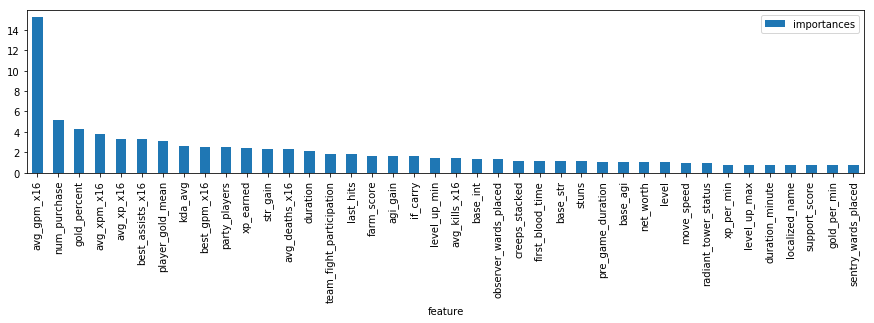

,importances
feature,
avg_gpm_x16,15.191414
num_purchase,5.160894
gold_percent,4.319469
avg_xpm_x16,3.751324
avg_xp_x16,3.339776


In [19]:
df_importances = pd.DataFrame(data = {'feature':X_add.columns,'importances':model_cb.feature_importances_})
df_importances.sort_values(by=['importances'],inplace=True,ascending=False)
df_importances = df_importances.set_index('feature')[:40]
df_importances.plot(kind='bar', figsize=(15, 3))
plt.show()
display(df_importances.head())